<a href="https://colab.research.google.com/github/avsolatorio/REaLTabFormer-Experiments/blob/main/Relational_REaLTabFormer_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !ln -s /content/drive/MyDrive/REaLTabFormer/REaLTabFormer-Experiments /content/REaLTabFormer-Experiments

In [4]:
# !pip install matplotlib==3.1.3 &> /dev/null

In [1]:
import json
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import torch

from pathlib import Path

In [3]:
import sdv.metrics
from sklearn.linear_model import LogisticRegression


class LogisticDetection(sdv.metrics.tabular.ScikitLearnClassifierDetectionMetric):
    """ScikitLearnClassifierDetectionMetric based on a LogisticRegression.

    This metric builds a LogisticRegression Classifier that learns to tell the synthetic
    data apart from the real data, which later on is evaluated using Cross Validation.

    The output of the metric is one minus the average ROC AUC score obtained.
    """

    name = 'LogisticRegression Detection'

    @staticmethod
    def _get_classifier():
        return LogisticRegression(solver='lbfgs', max_iter=500)

# m = sdv.metrics.relational.LogisticDetection(lm)

def report_logistic(real_in, real_out, rtf_in, rtf_out, sdv_in, sdv_out, join_on, seed=None, verbose=True):    
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)

    lm = LogisticDetection()

    real_flat = real_out.merge(real_in, on=join_on)
    rtf_flat = rtf_out.merge(rtf_in, on=join_on)
    sdv_flat = sdv_out.merge(sdv_in, on=join_on)
    
    data = dict(
        parent=dict(
            sdv=lm.compute(real_in.drop(join_on, axis=1), sdv_in.drop(join_on, axis=1)),
            rtf=lm.compute(real_in.drop(join_on, axis=1), rtf_in.drop(join_on, axis=1))),
        child=dict(
            sdv=lm.compute(real_out.drop(join_on, axis=1), sdv_out.drop(join_on, axis=1)),
            rtf=lm.compute(real_out.drop(join_on, axis=1), rtf_out.drop(join_on, axis=1))),
        merged=dict(
            sdv=lm.compute(real_flat.drop(join_on, axis=1), sdv_flat.drop(join_on, axis=1)),
            rtf=lm.compute(real_flat.drop(join_on, axis=1), rtf_flat.drop(join_on, axis=1))),
    )

    if verbose:
        print("LogisticDetection for parents")
        print("SDV:", data["parent"]["sdv"])
        print("REaLTabFormer:", data["parent"]["rtf"])
        print()
        print("LogisticDetection for children")
        print("SDV:", data["child"]["sdv"])
        print("REaLTabFormer:", data["child"]["rtf"])
        print()
        print("LogisticDetection for merged")
        print("SDV:", data["merged"]["sdv"])
        print("REaLTabFormer:", data["merged"]["rtf"])
    
    return data

# m.compute(tables, new_data, metadata)

In [4]:
import realtabformer
from realtabformer import REaLTabFormer

print(realtabformer.__version__)

0.0.2.3.9


In [5]:
RANDOM_SEED = 1029

RELATIONAL_DATA_PATH = Path("data/relational")
RELATIONAL_EXP_PATH = Path("exp-relational/")

ROSSMANN_DATA = RELATIONAL_DATA_PATH / "rossmann"
ROSSMANN_EXP = RELATIONAL_EXP_PATH / "rossmann"

AIRBNB_DATA = RELATIONAL_DATA_PATH / "airbnb"
AIRBNB_EXP = RELATIONAL_EXP_PATH / "airbnb"

TELSTRA_DATA = RELATIONAL_DATA_PATH / "telstra"
TELSTRA_EXP = RELATIONAL_EXP_PATH / "telstra"

# Rossmann Dataset

## Start and load data

In [6]:
data_id = "rossmann"
rossmann_parent = pd.read_csv(ROSSMANN_DATA / "store.csv")
rossmann_child = pd.read_csv(ROSSMANN_DATA / "train.csv")

rossmann_join_on = "Store"

join_on = rossmann_join_on

raw_parent_df = rossmann_parent.copy()
raw_child_df = rossmann_child[rossmann_child["Date"] > "2015-06"].copy()
raw_child_df.insert(1, "Date", raw_child_df.pop("Date"))
raw_child_df["Date"] = pd.to_datetime(raw_child_df["Date"])

# n_child = raw_child_df[join_on].value_counts()
# n_child.name = "n_child"
# n_child = n_child.reset_index().rename(columns={"index": join_on})

# raw_parent_df = raw_parent_df.merge(n_child, on=join_on)
# raw_parent_df.insert(1, "n_child", raw_parent_df.pop("n_child"))
# # raw_parent_df.insert(len(raw_parent_df.columns) - 1, "location", raw_parent_df.pop("location"))

print(raw_child_df.shape, raw_parent_df.shape)

(68015, 9) (1115, 10)


In [7]:
from sdv import Metadata
from sdv.relational import HMA1


def get_metadata_table(raw_parent_df, raw_child_df, join_on, parent_date_fields=None, child_date_fields=None):
    metadata = Metadata()
    parent_fields = {}
    child_fields = {}

    if parent_date_fields is not None:
        for field in parent_date_fields:
            parent_fields[field] = {
                    'type': 'datetime',
                    'format': '%Y-%m-%d'
                }
    
    if child_date_fields is not None:
        for field in child_date_fields:
            child_fields[field] = {
                    'type': 'datetime',
                    'format': '%Y-%m-%d'
                }

    metadata.add_table(
        name='parent',
        data=raw_parent_df,
        fields_metadata=parent_fields,
        primary_key=join_on
    )

    metadata.add_table(
        name='child',
        data=raw_child_df,
        fields_metadata=child_fields,
        parent='parent',
        foreign_key=join_on
    )

    tables = dict(
        parent=raw_parent_df,
        child=raw_child_df,
    )
    print(metadata)

    return metadata, tables

In [9]:
metadata, tables = get_metadata_table(raw_parent_df, raw_child_df, join_on, parent_date_fields=None, child_date_fields=["Date"])

rtf_raw_parent_df = tables["parent"].copy()
for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
    rtf_raw_parent_df[dt_col] = rtf_raw_parent_df[dt_col].view(int).astype(pd.Int64Dtype())

rtf_raw_child_df = tables["child"].copy()
for dt_col in tables["child"].select_dtypes(include="datetime").columns:
    rtf_raw_child_df[dt_col] = rtf_raw_child_df[dt_col].view(int).astype(pd.Int64Dtype())

Metadata
  root_path: .
  tables: ['parent', 'child']
  relationships:
    child.Store -> parent.Store


## Train the models


### REaLTabFormer parent table model

In [10]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

parent_rtf = REaLTabFormer(
    "tabular",
    checkpoints_dir=ROSSMANN_EXP / "parent_rtf_checkpoints",
    epochs=200,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=8,
    mask_rate=0.1,
    gradient_accumulation_steps=4 // torch.cuda.device_count(),
    early_stopping_patience=0,
    save_total_limit=0,
    save_steps=1000,
)

parent_rtf.fit(
    df=rtf_raw_parent_df.drop(join_on, axis=1),
    num_bootstrap=500,
    frac=0.165,
    n_critic=5,
    gen_rounds=3,
    sensitivity_max_col_nums=20,
    full_sensitivity=False,
    sensitivity_orig_frac_multiple=4,
)
parent_rtf.save(ROSSMANN_EXP / "rtf_parent_model")

Computing the sensitivity threshold...
Using parallel computation!!!


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.016153
std        0.037412
min       -0.025000
25%       -0.010823
50%        0.000865
75%        0.032468
max        0.193458
dtype: float64
Sensitivity threshold: 0.09377352762598665 qt_max: 0.05


  0%|          | 0/1115 [00:00<?, ?ex/s]

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 1115
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 175
  Number of trainable parameters = 43425792


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-35
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-35/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-35/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-70
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-70/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-70/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-105
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-105/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-105/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-140
Configuration saved in exp-relational/rossmann/par

Generated 0 invalid samples out of total 640 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/c

Critic round: 5, sensitivity_threshold: 0.09377352762598665, val_sensitivity: -0.002113944545638537, val_sensitivities: [0.05210989678202793, 0.060488767455980565, 0.03377352762598665, 0.05441712204007286, -0.011885245901639346, -0.021599878567091682, -0.025000000000000005, -0.023542805100182154, -0.025000000000000005, -0.022571341833636918, -0.025000000000000005, -0.024757134183363692, -0.016499696417729207, -0.022571341833636918, -0.014071038251366123]


***** Running training *****
  Num examples = 1115
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 350
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 175
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-210
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-210/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-210/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-245
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-245/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-245/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-280
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-280/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-280/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-315
Configuration saved in exp-relational/rossma

Generated 2 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.6875%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-350.


Critic round: 10, sensitivity_threshold: 0.09377352762598665, val_sensitivity: -0.011156648451730422, val_sensitivities: [-0.011278081360048577, 0.01774438372799028, -0.014071038251366122, -0.0036278081360048586, -0.025000000000000005, -0.014678202792956892, -0.021357012750455377, -0.02038554948391014, -0.02378567091681846, 0.008029751062537945, -0.015285367334547665, -0.014921068609593203, -0.00945658773527626, -0.009213721918639953, -0.010063752276867031]


***** Running training *****
  Num examples = 1115
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 525
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 350
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-385
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-385/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-385/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-420
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-420/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-420/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-455
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-455/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-455/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-490
Configuration saved in exp-relational/rossma

Generated 1 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.8438%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/c

Critic round: 15, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.00585205424003238, val_sensitivities: [-0.007999392835458412, -0.00969945355191257, 0.014101396478445657, 0.023208864602307224, -0.017471159684274443, 0.005115361262902245, -0.025000000000000005, -0.024514268366727387, -0.025000000000000005, -0.02293564055859138, -0.013585306618093505, 0.00438676381299332, 0.09400425015179113, 0.0029295689131754684, 0.09023982999392836]


***** Running training *****
  Num examples = 1115
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 700
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 15
  Continuing training from global step 525
  Will skip the first 15 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-560
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-560/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-560/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-595
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-595/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-595/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-630
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-630/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-630/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-665
Configuration saved in exp-relational/rossma

Generated 2 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.6875%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-700.


Critic round: 20, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.05186703096539161, val_sensitivities: [0.04069520340012143, 0.017987249544626594, 0.07457498482088645, 0.08368245294474802, -0.01030661809350334, 0.024787492410443226, -0.021114146933819068, 0.004508196721311474, -0.01662112932604736, 0.050166970248937466, 0.023330297510625375, 0.12873406193078324, 0.1105191256830601, 0.12994839101396477, 0.1371129326047359]


***** Running training *****
  Num examples = 1115
  Num Epochs = 25
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 875
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 20
  Continuing training from global step 700
  Will skip the first 20 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-735
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-735/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-735/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-770
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-770/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-770/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-805
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-805/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-805/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-840
Configuration saved in exp-relational/rossma

Generated 2 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.6875%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-875.


Critic round: 25, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.0006061526006881183, val_sensitivities: [-0.02038554948391014, -0.016742562234365516, -0.018199757134183363, -0.015406800242865818, -0.02378567091681846, 0.021873102610807525, -0.020992714025500913, 0.0009866423800850002, -0.019899817850637522, 0.00985124468731026, -0.017471159684274443, 0.024180327868852453, 0.04470248937462052, 0.02369459623557984, 0.03668791742562234]


***** Running training *****
  Num examples = 1115
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1050
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 25
  Continuing training from global step 875
  Will skip the first 25 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-910
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-910/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-910/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-945
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-945/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-945/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-980
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-980/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-980/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1000
Configuration saved in exp-relational/rossm

Generated 0 invalid samples out of total 640 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/c

Critic round: 30, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.017007690750860147, val_sensitivities: [0.020294474802671523, 0.061581663630843955, 0.016651487553126898, 0.04312386156648451, -0.018442622950819675, -0.004963570127504555, -0.012128111718275655, -0.0010777170613236206, -0.018442622950819675, -0.004356405585913784, -0.004842137219186401, 0.05125986642380084, 0.0439738919247116, 0.021751669702489373, 0.06073163327261687]


***** Running training *****
  Num examples = 1115
  Num Epochs = 35
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1225
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 30
  Continuing training from global step 1050
  Will skip the first 30 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1085
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1085/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1085/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1120
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1120/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1120/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1155
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1155/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1155/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1190
Configuration saved in exp-relatio

Generated 2 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.6875%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1225.


Critic round: 35, sensitivity_threshold: 0.09377352762598665, val_sensitivity: -0.006064561829589154, val_sensitivities: [-0.005449301760777172, -0.0018063145112325462, -0.0025349119611414715, -0.005570734669095326, -0.02378567091681846, 0.0014723740133576182, -0.025000000000000005, -0.013949605343047967, -0.025000000000000005, 0.019444444444444445, -0.021114146933819064, -0.0018063145112325453, 0.005358227079538554, 0.0028081360048573148, 0.0059653916211293255]


***** Running training *****
  Num examples = 1115
  Num Epochs = 40
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1400
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 35
  Continuing training from global step 1225
  Will skip the first 35 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1260
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1260/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1260/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1295
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1295/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1295/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1330
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1330/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1330/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1365
Configuration saved in exp-relatio

Generated 4 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.3750%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1400.


Critic round: 40, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.01073365715442218, val_sensitivities: [-0.006177899210686098, 0.008515482695810563, -0.00047055251973284997, 0.05101700060716454, -0.021599878567091682, -0.007270795385549484, -0.011642380085003037, -0.015406800242865818, -0.012613843351548271, -0.0036278081360048594, 0.0052367941712203984, 0.0426381299332119, 0.057695810564663025, 0.0413023679417122, 0.03340922890103218]


***** Running training *****
  Num examples = 1115
  Num Epochs = 45
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1575
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 40
  Continuing training from global step 1400
  Will skip the first 40 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1435
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1435/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1435/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1470
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1470/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1470/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1505
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1505/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1505/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1540
Configuration saved in exp-relatio

Generated 6 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.0625%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1575.


Critic round: 45, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.0227150374418134, val_sensitivities: [0.05453855494839101, 0.060245901639344256, 0.05490285367334548, 0.13006982392228295, 0.006208257437765633, 0.005115361262902245, -0.0005919854280510033, -0.004477838494231939, -0.007027929568913178, 0.003901032179720703, -0.004477838494231939, -0.0005919854280510041, 0.01495142683667274, 0.00960837887067395, 0.018351548269581058]


***** Running training *****
  Num examples = 1115
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1750
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 45
  Continuing training from global step 1575
  Will skip the first 45 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1610
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1610/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1610/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1645
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1645/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1645/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1680
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1680/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1680/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1715
Configuration saved in exp-relatio

Generated 3 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.5312%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1750.


Critic round: 50, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.025467516697024895, val_sensitivities: [0.023330297510625375, 0.049316939890710385, 0.017744383727990285, 0.05538858530661809, -0.01139951426836673, 0.006329690346083789, -0.0010777170613236197, 0.007544019429265331, -0.0056921675774134805, 0.02308743169398907, 0.005843958712811172, 0.042395264116575584, 0.04057377049180328, 0.06947480267152398, 0.059153005464480865]


***** Running training *****
  Num examples = 1115
  Num Epochs = 55
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1925
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 50
  Continuing training from global step 1750
  Will skip the first 50 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1785
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1785/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1785/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1820
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1820/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1820/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1855
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1855/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1855/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1890
Configuration saved in exp-relatio

Generated 8 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.7500%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1925.


Critic round: 55, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.04393341428860554, val_sensitivities: [0.07457498482088645, 0.05380995749848209, 0.10505464480874316, 0.1339556769884639, 0.01920157862780813, 0.035352155434122644, 0.011065573770491804, 0.027823315118397085, 0.006086824529447478, 0.03996660595021251, 0.0063296903460837856, 0.0338949605343048, 0.029159077109896778, 0.0397237401335762, 0.043002428658166364]


***** Running training *****
  Num examples = 1115
  Num Epochs = 60
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2100
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 55
  Continuing training from global step 1925
  Will skip the first 55 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1960
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1960/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1960/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1995
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1995/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-1995/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2000
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2000/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2030
Configuration saved in exp-relatio

Generated 8 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.7500%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2100.


Critic round: 60, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.06860048573163327, val_sensitivities: [0.09023982999392836, 0.06813904068002428, 0.15022768670309652, 0.13614146933819063, 0.03705221615057681, 0.06631754705525196, 0.03863084395871281, 0.060003035822707954, 0.060245901639344256, 0.05988160291438979, 0.02369459623557984, 0.038266545233758345, 0.05514571948998178, 0.08513964784456587, 0.05988160291438979]


***** Running training *****
  Num examples = 1115
  Num Epochs = 65
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2275
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 60
  Continuing training from global step 2100
  Will skip the first 60 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2135
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2135/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2135/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2170
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2170/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2170/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2205
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2205/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2205/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2240
Configuration saved in exp-relatio

Generated 5 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.2188%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2275.


Critic round: 65, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.032874924104432296, val_sensitivities: [0.05927443837279903, 0.09181845780206437, 0.05903157255616271, 0.07979659987856709, 0.010458409228901032, 0.018958712811171827, 0.003415300546448087, 0.003172434729811779, -0.0009562841530054649, 0.012887067395264117, 0.006086824529447479, 0.037659380692167586, 0.034137826350941106, 0.0439738919247116, 0.03340922890103218]


***** Running training *****
  Num examples = 1115
  Num Epochs = 70
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2450
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 65
  Continuing training from global step 2275
  Will skip the first 65 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2310
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2310/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2310/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2345
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2345/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2345/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2380
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2380/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2380/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2415
Configuration saved in exp-relatio

Generated 14 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.8125%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2450.


Critic round: 70, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08604634689334144, val_sensitivities: [0.12654826958105647, 0.10408318154219794, 0.1662568306010929, 0.16589253187613845, 0.05611718275652702, 0.015680024286581662, 0.009972677595628414, 0.01507285974499089, 0.0023224043715846963, 0.03693078324225865, 0.038509411050394654, 0.1527777777777778, 0.12205525197328478, 0.127762598664238, 0.15071341833636914]


***** Running training *****
  Num examples = 1115
  Num Epochs = 75
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2625
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 70
  Continuing training from global step 2450
  Will skip the first 70 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2485
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2485/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2485/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2520
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2520/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2520/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2555
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2555/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2555/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2590
Configuration saved in exp-relatio

Generated 10 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.4375%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2625.


Critic round: 75, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.05856203197733252, val_sensitivities: [0.06631754705525197, 0.050045537340619305, 0.07396782027929569, 0.10942622950819672, 0.01738008500303582, 0.04518822100789313, 0.020294474802671523, 0.05636004857316332, 0.015315725561627204, 0.07748937462052215, 0.020173041894353365, 0.045431086824529454, 0.07639647844565876, 0.08817547055251973, 0.11646933819064967]


***** Running training *****
  Num examples = 1115
  Num Epochs = 80
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2800
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 75
  Continuing training from global step 2625
  Will skip the first 75 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2660
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2660/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2660/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2695
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2695/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2695/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2730
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2730/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2730/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2765
Configuration saved in exp-relatio

Generated 7 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.9062%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2800.


Critic round: 80, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07953754300748836, val_sensitivities: [0.08805403764420155, 0.07955373406193078, 0.15884942319368547, 0.1669854280510018, 0.02296599878567092, 0.05016697024893746, 0.00900121432908318, 0.04312386156648451, 0.008151183970856101, 0.07238919247115967, 0.03814511232544019, 0.06668184578020643, 0.1494990892531876, 0.08465391621129327, 0.15484213721918638]


***** Running training *****
  Num examples = 1115
  Num Epochs = 85
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2975
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 80
  Continuing training from global step 2800
  Will skip the first 80 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2835
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2835/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2835/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2870
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2870/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2870/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2905
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2905/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2905/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2940
Configuration saved in exp-relatio

Generated 6 invalid samples out of total 640 samples generated. Sampling efficiency is: 99.0625%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-2975.


Critic round: 85, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.045714430277271796, val_sensitivities: [0.04494535519125683, 0.04858834244080145, 0.06024590163934426, 0.1288554948391014, 0.03353066180935034, 0.09582574377656344, 0.018594414086217363, 0.05757437765634486, 0.015437158469945355, 0.05065270188221008, 0.010336976320582877, 0.018351548269581058, 0.035109289617486335, 0.031102003642987246, 0.03656648451730418]


***** Running training *****
  Num examples = 1115
  Num Epochs = 90
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3150
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 85
  Continuing training from global step 2975
  Will skip the first 85 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3000
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3000/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3010
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3010/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3010/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3045
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3045/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3045/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3080
Configuration saved in exp-relatio

Generated 10 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.4375%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3150.


Critic round: 90, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.06902954867435743, val_sensitivities: [0.03559502125075895, 0.03911657559198543, 0.05174559805707347, 0.08307528840315725, 0.008515482695810563, 0.1368700667880996, 0.07056769884638738, 0.1254553734061931, 0.12691256830601094, 0.13747723132969034, 0.013858530661809346, 0.0397237401335762, 0.059274438372799026, 0.03899514268366728, 0.06826047358834243]


***** Running training *****
  Num examples = 1115
  Num Epochs = 95
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3325
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 90
  Continuing training from global step 3150
  Will skip the first 90 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3185
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3185/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3185/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3220
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3220/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3220/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3255
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3255/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3255/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3290
Configuration saved in exp-relatio

Generated 14 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.8125%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3325.


Critic round: 95, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.0872849625581866, val_sensitivities: [0.08101092896174864, 0.09837583485124468, 0.09558287795992713, 0.0802823315118397, 0.03765938069216758, 0.09825440194292653, 0.051624165148755306, 0.07506071645415907, 0.050531268973891916, 0.1076047358834244, 0.0627959927140255, 0.11282635094110503, 0.13140558591378262, 0.09898299939283545, 0.12727686703096538]


***** Running training *****
  Num examples = 1115
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3500
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 95
  Continuing training from global step 3325
  Will skip the first 95 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3360
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3360/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3360/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3395
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3395/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3395/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3430
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3430/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3430/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3465
Configuration saved in exp-relatio

Generated 12 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.1250%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3500.


Critic round: 100, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07612123052013761, val_sensitivities: [0.11622647237401335, 0.150591985428051, 0.12897692774741953, 0.21349423193685488, 0.05721007893139039, 0.04203096539162113, -0.0064207650273224075, 0.024301760777170608, 0.0001366120218579222, 0.06425318761384335, 0.03972374013357619, 0.10505464480874317, 0.07700364298724954, 0.053081360048573153, 0.07615361262902247]


***** Running training *****
  Num examples = 1115
  Num Epochs = 105
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3675
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 100
  Continuing training from global step 3500
  Will skip the first 100 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3535
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3535/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3535/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3570
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3570/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3570/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3605
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3605/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3605/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3640
Configuration saved in exp-relatio

Generated 14 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.8125%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3675.


Critic round: 105, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08618397085610201, val_sensitivities: [0.03571645415907711, 0.04360959319975713, 0.06376745598057074, 0.07736794171220401, 0.015194292653309047, 0.14622040072859743, 0.10299028536733454, 0.1465846994535519, 0.062067395264116566, 0.13978445658773528, 0.04664541590771099, 0.08489678202792955, 0.09266848816029144, 0.11149058894960534, 0.12375531268973892]


***** Running training *****
  Num examples = 1115
  Num Epochs = 110
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3850
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 105
  Continuing training from global step 3675
  Will skip the first 105 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3710
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3710/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3710/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3745
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3745/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3745/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3780
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3780/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3780/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3815
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3850.


Critic round: 110, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.047730216555353165, val_sensitivities: [0.05283849423193685, 0.053567091681845785, 0.07651791135397694, 0.10954766241651487, 0.017015786278081355, 0.04494535519125683, 0.013858530661809351, 0.017015786278081358, 0.013372799028536731, 0.05733151183970856, 0.029644808743169396, 0.03863084395871281, 0.058060109289617495, 0.06449605343047966, 0.06911050394656952]


***** Running training *****
  Num examples = 1115
  Num Epochs = 115
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4025
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 110
  Continuing training from global step 3850
  Will skip the first 110 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3885
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3885/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3885/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3920
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3920/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3920/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3955
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3955/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3955/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-3990
Configuration saved in exp-relatio

Generated 24 invalid samples out of total 640 samples generated. Sampling efficiency is: 96.2500%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4025.


Critic round: 115, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.0702762598664238, val_sensitivities: [0.07348208864602307, 0.12084092289010322, 0.08441105039465696, 0.1452489374620522, 0.056602914389799634, 0.05721007893139041, 0.04506678809957498, 0.060245901639344256, 0.046888281724347294, 0.06765330904675165, 0.040330904675166965, 0.06024590163934426, 0.07263205828779598, 0.05806010928961748, 0.06522465088038859]


***** Running training *****
  Num examples = 1115
  Num Epochs = 120
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4200
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 115
  Continuing training from global step 4025
  Will skip the first 115 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4060
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4060/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4060/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4095
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4095/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4095/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4130
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4130/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4130/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4165
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4200.


Critic round: 120, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08034709572960937, val_sensitivities: [0.14051305403764416, 0.14913479052823314, 0.18034304796599876, 0.1920006071645416, 0.06558894960534306, 0.09691863995142684, 0.014344262295081971, 0.06267455980570734, 0.05223132969034608, 0.08052519732847602, 0.0026867030965391603, 0.04870977534911961, 0.04445962355798421, 0.035230722525804496, 0.039845173041894354]


***** Running training *****
  Num examples = 1115
  Num Epochs = 125
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4375
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 120
  Continuing training from global step 4200
  Will skip the first 120 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4235
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4235/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4235/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4270
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4270/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4270/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4305
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4305/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4305/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4340
Configuration saved in exp-relatio

Generated 21 invalid samples out of total 640 samples generated. Sampling efficiency is: 96.7188%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4375.


Critic round: 125, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07527120016191055, val_sensitivities: [0.08902550091074682, 0.10238312082574377, 0.11124772313296903, 0.15314207650273226, 0.05247419550698239, 0.08246812386156649, 0.000986642380085002, 0.03632361870066788, 0.004022465088038858, 0.05721007893139041, 0.025758955676988462, 0.15848512446873103, 0.08404675166970249, 0.07797510625379478, 0.09351851851851851]


***** Running training *****
  Num examples = 1115
  Num Epochs = 130
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4550
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 125
  Continuing training from global step 4375
  Will skip the first 125 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4410
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4410/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4410/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4445
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4445/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4445/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4480
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4480/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4480/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4515
Configuration saved in exp-relatio

Generated 14 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.8125%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4550.


Critic round: 130, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.05907205019226878, val_sensitivities: [0.01847298117789921, 0.028916211293260472, 0.029159077109896778, 0.05125986642380084, 0.004508196721311474, 0.13322707953855495, 0.016772920461445052, 0.06486035215543412, 0.017015786278081358, 0.08611111111111111, 0.0471311475409836, 0.0762750455373406, 0.0975258044930176, 0.12169095324833029, 0.09315421979356404]


***** Running training *****
  Num examples = 1115
  Num Epochs = 135
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4725
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 130
  Continuing training from global step 4550
  Will skip the first 130 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4585
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4585/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4585/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4620
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4620/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4620/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4655
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4655/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4655/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4690
Configuration saved in exp-relatio

Generated 12 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.1250%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/not-best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/not-best-disc-model/config.json


Saving not-best model...


Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/not-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4725.


Critic round: 135, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.10088544828981988, val_sensitivities: [0.14524893746205222, 0.1532635094110504, 0.1638281724347298, 0.1696569520340012, 0.07056769884638736, 0.11513357619914998, 0.0065725561627200954, 0.05514571948998178, 0.04324529447480268, 0.10396174863387977, 0.0453096539162113, 0.09351851851851853, 0.11173345476624164, 0.10845476624165148, 0.12764116575591988]


***** Running training *****
  Num examples = 1115
  Num Epochs = 140
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 4900
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 135
  Continuing training from global step 4725
  Will skip the first 135 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4760
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4760/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4760/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4795
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4795/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4795/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4830
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4830/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4830/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4865
Configuration saved in exp-relatio

Generated 8 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.7500%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4900.


Critic round: 140, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07392734264318963, val_sensitivities: [0.0484669095324833, 0.041909532483302966, 0.09242562234365513, 0.13419854280510018, 0.023451730418943533, 0.11476927747419549, 0.06316029143897997, 0.10748330297510626, 0.05125986642380084, 0.1476775956284153, 0.02745901639344262, 0.04543108682452944, 0.06231026108075288, 0.07542501517911354, 0.07348208864602307]


***** Running training *****
  Num examples = 1115
  Num Epochs = 145
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5075
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 140
  Continuing training from global step 4900
  Will skip the first 140 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4935
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4935/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4935/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4970
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4970/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-4970/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5000
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5000/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5005
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5075.


Critic round: 145, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.06898907103825137, val_sensitivities: [0.08598967820279296, 0.08307528840315724, 0.1264268366727383, 0.16006375227686703, 0.05733151183970856, 0.007544019429265331, -0.0020491803278688556, 0.004508196721311474, 0.007786885245901638, 0.0035367334547662397, 0.04312386156648451, 0.11865513054037644, 0.0935185185185185, 0.11792653309046752, 0.12739829993928353]


***** Running training *****
  Num examples = 1115
  Num Epochs = 150
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5250
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 145
  Continuing training from global step 5075
  Will skip the first 145 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5110
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5110/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5110/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5145
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5145/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5145/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5180
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5180/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5180/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5215
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5250.


Critic round: 150, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07408925318761383, val_sensitivities: [0.08307528840315725, 0.08586824529447479, 0.12703400121432906, 0.09752580449301759, 0.0025652701882210058, 0.12387674559805707, 0.01653005464480874, 0.06571038251366121, 0.021751669702489373, 0.12849119611414694, 0.030859137826350944, 0.07433211900425016, 0.08319672131147542, 0.08526108075288402, 0.08526108075288402]


***** Running training *****
  Num examples = 1115
  Num Epochs = 155
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5425
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 150
  Continuing training from global step 5250
  Will skip the first 150 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5285
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5285/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5285/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5320
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5320/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5320/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5355
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5355/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5355/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5390
Configuration saved in exp-relatio

Generated 17 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.3438%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5425.


Critic round: 155, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07189536531066586, val_sensitivities: [0.08343958712811171, 0.08914693381906497, 0.09971159684274439, 0.15654219793564056, 0.030373406193078323, 0.03778081360048573, 0.021508803885853064, 0.042638129933211893, 0.016408621736490586, 0.017501517911353976, 0.044945355191256836, 0.11525500910746812, 0.12849119611414694, 0.08222525804493017, 0.11246205221615058]


***** Running training *****
  Num examples = 1115
  Num Epochs = 160
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5600
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 155
  Continuing training from global step 5425
  Will skip the first 155 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5460
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5460/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5460/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5495
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5495/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5495/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5530
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5530/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5530/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5565
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5600.


Critic round: 160, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.03409734871483505, val_sensitivities: [0.06753187613843352, 0.0442167577413479, 0.09825440194292653, 0.11258348512446875, 0.004508196721311472, 0.031952034001214324, 0.017622950819672127, 0.01980874316939891, 0.009972677595628414, 0.0296448087431694, 0.0054796599878567075, 0.01495142683667274, 0.024058894960534302, 0.014587128111718275, 0.016287188828172434]


***** Running training *****
  Num examples = 1115
  Num Epochs = 165
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5775
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 160
  Continuing training from global step 5600
  Will skip the first 160 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5635
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5635/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5635/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5670
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5670/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5670/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5705
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5705/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5705/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5740
Configuration saved in exp-relatio

Generated 12 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.1250%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5775.


Critic round: 165, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08454867435741752, val_sensitivities: [0.12096235579842138, 0.12715543412264724, 0.1501062537947784, 0.19115057680631453, 0.05866727383120826, 0.06036733454766241, 0.03498785670916819, 0.041788099574984826, 0.04142380085003036, 0.06558894960534305, 0.024908925318761384, 0.09473284760170005, 0.08113236187006678, 0.09084699453551912, 0.08441105039465696]


***** Running training *****
  Num examples = 1115
  Num Epochs = 170
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5950
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 165
  Continuing training from global step 5775
  Will skip the first 165 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5810
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5810/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5810/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5845
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5845/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5845/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5880
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5880/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5880/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5915
Configuration saved in exp-relatio

Generated 13 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.9688%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5950.


Critic round: 170, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07881704108480063, val_sensitivities: [0.17402853673345475, 0.15897085610200362, 0.15654219793564053, 0.1816788099574985, 0.06170309653916211, 0.04081663630843958, 0.006815421979356406, 0.036445051608986034, -0.0013205828779599281, 0.08938979963570128, 0.03365209471766848, 0.05259562841530055, 0.05599574984820886, 0.06243169398907104, 0.07251062537947783]


***** Running training *****
  Num examples = 1115
  Num Epochs = 175
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6125
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 170
  Continuing training from global step 5950
  Will skip the first 170 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5985
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5985/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-5985/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6000
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6000/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6020
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6020/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6020/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6055
Configuration saved in exp-relatio

Generated 15 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.6562%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6125.


Critic round: 175, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08621635296498685, val_sensitivities: [0.10335458409228901, 0.08246812386156649, 0.11901942926533089, 0.13857012750455375, 0.014465695203400119, 0.10772616879174257, 0.101775956284153, 0.1360200364298725, 0.06571038251366121, 0.1667425622343655, 0.03523072252580449, 0.04603825136612021, 0.07056769884638738, 0.04251669702489374, 0.06303885853066181]


***** Running training *****
  Num examples = 1115
  Num Epochs = 180
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6300
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 175
  Continuing training from global step 6125
  Will skip the first 175 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6160
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6160/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6160/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6195
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6195/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6195/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6230
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6230/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6230/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6265
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6300.


Critic round: 180, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.05117891115158875, val_sensitivities: [0.017015786278081358, 0.015680024286581662, 0.034866423800850026, 0.049316939890710385, 0.02260170006071645, 0.02466605950212507, 0.012158469945355188, 0.01519429265330904, 0.006693989071038248, 0.01908014571948998, 0.04895264116575592, 0.09886156648451731, 0.13164845173041895, 0.10930479659987857, 0.16164238008500303]


***** Running training *****
  Num examples = 1115
  Num Epochs = 185
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6475
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 180
  Continuing training from global step 6300
  Will skip the first 180 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6335
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6335/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6335/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6370
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6370/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6370/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6405
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6405/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6405/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6440
Configuration saved in exp-relatio

Generated 15 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.6562%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6475.


Critic round: 185, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.07935944140862174, val_sensitivities: [0.014587128111718275, 0.03608075288403157, 0.02187310261080753, 0.06668184578020644, 0.014344262295081971, 0.07093199757134182, 0.023087431693989073, 0.02745901639344262, 0.021994535519125682, 0.05708864602307225, 0.08368245294474802, 0.18544323011536126, 0.1723284760170006, 0.2048724954462659, 0.18993624772313297]


***** Running training *****
  Num examples = 1115
  Num Epochs = 190
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6650
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 185
  Continuing training from global step 6475
  Will skip the first 185 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6510
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6510/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6510/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6545
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6545/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6545/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6580
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6580/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6580/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6615
Configuration saved in exp-relatio

Generated 12 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.1250%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6650.


Critic round: 190, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.06417223234163123, val_sensitivities: [0.04895264116575592, 0.022237401335761988, 0.04834547662416514, 0.058181542197935636, 0.011065573770491804, 0.11452641165755921, 0.026123254401942925, 0.08088949605343049, 0.03438069216757741, 0.08137522768670309, 0.041909532483302966, 0.06741044323011534, 0.11768366727383121, 0.0914541590771099, 0.1180479659987857]


***** Running training *****
  Num examples = 1115
  Num Epochs = 195
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6825
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 190
  Continuing training from global step 6650
  Will skip the first 190 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6685
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6685/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6685/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6720
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6720/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6720/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6755
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6755/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6755/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6790
Configuration saved in exp-relatio

Generated 14 invalid samples out of total 640 samples generated. Sampling efficiency is: 97.8125%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6825.


Critic round: 195, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.08896073669297712, val_sensitivities: [0.07445355191256829, 0.07202489374620522, 0.11744080145719489, 0.1299483910139648, 0.035595021250758946, 0.10104735883424408, 0.040088038858530656, 0.06340315725561627, 0.014708561020036426, 0.06716757741347906, 0.07931086824529447, 0.12921979356405586, 0.1362629022465088, 0.12666970248937462, 0.14707043108682452]


***** Running training *****
  Num examples = 1115
  Num Epochs = 200
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 7000
  Number of trainable parameters = 43425792
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 195
  Continuing training from global step 6825
  Will skip the first 195 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6860
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6860/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6860/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6895
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6895/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6895/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6930
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6930/config.json
Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6930/pytorch_model.bin
Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/checkpoint-6965
Configuration saved in exp-relatio

Generated 11 invalid samples out of total 640 samples generated. Sampling efficiency is: 98.2812%


Saving model checkpoint to exp-relational/rossmann/parent_rtf_checkpoints/last-epoch-model
Configuration saved in exp-relational/rossmann/parent_rtf_checkpoints/last-epoch-model/config.json


Critic round: 200, sensitivity_threshold: 0.09377352762598665, val_sensitivity: 0.12016899413074277, val_sensitivities: [0.1832574377656345, 0.20292956891317548, 0.1452489374620522, 0.16200667880995748, 0.025637522768670307, 0.1785215543412265, 0.07967516697024893, 0.14306314511232543, 0.07044626593806921, 0.129341226472374, 0.04385245901639344, 0.08441105039465696, 0.09254705525197328, 0.12011232544019429, 0.14148451730418943]


Model weights saved in exp-relational/rossmann/parent_rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file exp-relational/rossmann/parent_rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 144
}

loading weights file exp-rel

Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model


### REaLTabFormer child table model

In [11]:
parent_realtabformer_path = sorted(
    [p for p in (ROSSMANN_EXP / "rtf_parent_model").glob("id*") if p.is_dir()],
    key=os.path.getmtime)[-1]

parent_realtabformer_path

PosixPath('exp-relational/rossmann/rtf_parent_model/id000016745219893152276480')

In [12]:
# date_transform = "object"
# if date_transform == "int":
#     # Perform explicit transform here of the Date variable to int
#     raw_child_df["Date"] = (raw_child_df["Date"].view(int) / 1e9).astype(int)
#     raw_child_df["Date"].dtype
# elif date_transform == "object":
#     # Perform explicit transform here of the Date variable to object
#     raw_child_df["Date"] = raw_child_df["Date"].dt.strftime("%Y-%m-%d")
#     raw_child_df["Date"].dtype
# else:
#     raise ValueError("Unsupported transform!")

# raw_child_df.select_dtypes(include=np.number)

In [13]:
torch.cuda.empty_cache()
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

child_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path=parent_realtabformer_path,
    epochs=50,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=4,
    train_size=0.8,
    early_stopping_patience=2,
    save_steps=1000,
    gradient_accumulation_steps=4 // torch.cuda.device_count()
)
child_rtf.fit(df=rtf_raw_child_df, in_df=rtf_raw_parent_df, join_on=join_on)

print(child_rtf.relational_max_length)
child_rtf.save(ROSSMANN_EXP / "rtf_child_model")

  0%|          | 0/68015 [00:00<?, ?ex/s]

  0%|          | 0/1115 [00:00<?, ?ex/s]

  0%|          | 0/1115 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 892
  Num Epochs = 50
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 2800
  Number of trainable parameters = 58576128


***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
Saving model checkpoint to rtf_checkpoints/checkpoint-1000
Configuration saved in rtf_checkpoints/checkpoint-1000/config.json
Model weights saved in rtf_checkpoints/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 223
  Batch size = 8
***** Running Evaluation *****
  Num examp

2138


In [14]:
parent_rtf = REaLTabFormer.load_from_dir(parent_realtabformer_path)

Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 144
}



### Generate samples

In [15]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

rtf_parent_df = parent_rtf.sample(n_samples=len(raw_parent_df))
rtf_parent_df.index.name = join_on
rtf_parent_df = rtf_parent_df.reset_index()
rtf_parent_df.head()

1129it [00:03, 330.99it/s]                          

Generated 23 invalid samples out of total 1152 samples generated. Sampling efficiency is: 98.0035%


Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      0         c          c               3850.0                        NaN   
1      1         a          c               3300.0                       11.0   
2      2         d          c              14620.0                        NaN   
3      3         a          a                 90.0                        8.0   
4      4         b          a                150.0                        9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                       NaN       0              NaN              NaN   
1                    2010.0       0              NaN              NaN   
2                       NaN       0              NaN              NaN   
3                    2010.0       0              NaN              NaN   
4                    2006.0       0              NaN              NaN   

  PromoInterval  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [16]:
lm = LogisticDetection()
lm.compute(rtf_raw_parent_df.drop(join_on, axis=1), rtf_parent_df.drop(join_on, axis=1))

0.9499293124165505

In [17]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

rtf_child_df = child_rtf.sample(
    input_unique_ids=rtf_parent_df[join_on],
    input_df=rtf_parent_df.drop(join_on, axis=1),
    gen_batch=64)

rtf_child_df.index.name = join_on
rtf_child_df = rtf_child_df.reset_index()
rtf_child_df = rtf_child_df[raw_child_df.columns]

rtf_child_df.head()

  0%|          | 0/1115 [00:00<?, ?ex/s]

100%|██████████| 18/18 [12:46<00:00, 42.59s/it]


Store                 Date  DayOfWeek  Sales  Customers  Open  Promo  \
0      0  1438300800000000000          5  10169        847     1      1   
1      0  1438214400000000000          4  10400        700     1      1   
2      0  1438128000000000000          3  10400        680     1      1   
3      0  1438041600000000000          2  12228        708     1      1   
4      0  1437955200000000000          1  14976        770     1      1   

  StateHoliday  SchoolHoliday  
0            0              1  
1            0              1  
2            0              1  
3            0              1  
4            0              1

In [18]:
m = sdv.metrics.relational.LogisticDetection(lm)

rtf_tables = dict(
    parent=rtf_parent_df.copy(),
    child=rtf_child_df.copy(),
)

for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
    rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

for dt_col in tables["child"].select_dtypes(include="datetime").columns:
    rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

m.compute(tables, rtf_tables, metadata)

{'parent': {'score': 0.9499293124165505},
 'child': {'score': 0.8161843121891482}}

<AxesSubplot: xlabel='Date'>

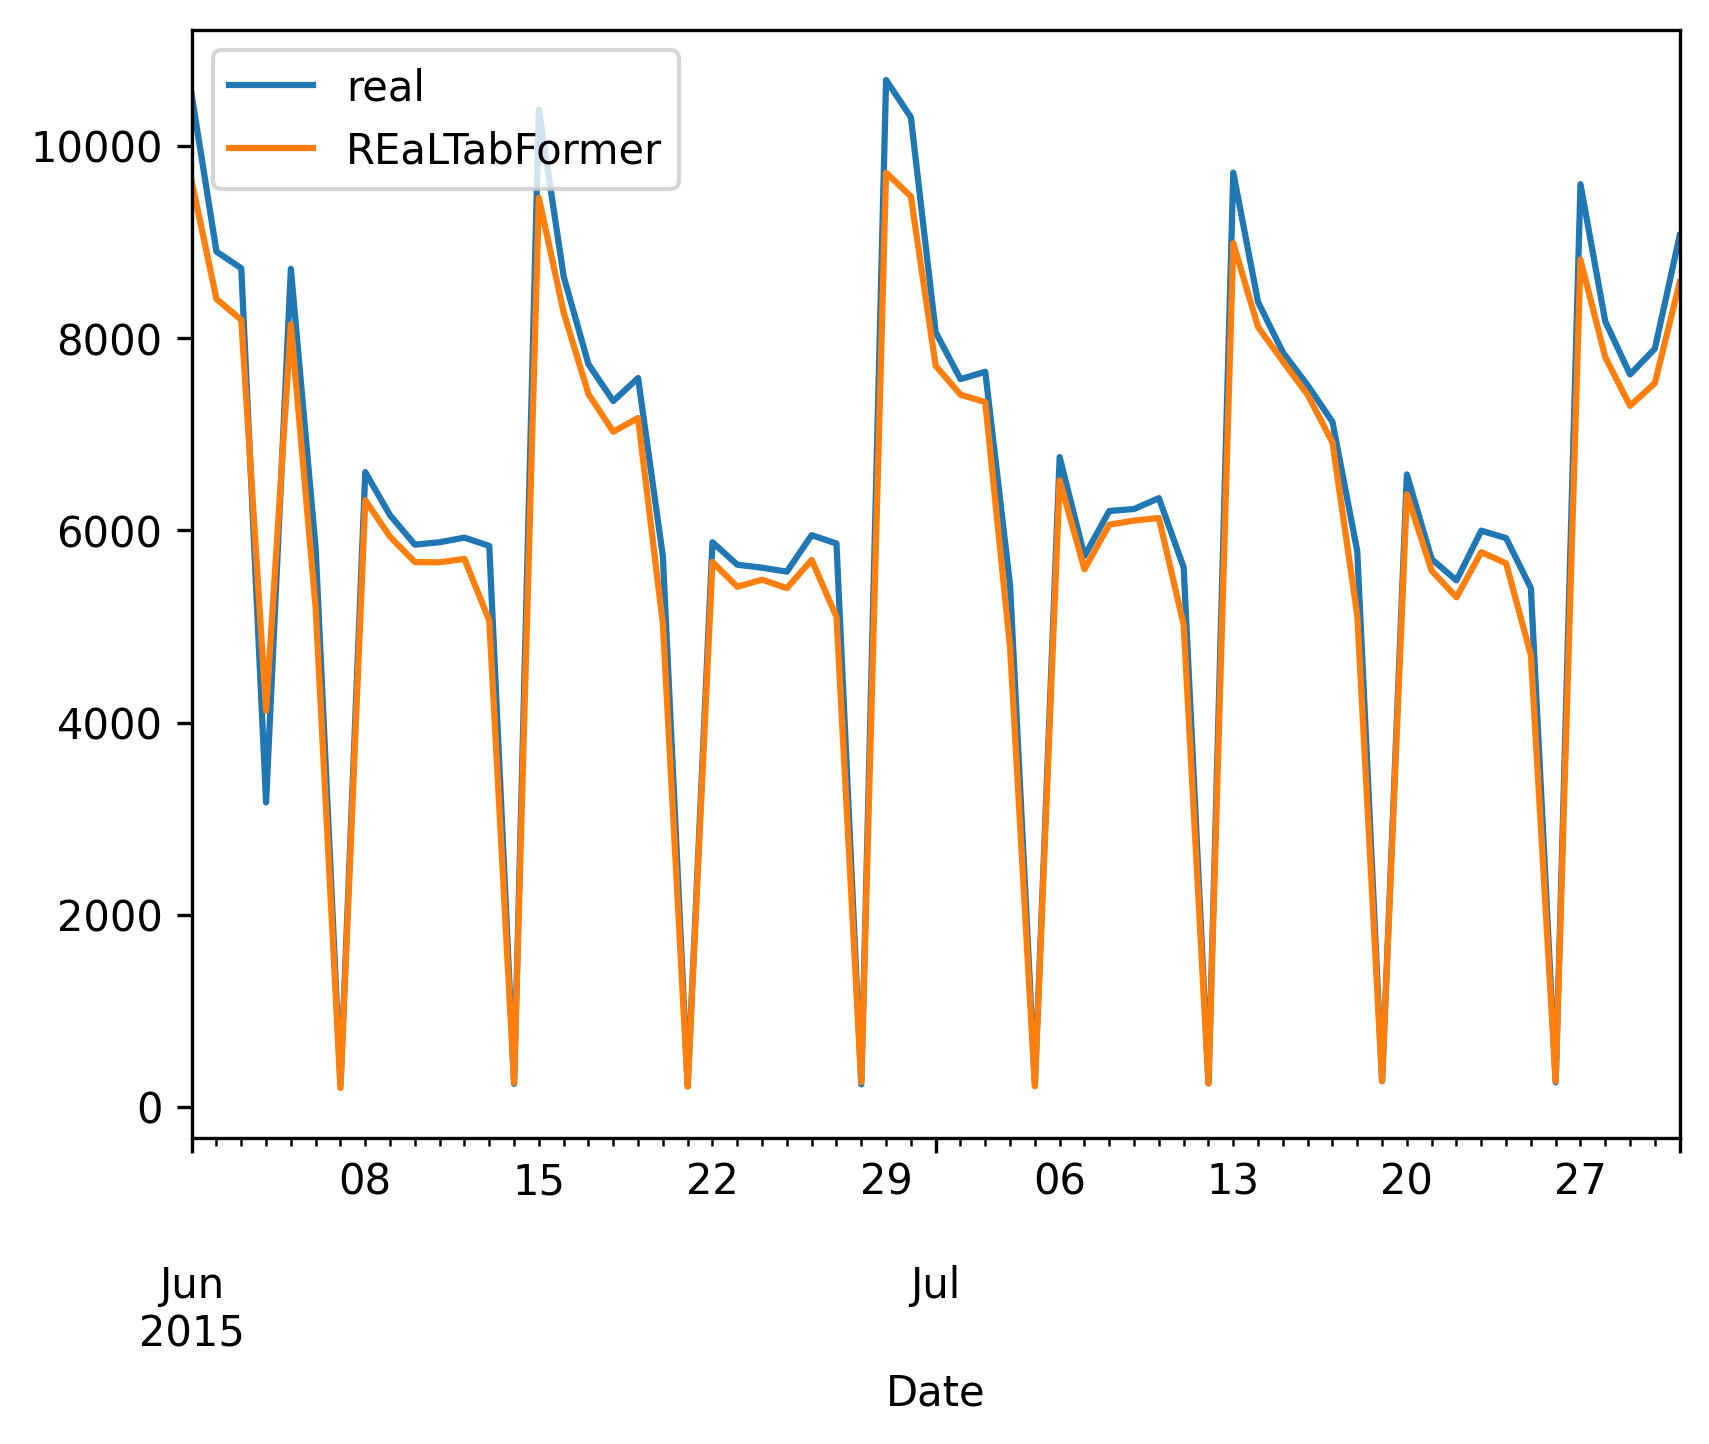

In [19]:
comp = pd.DataFrame()

comp["real"] = tables["child"].groupby("Date")["Sales"].mean()
comp["REaLTabFormer"] = rtf_tables["child"].groupby("Date")["Sales"].mean()
# comp["SDV"] = sdv_child_df.groupby("Date")["Sales"].mean()

comp = comp.sort_index()
comp.index = pd.to_datetime(comp.index)

fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

In [20]:
import random


RTF_SAMPLES = (ROSSMANN_EXP / "rtf_samples")
RTF_SAMPLES.mkdir(parents=True, exist_ok=True)

for seed in range(5):
    SEED_RTF_SAMPLES = RTF_SAMPLES / f"sample_seed{seed}"
    SEED_RTF_SAMPLES.mkdir(parents=True, exist_ok=True)
    n_parent = int(len(tables["parent"]) * 1.5)

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    rtf_parent_df = parent_rtf.sample(n_samples=n_parent)
    rtf_parent_df.index.name = join_on
    rtf_parent_df = rtf_parent_df.reset_index()

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    rtf_child_df = child_rtf.sample(
        input_unique_ids=rtf_parent_df[join_on],
        input_df=rtf_parent_df.drop(join_on, axis=1),
        gen_batch=32)

    rtf_child_df.index.name = join_on
    rtf_child_df = rtf_child_df.reset_index()
    rtf_child_df = rtf_child_df[raw_child_df.columns]
    rtf_child_df.head()

    # if date_transform == "int":
    #     rtf_child_df["Date"] = pd.to_datetime(rtf_child_df["Date"] * 1e9).strftime("%Y-%m-%d")

    rtf_tables = dict(
        parent=rtf_parent_df.copy(),
        child=rtf_child_df.copy(),
    )

    for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
        rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

    for dt_col in tables["child"].select_dtypes(include="datetime").columns:
        rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

    rtf_tables["parent"].astype(tables["parent"].dtypes).to_csv(SEED_RTF_SAMPLES / "rtf_parent.csv", index=None)
    rtf_tables["child"].astype(tables["child"].dtypes).to_csv(SEED_RTF_SAMPLES / "rtf_child.csv", index=None)

    print(seed,
          lm.compute(tables["parent"].drop(join_on, axis=1), rtf_tables["parent"].drop(join_on, axis=1)),
          lm.compute(tables["child"].drop(join_on, axis=1), rtf_tables["child"].drop(join_on, axis=1)))

    m = sdv.metrics.relational.LogisticDetection(lm)
    print(seed, m.compute(tables, rtf_tables, metadata))

1760it [00:05, 334.04it/s]                          

Generated 32 invalid samples out of total 1792 samples generated. Sampling efficiency is: 98.2143%


  0%|          | 0/1672 [00:00<?, ?ex/s]

100%|██████████| 53/53 [25:37<00:00, 29.00s/it]


0 0.9723920484767602 0.8186920507496668
0 {'parent': {'score': 0.9344624042411621}, 'child': {'score': 0.6294403394344028}}


1759it [00:05, 334.20it/s]                          

Generated 33 invalid samples out of total 1792 samples generated. Sampling efficiency is: 98.1585%


  0%|          | 0/1672 [00:00<?, ?ex/s]

100%|██████████| 53/53 [25:38<00:00, 29.02s/it]


1 0.93791736794886 0.8380248936201562
1 {'parent': {'score': 0.9405860590074999}, 'child': {'score': 0.6359980952255286}}


1762it [00:05, 334.67it/s]                          

Generated 30 invalid samples out of total 1792 samples generated. Sampling efficiency is: 98.3259%


  0%|          | 0/1672 [00:00<?, ?ex/s]

100%|██████████| 53/53 [25:37<00:00, 29.01s/it]


2 0.9187757614626514 0.8236631141991367
2 {'parent': {'score': 0.9399505276658336}, 'child': {'score': 0.6400894797368608}}


1754it [00:05, 332.73it/s]                          

Generated 38 invalid samples out of total 1792 samples generated. Sampling efficiency is: 97.8795%


  0%|          | 0/1672 [00:00<?, ?ex/s]

100%|██████████| 53/53 [25:37<00:00, 29.01s/it]


3 0.9507512635365307 0.8210425583909836
3 {'parent': {'score': 0.9295501651940644}, 'child': {'score': 0.6322833427424281}}


1763it [00:05, 334.98it/s]                          

Generated 29 invalid samples out of total 1792 samples generated. Sampling efficiency is: 98.3817%


  0%|          | 0/1672 [00:00<?, ?ex/s]

100%|██████████| 53/53 [25:39<00:00, 29.05s/it]


4 0.9548544751388325 0.8038231041036289
4 {'parent': {'score': 0.9055204750406963}, 'child': {'score': 0.631291210007279}}


In [46]:
torch.cuda.empty_cache()
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

model = HMA1(metadata)
model.fit(tables)


SDV_SAMPLES = (ROSSMANN_EXP / "sdv_samples")
SDV_SAMPLES.mkdir(parents=True, exist_ok=True)

for seed in range(5):
    SEED_SDV_SAMPLES = SDV_SAMPLES / f"sample_seed{seed}"
    SEED_SDV_SAMPLES.mkdir(parents=True, exist_ok=True)
    n_parent = int(len(tables["parent"]) * 1.5)

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    sdv_tables = model.sample(num_rows=len(tables["parent"]))
    sdv_tables["child"] = sdv_tables["child"][tables["child"].columns]

    sdv_tables["parent"].astype(tables["parent"].dtypes).to_csv(SEED_SDV_SAMPLES / "sdv_parent.csv", index=None)
    sdv_tables["child"].astype(tables["child"].dtypes).to_csv(SEED_SDV_SAMPLES / "sdv_child.csv", index=None)

    print(seed,
          lm.compute(tables["parent"].drop(join_on, axis=1), sdv_tables["parent"].drop(join_on, axis=1)),
          lm.compute(tables["child"].drop(join_on, axis=1), sdv_tables["child"].drop(join_on, axis=1)))

    m = sdv.metrics.relational.LogisticDetection(lm)
    print(seed, m.compute(tables, sdv_tables, metadata))

0 0.81634349857064 0.16645228309041415
0 {'parent': {'score': 0.8276489281436958}, 'child': {'score': 0.166536255073915}}
1 0.7964695514503596 0.1582038673586137
1 {'parent': {'score': 0.7883985881649479}, 'child': {'score': 5.643227436791243e-06}}
2 0.8152613631747986 0.17266725592210774
2 {'parent': {'score': 0.7996478826785308}, 'child': {'score': 0.0}}
3 0.7996808651099582 0.16325599306110294
3 {'parent': {'score': 0.8227819548598808}, 'child': {'score': 0.0}}
4 0.8028891467232033 0.18404738724849068
4 {'parent': {'score': 0.8080344969223496}, 'child': {'score': 0.0}}


In [47]:
ld_report_data = []

RTF_SAMPLES = (ROSSMANN_EXP / "rtf_samples")
SDV_SAMPLES = (ROSSMANN_EXP / "sdv_samples")

for seed in range(5):
    SEED_RTF_SAMPLES = RTF_SAMPLES / f"sample_seed{seed}"
    SEED_SDV_SAMPLES = SDV_SAMPLES / f"sample_seed{seed}"

    rtf_tables = {}
    rtf_tables["parent"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_parent.csv")
    rtf_tables["child"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_child.csv")
    rtf_tables["child"]["Date"] = pd.to_datetime(rtf_tables["child"]["Date"])

    rtf_tables["parent"] = rtf_tables["parent"].astype(tables["parent"].dtypes)
    rtf_tables["child"] = rtf_tables["child"].astype(tables["child"].dtypes)

    sdv_tables = {}
    sdv_tables["parent"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_parent.csv")
    sdv_tables["child"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_child.csv")

    sdv_tables["parent"] = sdv_tables["parent"].astype(tables["parent"].dtypes)
    sdv_tables["child"] = sdv_tables["child"].astype(tables["child"].dtypes)

    for ld_seed in range(10):
        print(seed, ld_seed)

        ld_report_data.append(dict(
            sample_seed=seed,
            ld_seed=ld_seed,
            data_id=data_id,
            stats=report_logistic(
                real_in=tables["parent"],
                real_out=tables["child"],
                rtf_in=rtf_tables["parent"],
                rtf_out=rtf_tables["child"],
                sdv_in=sdv_tables["parent"],
                sdv_out=sdv_tables["child"],
                join_on=join_on,
                seed=ld_seed)
        ))

full_data = {}

rtf_parent_ld = []
rtf_child_ld = []
rtf_merged_ld = []

sdv_parent_ld = []
sdv_child_ld = []
sdv_merged_ld = []

for lrd in ld_report_data:
    rtf_parent_ld.append(lrd["stats"]["parent"]["rtf"])
    rtf_child_ld.append(lrd["stats"]["child"]["rtf"])
    rtf_merged_ld.append(lrd["stats"]["merged"]["rtf"])

    sdv_parent_ld.append(lrd["stats"]["parent"]["sdv"])
    sdv_child_ld.append(lrd["stats"]["child"]["sdv"])
    sdv_merged_ld.append(lrd["stats"]["merged"]["sdv"])

full_data["rtf_parent_ld_mean"] = np.mean(rtf_parent_ld)
full_data["rtf_parent_ld_std"] = np.std(rtf_parent_ld, ddof=1)

full_data["rtf_child_ld_mean"] = np.mean(rtf_child_ld)
full_data["rtf_child_ld_std"] = np.std(rtf_child_ld, ddof=1)

full_data["rtf_merged_ld_mean"] = np.mean(rtf_merged_ld)
full_data["rtf_merged_ld_std"] = np.std(rtf_merged_ld, ddof=1)


full_data["sdv_parent_ld_mean"] = np.mean(sdv_parent_ld)
full_data["sdv_parent_ld_std"] = np.std(sdv_parent_ld, ddof=1)

full_data["sdv_child_ld_mean"] = np.mean(sdv_child_ld)
full_data["sdv_child_ld_std"] = np.std(sdv_child_ld, ddof=1)

full_data["sdv_merged_ld_mean"] = np.mean(sdv_merged_ld)
full_data["sdv_merged_ld_std"] = np.std(sdv_merged_ld, ddof=1)

full_data["raw"] = ld_report_data

ROSMANN_LD_REPORT = ROSSMANN_EXP / "ld_report_data.json"
ROSMANN_LD_REPORT.write_text(json.dumps(full_data))

0 0
LogisticDetection for parents
SDV: 0.8085640467396892
REaLTabFormer: 0.9612284601207194

LogisticDetection for children
SDV: 0.1665345580621217
REaLTabFormer: 0.8186963567098736

LogisticDetection for merged
SDV: 0.14904273130277412
REaLTabFormer: 0.730574294639672
0 1
LogisticDetection for parents
SDV: 0.8183319885850662
REaLTabFormer: 0.9295701925363588

LogisticDetection for children
SDV: 0.1664691482708619
REaLTabFormer: 0.8185227034387574

LogisticDetection for merged
SDV: 0.14899682083724797
REaLTabFormer: 0.7308160844364278
0 2
LogisticDetection for parents
SDV: 0.8174874435623852
REaLTabFormer: 0.9457491168124167

LogisticDetection for children
SDV: 0.16654774174386844
REaLTabFormer: 0.8187732227884187

LogisticDetection for merged
SDV: 0.1490214057144401
REaLTabFormer: 0.7306295595099113
0 3
LogisticDetection for parents
SDV: 0.8150409392482313
REaLTabFormer: 0.9520454915067389

LogisticDetection for children
SDV: 0.16656794022166876
REaLTabFormer: 0.8189068418304951

Logi

13804

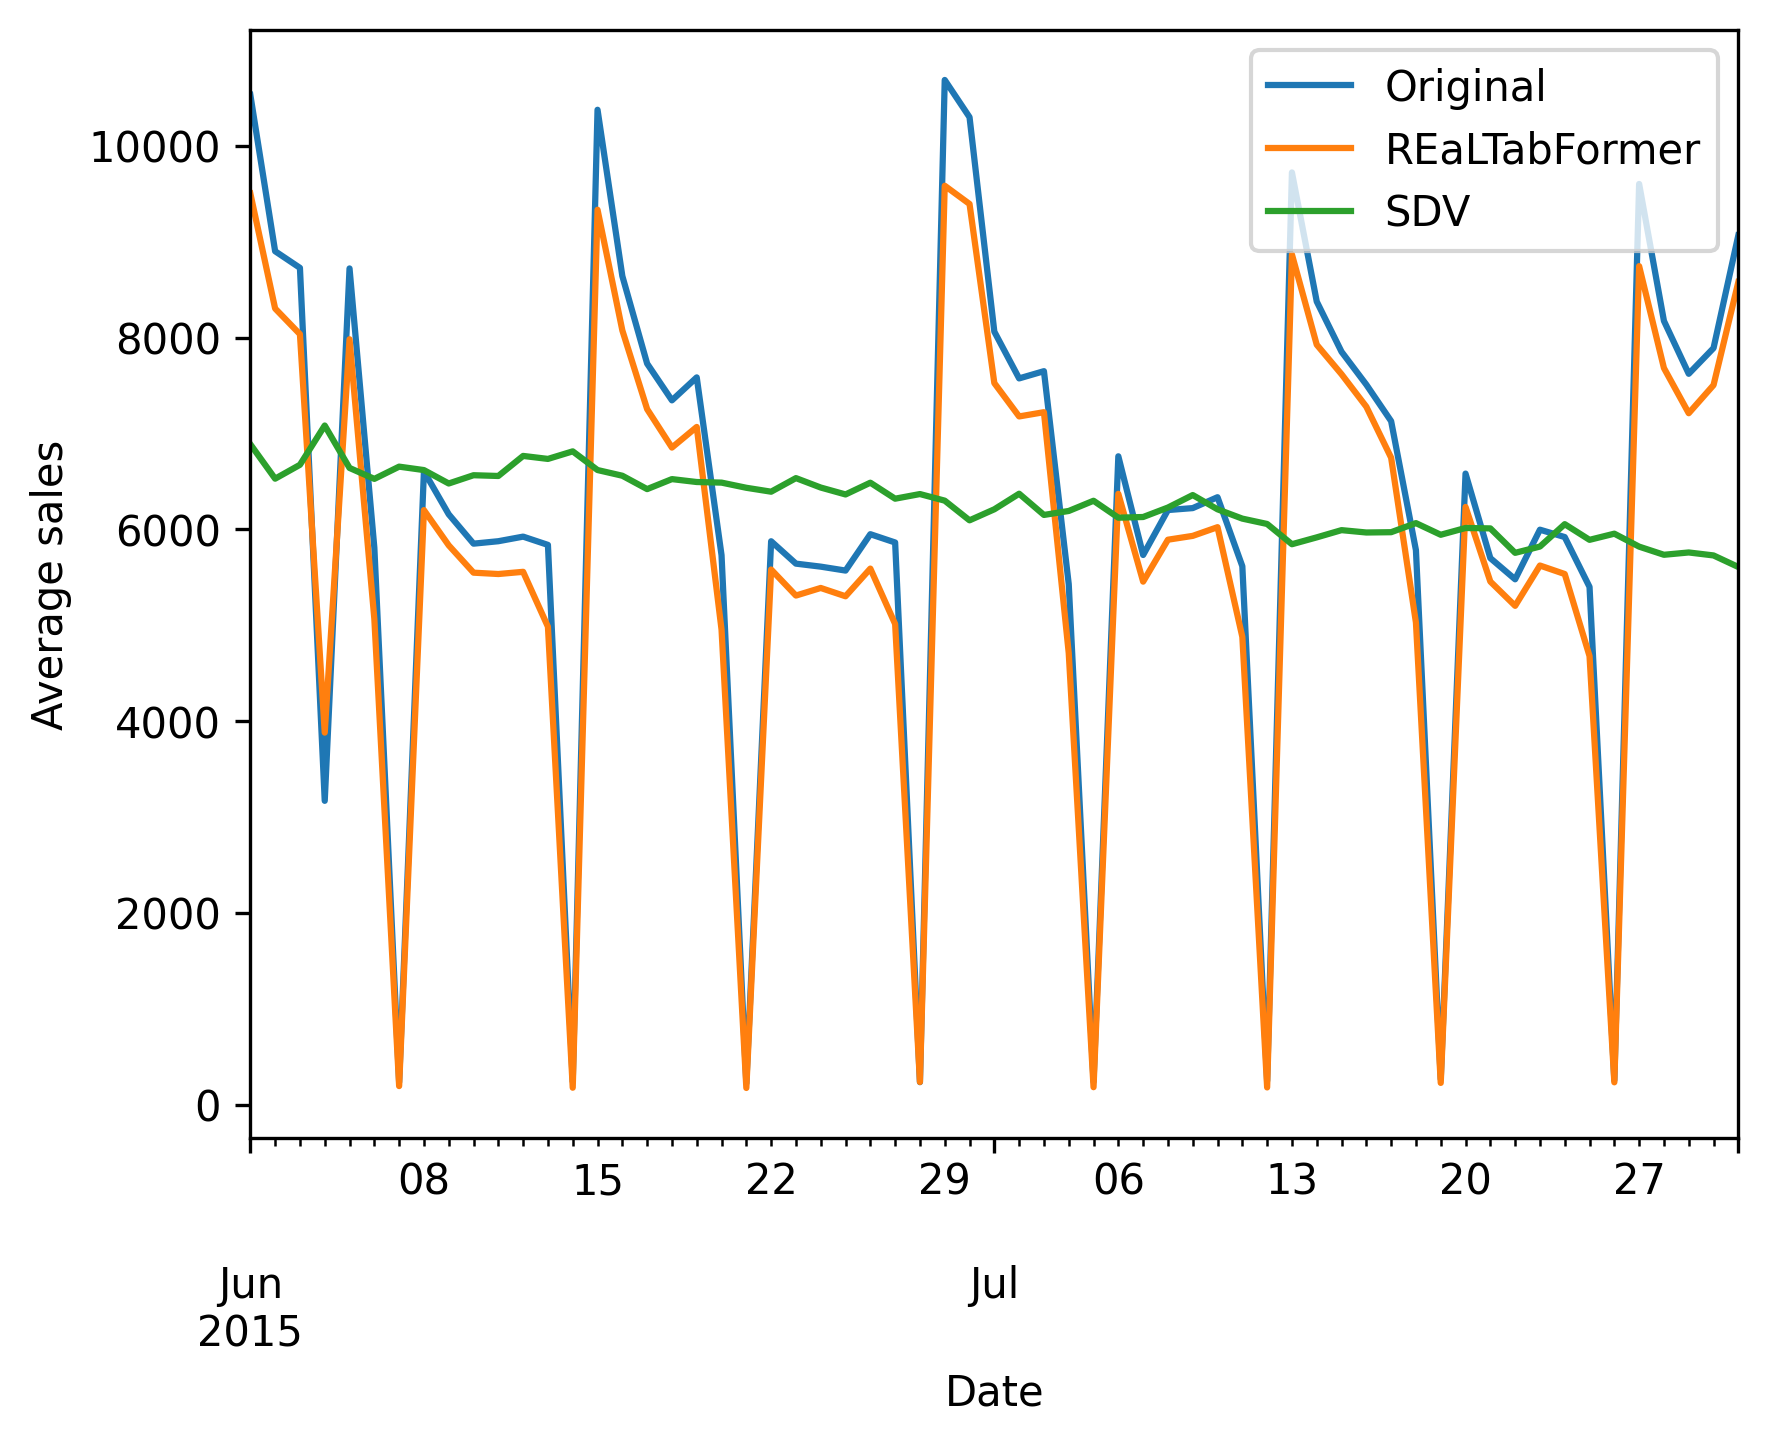

In [48]:
comp = pd.DataFrame()

comp["Original"] = tables["child"].groupby("Date")["Sales"].mean()
comp["REaLTabFormer"] = rtf_tables["child"].groupby("Date")["Sales"].mean()
comp["SDV"] = sdv_tables["child"].groupby("Date")["Sales"].mean()

comp = comp.sort_index()
comp.index = pd.to_datetime(comp.index)

fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)
ax.set_ylabel("Average sales")

plt.savefig("imgs/rossmann/Date_Sales.pdf", dpi=600, bbox_inches="tight")

In [74]:
sst_comp_df = [
    tables["child"].merge(tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index(),
    rtf_tables["child"].merge(rtf_tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index(),
    sdv_tables["child"].merge(sdv_tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index()
]

sst_comp_df[0]["Data"] = "Original"
sst_comp_df[1]["Data"] = "REaLTabFormer"
sst_comp_df[2]["Data"] = "SDV"

sst_comp_df = pd.concat(sst_comp_df)
sst_comp_df

StoreType         Sales           Data
0         a   6079.392816       Original
1         b  10975.856316       Original
2         c   6039.339167       Original
3         d   6149.114801       Original
0         a   5675.621418  REaLTabFormer
1         b  11411.783763  REaLTabFormer
2         c   5948.929355  REaLTabFormer
3         d   5513.396780  REaLTabFormer
0         a   6274.505937            SDV
1         b   6419.031669            SDV
2         c   6098.572759            SDV
3         d   6341.124026            SDV

In [80]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

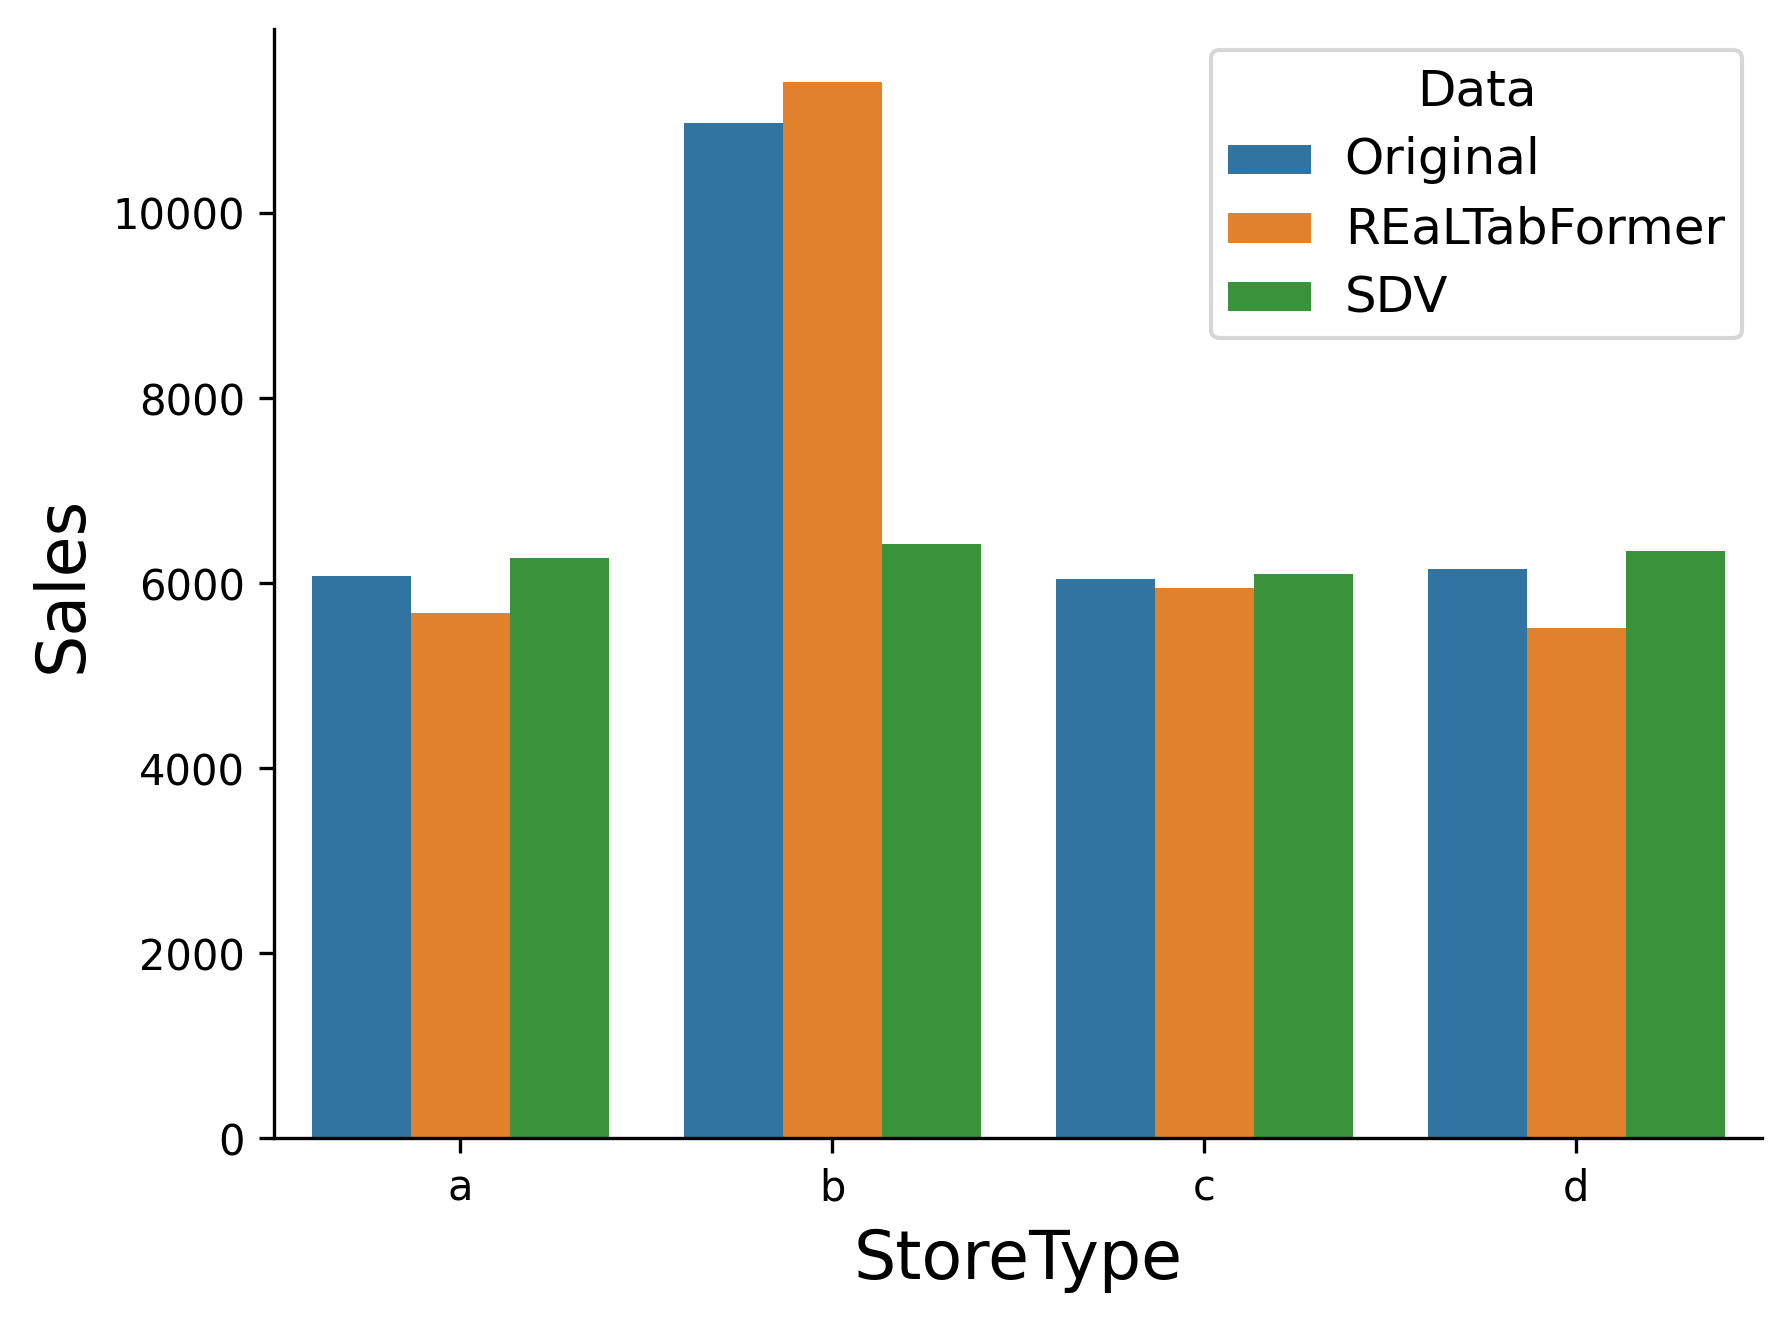

In [89]:
fig = plt.figure(dpi=300)
ax = fig.gca()
ax = sns.barplot(data=sst_comp_df, x="StoreType", y="Sales", hue="Data", ax=ax)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # , fontweight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # , fontweight="bold")


plt.setp(ax.get_legend().get_texts(), fontsize=12)
plt.setp(ax.get_legend().get_title(), fontsize=12)

plt.savefig("imgs/rossmann/StoreType_Sales.pdf", dpi=600, bbox_inches="tight")

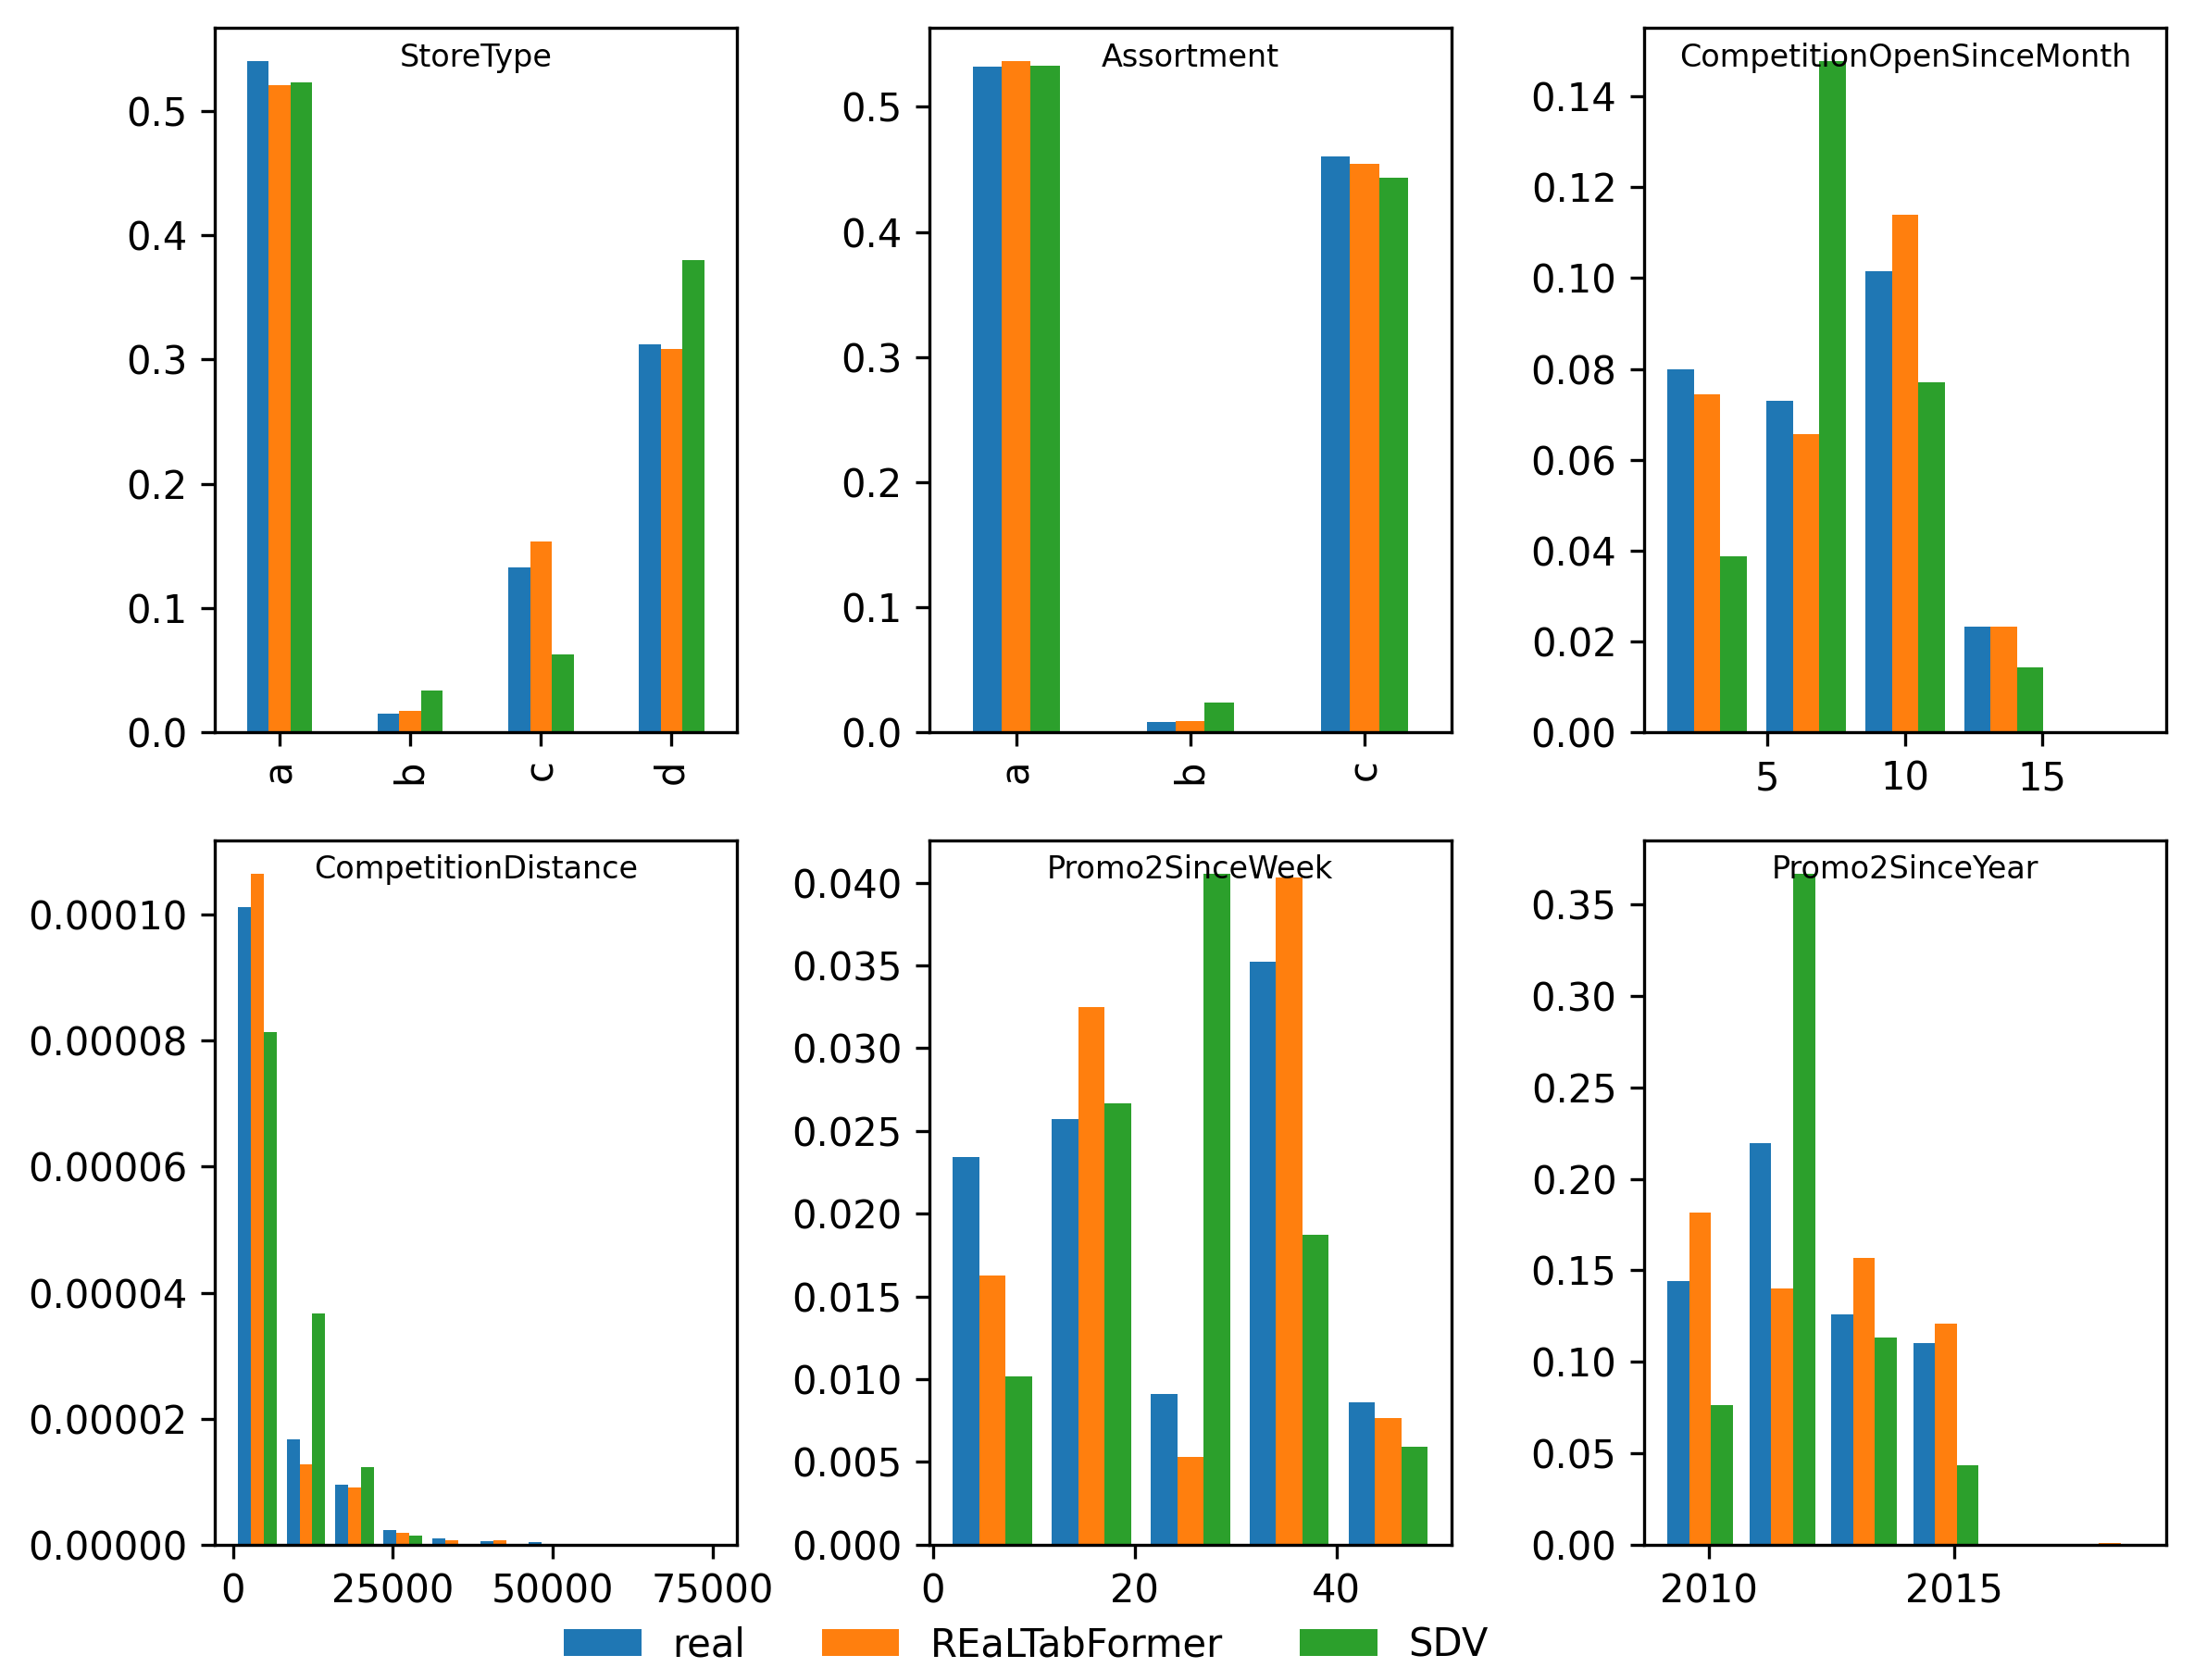

In [37]:
figure = plt.figure(figsize=(8, 6), dpi=300)
#########################################################
col = "StoreType"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = rtf_parent_df[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_parent_df[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(231)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Assortment"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = rtf_parent_df[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_parent_df[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(232)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(233)
col = "CompetitionOpenSinceMonth"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(234)

col = "CompetitionDistance"
# bins = np.linspace(in_df[col].min(), in_df[col].max(), 20)
# in_df[col].hist(bins=bins, density=True, label="real", ax=ax)
# parent_samples[col].hist(bins=bins, density=True, alpha=0.5, label="REaLTabFormer", ax=ax)
# sdv_store_samps[col].hist(bins=bins, density=True, alpha=0.5, label="SDV", ax=ax)
# ax.set_title(col)

comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 10
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceWeek"
ax = plt.subplot(235)
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceYear"
ax = plt.subplot(236)
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 6
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar', label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################


handles, labels = ax.get_legend_handles_labels()
# figure.legend(handles, labels, loc='lower center', ncol=5)
figure.legend(handles, labels, loc = (0.25, 0), ncol=5, frameon=False)


plt.tight_layout()

In [38]:
comp = pd.DataFrame()

comp["real"] = raw_child_df.groupby("Date")["Sales"].mean()
comp["REaLTabFormer"] = rtf_child_df.groupby("Date")["Sales"].mean()
comp["SDV"] = sdv_child_df.groupby("Date")["Sales"].mean()

comp = comp.sort_index()
comp.index = pd.to_datetime(comp.index)

fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

real  REaLTabFormer          SDV
Date                                                
2015-06-01  10532.390135    7551.987429  6157.805627
2015-06-02   8901.518386    6879.122588  6465.577830
2015-06-03   8728.063677    6753.375750  6358.341004
2015-06-04   3169.713901    4267.004762  6356.709877
2015-06-05   8721.877130    6856.197964  6365.286486
...                  ...            ...          ...
2015-07-27   9602.952466    7219.103103  6123.384913
2015-07-28   8174.953363    7045.350453  6140.579399
2015-07-29   7623.284305    6796.030039  6087.347319
2015-07-30   7891.348879    7434.335271  6313.708447
2015-07-31   9067.033184    8511.485375  6103.220630

[61 rows x 3 columns]

<AxesSubplot: xlabel='Date'>

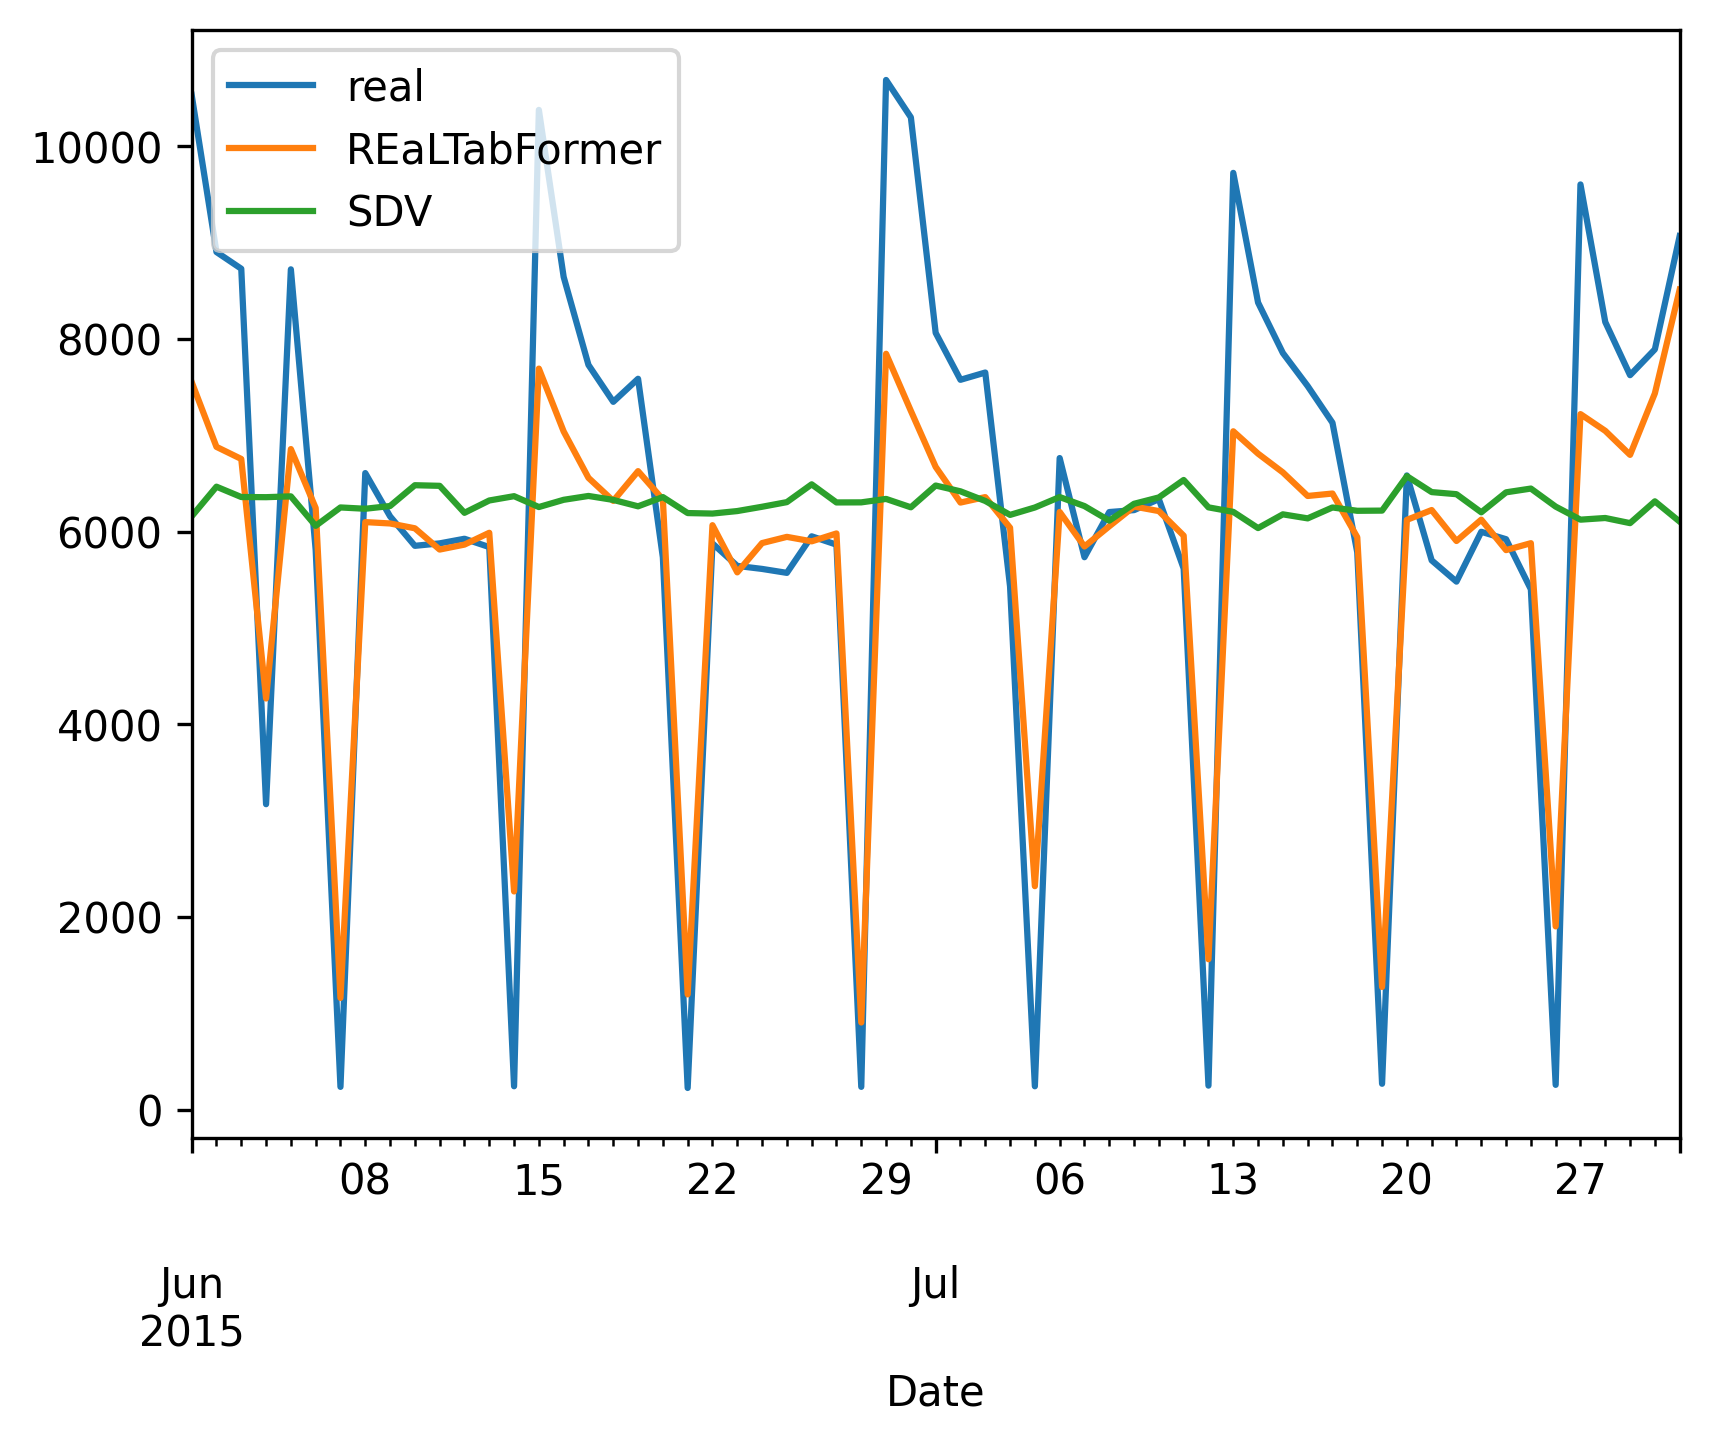

In [39]:
fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

<AxesSubplot: xlabel='Date'>

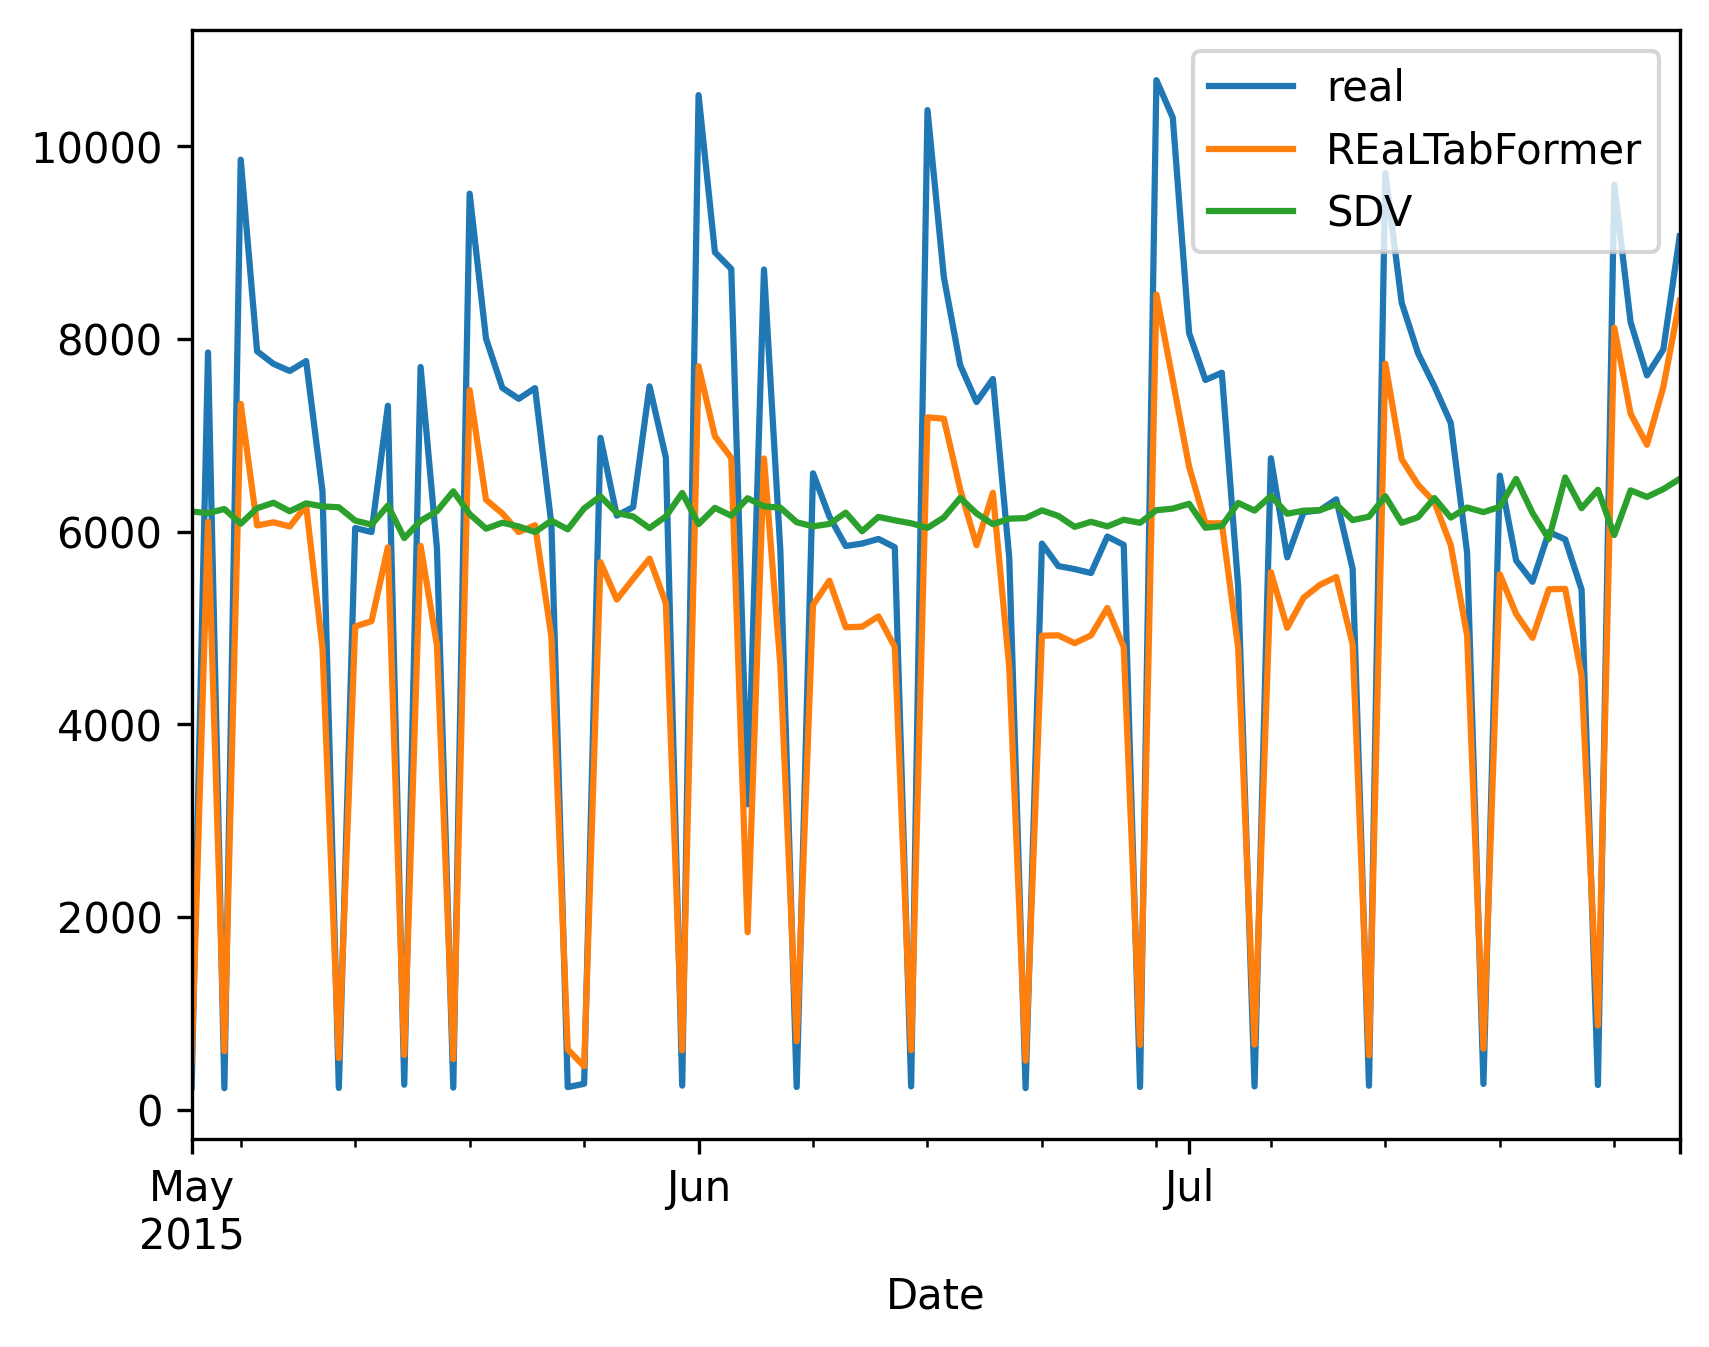

In [56]:
fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

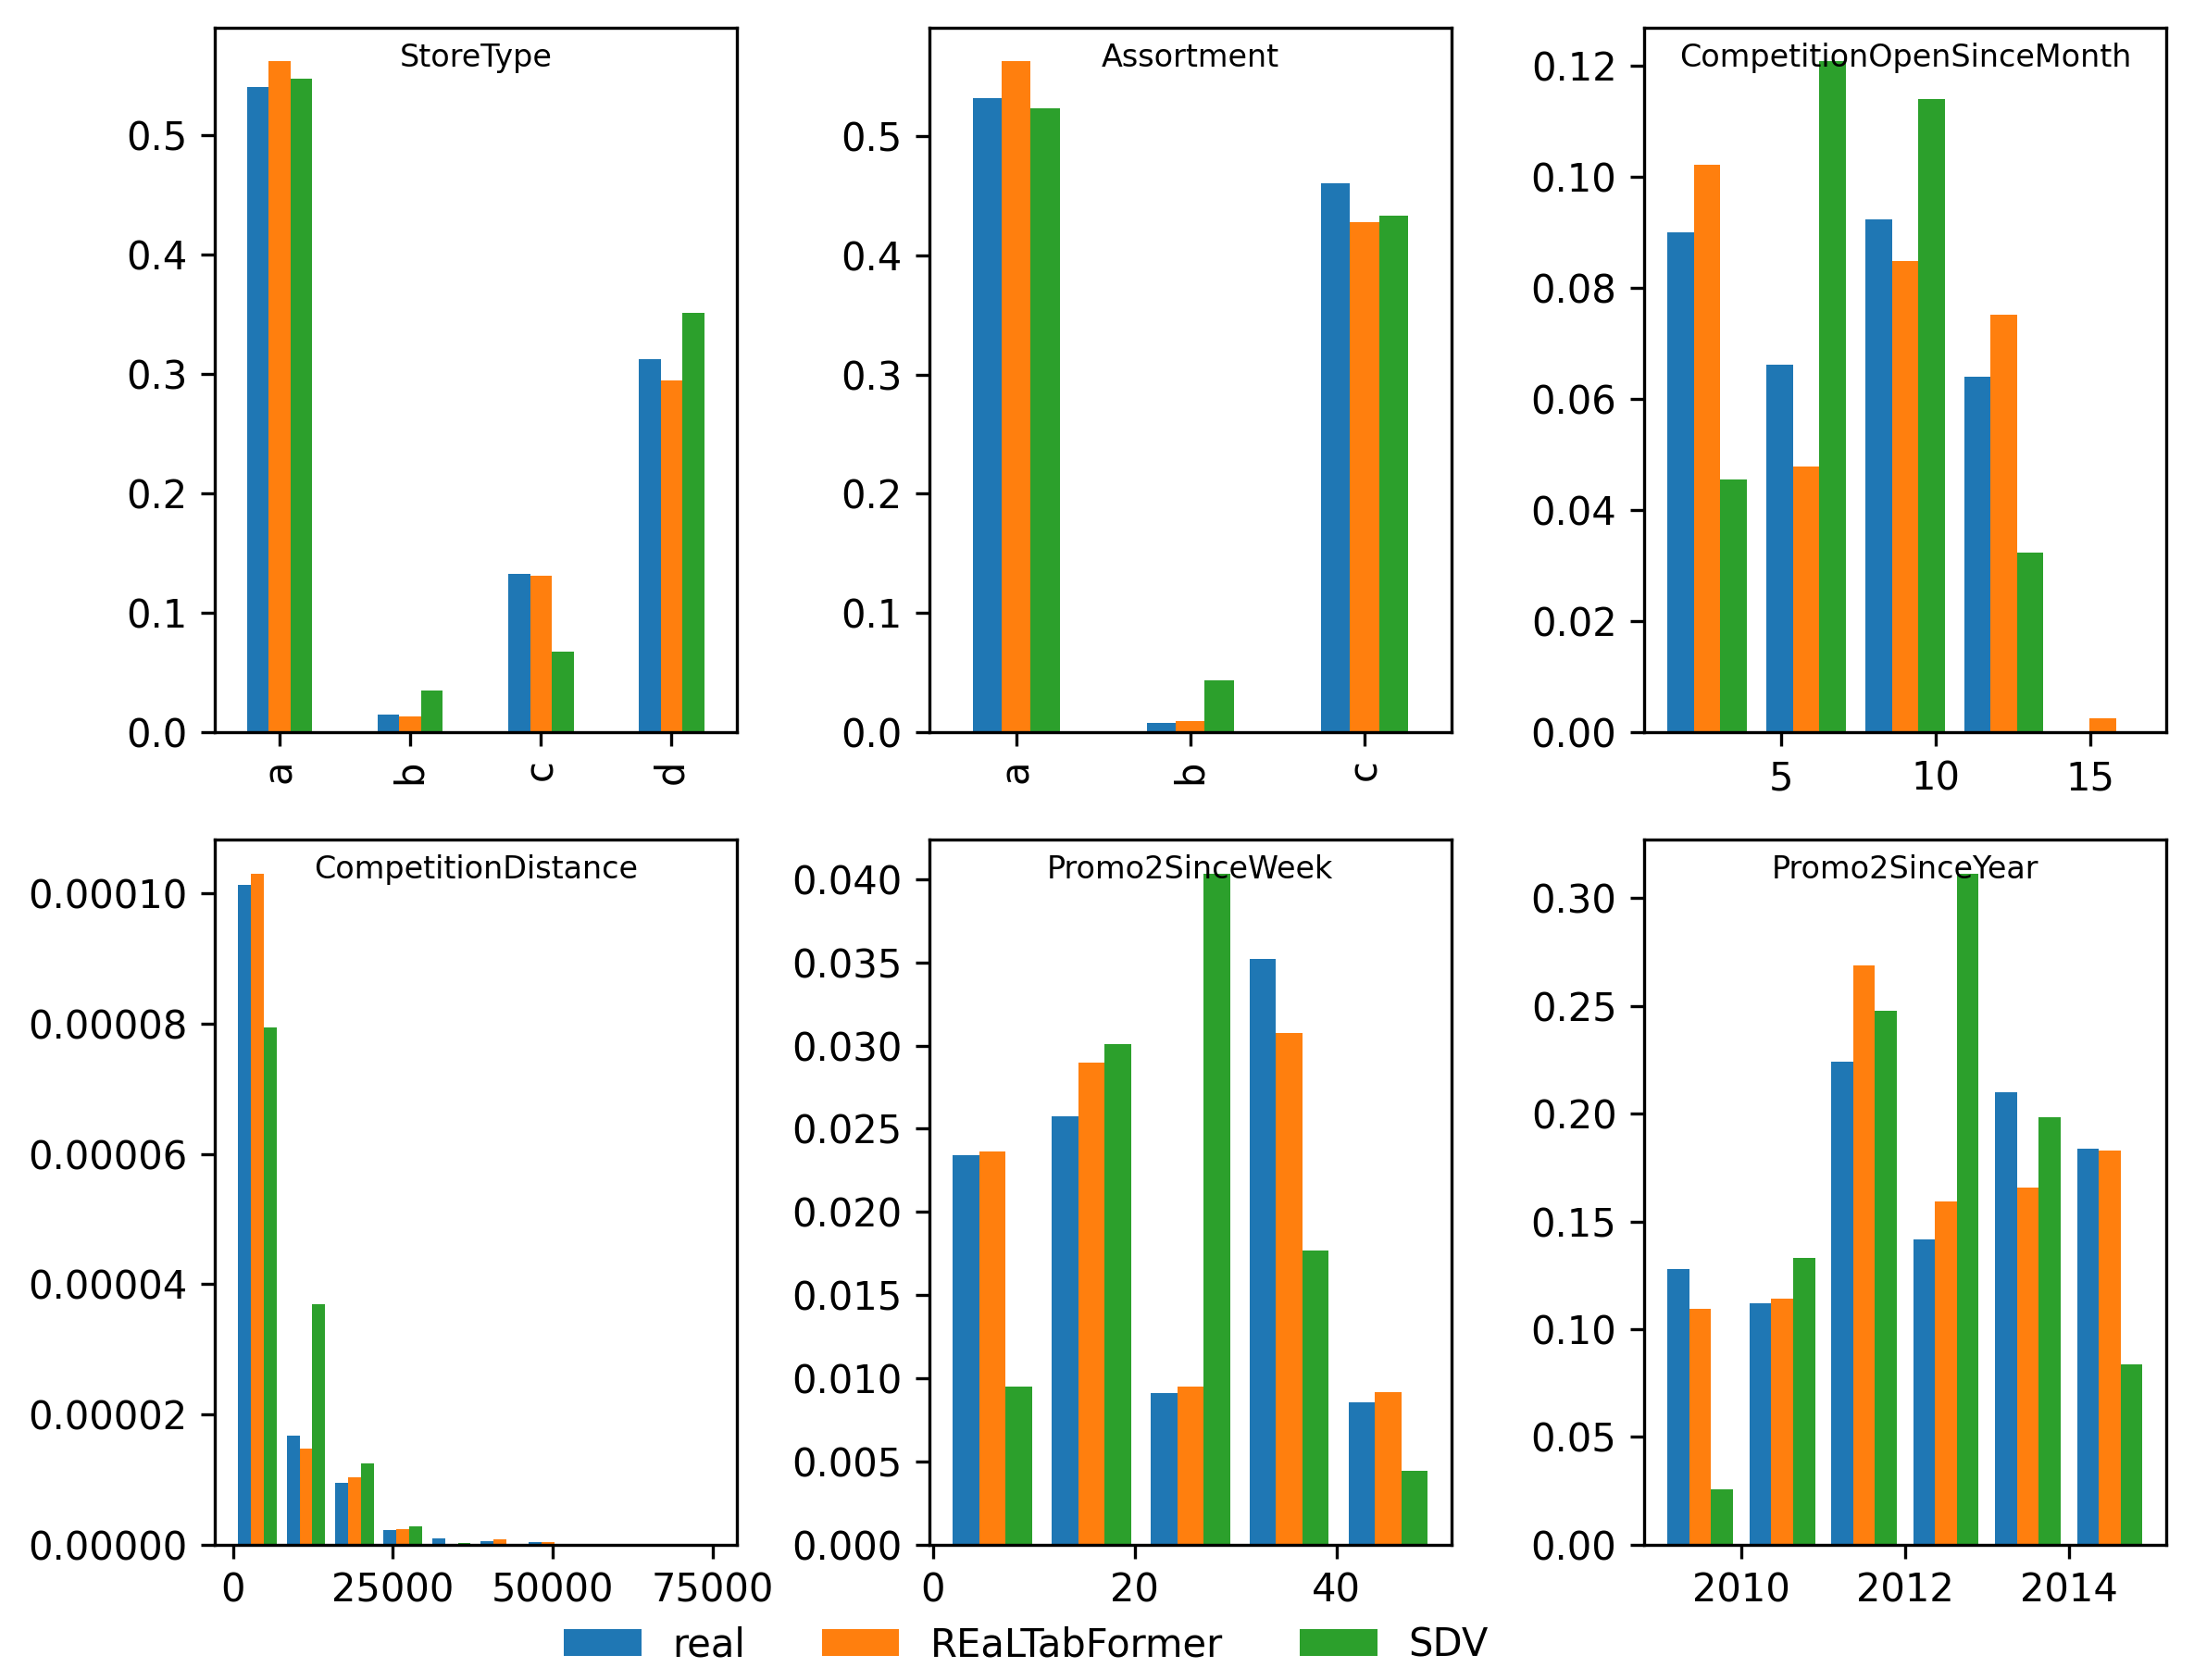

In [ ]:
figure = plt.figure(figsize=(8, 6), dpi=300)
#########################################################
col = "StoreType"
comp = pd.DataFrame()

comp["real"] = in_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = parent_samples[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_store_samps[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(231)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Assortment"
comp = pd.DataFrame()

comp["real"] = in_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = parent_samples[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_store_samps[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(232)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(233)
col = "CompetitionOpenSinceMonth"
comp = pd.DataFrame()

comp["real"] = in_df[col].values
comp["REaLTabFormer"] = parent_samples[col].values
comp["SDV"] = sdv_store_samps[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(234)

col = "CompetitionDistance"
# bins = np.linspace(in_df[col].min(), in_df[col].max(), 20)
# in_df[col].hist(bins=bins, density=True, label="real", ax=ax)
# parent_samples[col].hist(bins=bins, density=True, alpha=0.5, label="REaLTabFormer", ax=ax)
# sdv_store_samps[col].hist(bins=bins, density=True, alpha=0.5, label="SDV", ax=ax)
# ax.set_title(col)

comp = pd.DataFrame()

comp["real"] = in_df[col].values
comp["REaLTabFormer"] = parent_samples[col].values
comp["SDV"] = sdv_store_samps[col].values

n_bins = 10
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceWeek"
ax = plt.subplot(235)
comp = pd.DataFrame()

comp["real"] = in_df[col].values
comp["REaLTabFormer"] = parent_samples[col].values
comp["SDV"] = sdv_store_samps[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceYear"
ax = plt.subplot(236)
comp = pd.DataFrame()

comp["real"] = in_df[col].values
comp["REaLTabFormer"] = parent_samples[col].values
comp["SDV"] = sdv_store_samps[col].values

n_bins = 6
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar', label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################


handles, labels = ax.get_legend_handles_labels()
# figure.legend(handles, labels, loc='lower center', ncol=5)
figure.legend(handles, labels, loc = (0.25, 0), ncol=5, frameon=False)


plt.tight_layout()

In [31]:
sdv_train_samps["Date"] = pd.to_datetime(sdv_train_samps["Date"])

In [32]:
comp = pd.DataFrame()

comp["real"] = out_df.groupby("Date")["Sales"].mean()
comp["REaLTabFormer"] = child_samples.groupby("Date")["Sales"].mean()
comp["SDV"] = sdv_train_samps.groupby("Date")["Sales"].mean()

comp = comp.sort_index()
comp.index = pd.to_datetime(comp.index)
comp

real  REaLTabFormer          SDV
Date                                                
2015-06-01  10532.390135   10288.889593  5694.485955
2015-06-02   8901.518386    8925.696670  6386.450839
2015-06-03   8728.063677    8823.287783  6280.596603
2015-06-04   3169.713901    3552.735081  6360.476895
2015-06-05   8721.877130    8764.464318  6515.575238
...                  ...            ...          ...
2015-07-27   9602.952466    9633.114209  5997.191919
2015-07-28   8174.953363    8544.362084  6538.782805
2015-07-29   7623.284305    7913.587759  6430.284424
2015-07-30   7891.348879    8170.496409  6133.654795
2015-07-31   9067.033184    8978.707734  6380.231844

[61 rows x 3 columns]

<AxesSubplot: xlabel='Date'>

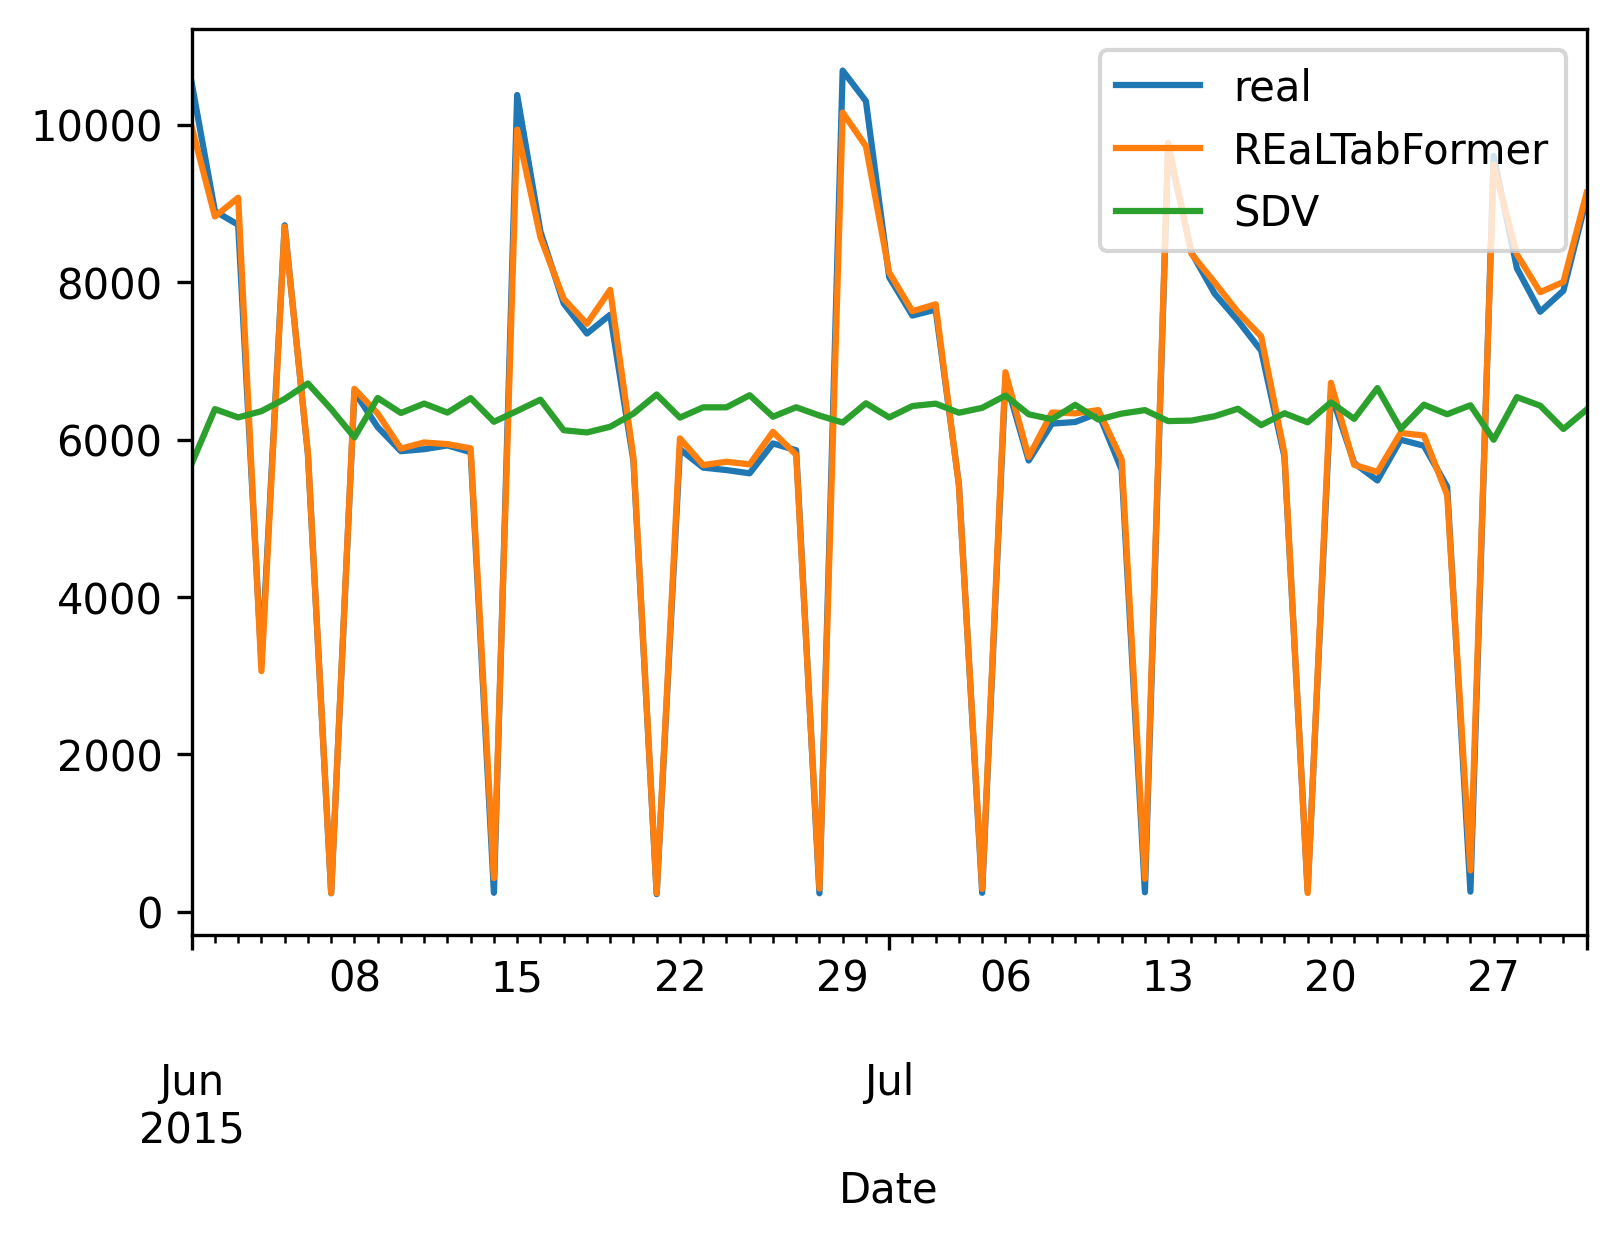

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

In [24]:
sdv_train_samps["Date"] = pd.to_datetime(sdv_train_samps["Date"])

In [25]:
comp = pd.DataFrame()

comp["real"] = out_df.groupby("Date")["Sales"].mean()
comp["REaLTabFormer"] = child_samples.groupby("Date")["Sales"].mean()
comp["SDV"] = sdv_train_samps.groupby("Date")["Sales"].mean()

comp = comp.sort_index()
comp.index = pd.to_datetime(comp.index)
comp

real  REaLTabFormer          SDV
Date                                                
2015-06-01  10532.390135    8647.490532  5694.485955
2015-06-02   8901.518386    7479.995483  6386.450839
2015-06-03   8728.063677    7450.853153  6280.596603
2015-06-04   3169.713901    2115.480543  6360.476895
2015-06-05   8721.877130    7507.636610  6515.575238
...                  ...            ...          ...
2015-07-27   9602.952466    9039.476190  5997.191919
2015-07-28   8174.953363    7812.869487  6538.782805
2015-07-29   7623.284305    7289.262354  6430.284424
2015-07-30   7891.348879    7670.147615  6133.654795
2015-07-31   9067.033184    8895.690305  6380.231844

[61 rows x 3 columns]

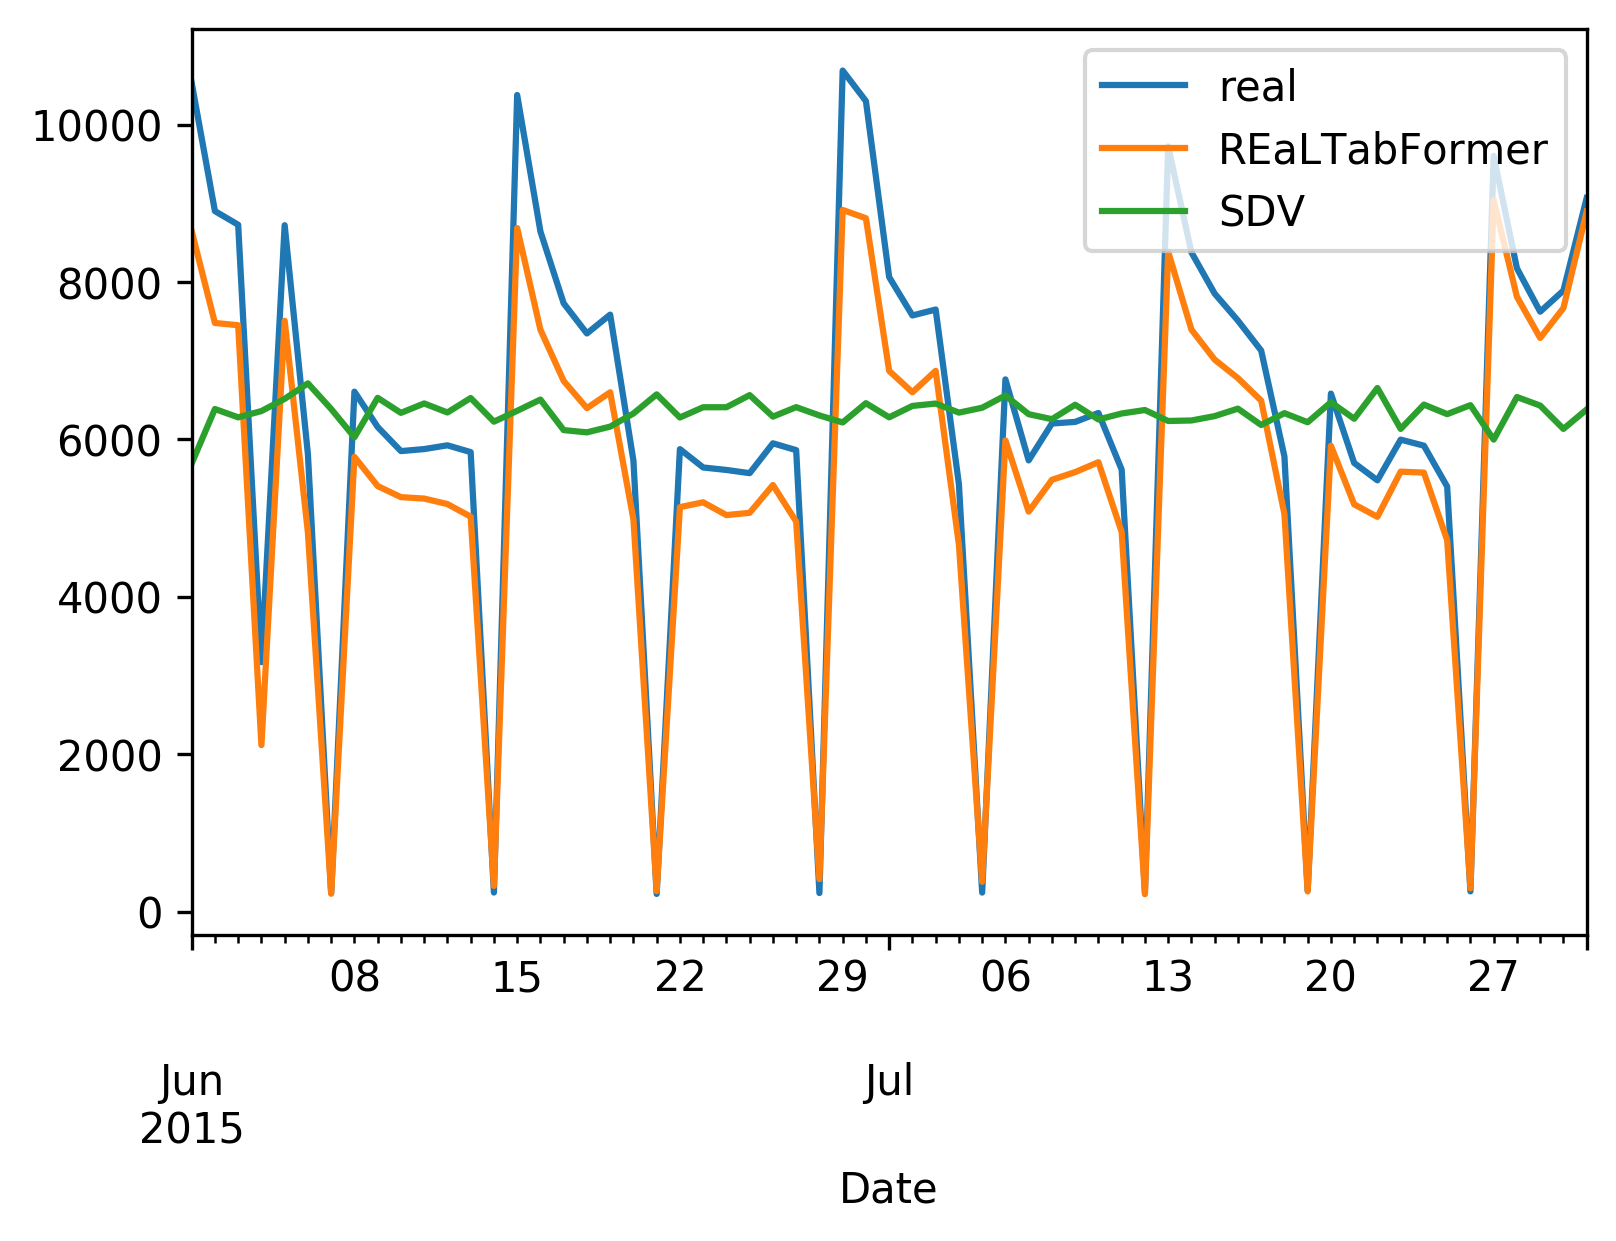

In [26]:
fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

In [28]:
child_samples["Date"]

0       2015-07-31
1       2015-07-30
2       2015-07-29
3       2015-07-28
4       2015-07-27
           ...    
67887   2015-06-05
67888   2015-06-04
67889   2015-06-03
67890   2015-06-02
67891   2015-06-01
Name: Date, Length: 67892, dtype: datetime64[ns]

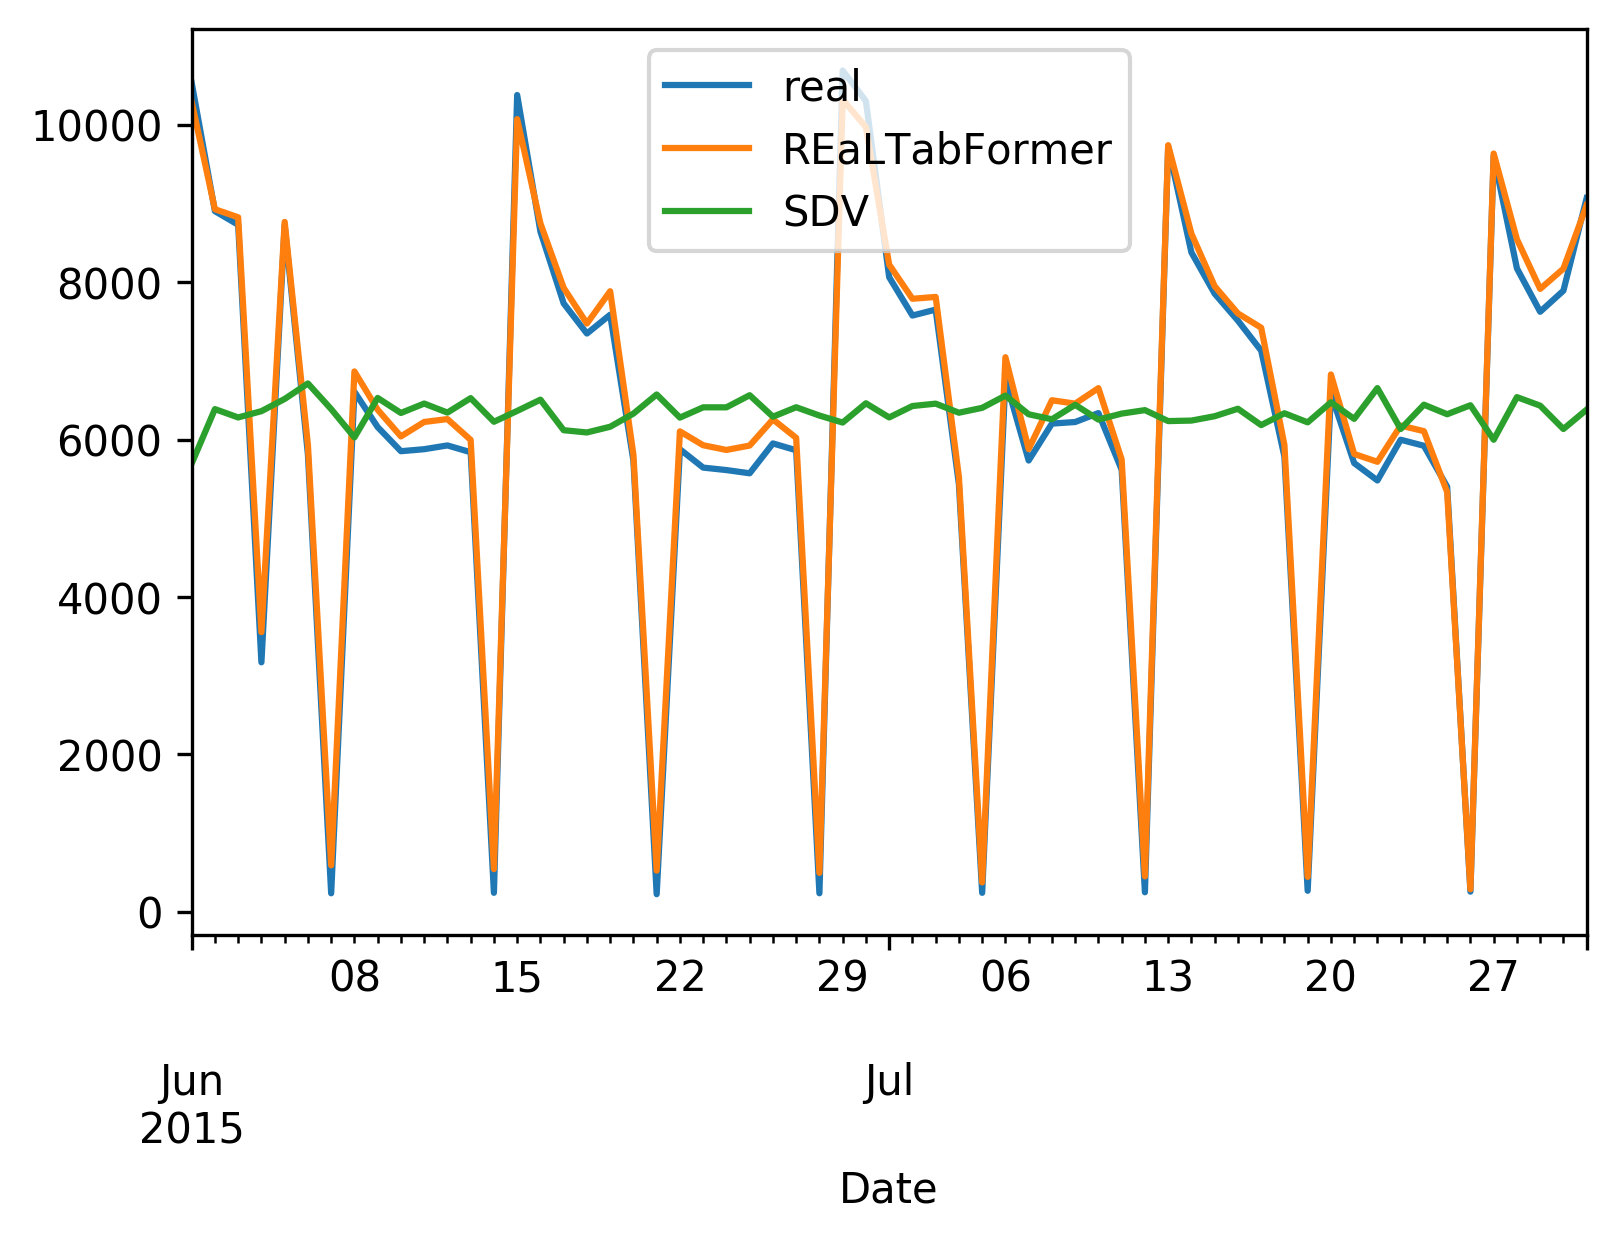

In [33]:
fig = plt.figure(dpi=300)
ax = fig.gca()
comp.plot(ax=ax)

# Airbnb Dataset

In [171]:
RELATIONAL_DATA_PATH = Path("/content/REaLTabFormer-Experiments/data/relational")
RELATIONAL_EXP_PATH = Path("/content/REaLTabFormer-Experiments/exp-relational")
AIRBNB_DATA = RELATIONAL_DATA_PATH / "airbnb"
AIRBNB_EXP = RELATIONAL_EXP_PATH / "airbnb"

In [172]:
# a_users = pd.read_csv("train_users_2.csv.zip")
# a_sessions = pd.read_csv("sessions.csv.zip")

In [173]:
a_users = pd.read_csv(AIRBNB_DATA / "train_users_2.csv.zip")
a_sessions = pd.read_csv(AIRBNB_DATA / "sessions.csv.zip")

print(a_users.shape, a_sessions.shape)

(213451, 16) (10567737, 6)


In [174]:
session_users = a_sessions["user_id"].value_counts()
session_users.describe()

count    135483.000000
mean         77.745850
std         112.563746
min           1.000000
25%          16.000000
50%          41.000000
75%          95.000000
max        2722.000000
Name: user_id, dtype: float64

In [175]:
users_ids = session_users[session_users.between(2, 15)]
users_ids.shape

(32058,)

In [176]:
# Create a sample of the data for now

# air_in_df = a_users.sample(n=10000, replace=False, random_state=1029)
air_in_df = a_users[a_users["id"].isin(users_ids.index)].copy()
air_in_df.rename(columns={"id": "user_id"}, inplace=True)

air_in_df = air_in_df.sample(n=1000, replace=False, random_state=1029)

# Change to correct date type
air_in_df["date_account_created"] = pd.to_datetime(air_in_df["date_account_created"])
air_in_df["date_first_booking"] = pd.to_datetime(air_in_df["date_first_booking"])

air_out_df = a_sessions[a_sessions["user_id"].isin(air_in_df["user_id"].tolist())]

join_on = "user_id"

len(air_in_df), len(air_out_df)

(1000, 7565)

In [177]:
user_sessions = air_out_df[join_on].value_counts()
user_sessions.name = "n_sessions"
user_sessions = user_sessions.reset_index().rename(columns={"index": join_on})

air_in_df = air_in_df.merge(user_sessions, on=join_on)

lead_cols = ["user_id", "n_sessions"]
last_cols = ["date_account_created", "timestamp_first_active", "date_first_booking"]
mid_cols = [i for i in air_in_df.columns if (i not in lead_cols and i not in last_cols)]
cols = lead_cols + list(mid_cols) # + last_cols
air_in_df = air_in_df[cols]

air_in_df.head()

user_id  n_sessions     gender   age signup_method  signup_flow  \
0  4nyrn3dew4          14       MALE  25.0         basic           25   
1  mjgopklvuq           7     FEMALE  50.0      facebook            0   
2  8lrp4vn601           5  -unknown-   NaN         basic            0   
3  26xz1gkd0a           3  -unknown-  38.0         basic           25   
4  eoscajdw7j           4     FEMALE  28.0      facebook           12   

  language affiliate_channel affiliate_provider first_affiliate_tracked  \
0       en            direct             direct               untracked   
1       en            direct             direct                  linked   
2       en            direct             direct                  linked   
3       en            direct             direct               untracked   
4       en               api              other               untracked   

  signup_app first_device_type  first_browser country_destination  
0        iOS            iPhone      -unknown-               other  
1        Web   Windows Desktop         Chrome                 NDF  
2        Web       Mac Desktop         Chrome                 NDF  
3        iOS            iPhone  Mobile Safari                  US  
4        iOS   Windows Desktop        Firefox                 NDF

In [178]:
# for col, dtype in air_out_df.dtypes.items():
#     if dtype == "object":
#         print(col, air_out_df[col].nunique())

### REaLTabFormer parent table model

In [16]:
parent_rtf = REaLTabFormer(
    "tabular",
    checkpoints_dir=AIRBNB_EXP / "parent_rtf_checkpoints",
    epochs=100,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=32,
    mask_rate=0.1,
    gradient_accumulation_steps=4,
    early_stopping_patience=0,
    save_total_limit=1,
)

In [17]:
parent_rtf.fit(
    df=air_in_df.drop(join_on, axis=1),
    num_bootstrap=500,
    frac=0.165,
    n_critic=5,
    gen_rounds=3,
    sensitivity_max_col_nums=20,
    full_sensitivity=False,
    sensitivity_orig_frac_multiple=4,
)

Computing the sensitivity threshold...


/content/realtabformer/realtabformer.py:514: UserWarning: The qt_max (0.05) set is lower than the duplicate rate (0.094) in the data. This will not give a reliable early stopping condition. Consider using qt_max="compute" argument.
  warnings.warn(
/content/realtabformer/realtabformer.py:548: UserWarning: qt_interval adjusted from 100 to 8...
  warnings.warn(f"qt_interval adjusted from {qt_interval} to {_qt_interval}...")


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.007366
std        0.030444
min       -0.025000
25%       -0.022576
50%       -0.002045
75%        0.033636
max        0.121970
dtype: float64
Sensitivity threshold: 0.05303787878787877 qt_max: 0.05


  0%|          | 0/1000 [00:00<?, ?ex/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 40
  Number of trainable parameters = 43421184


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-8
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-8/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-8/pytorch_model.bin
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-16
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-16/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-16/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-8] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the

Critic round: 5, sensitivity_threshold: 0.05303787878787877, val_sensitivity: -0.01596969696969697, val_sensitivities: [-0.016212121212121212, -0.016515151515151517, -0.015454545454545455, -0.02075757575757576, -0.02075757575757576, -0.020151515151515153, 0.02696969696969697, -0.022272727272727274, -0.02, -0.020151515151515153, -0.015151515151515152, -0.020151515151515153, -0.016212121212121212, -0.022575757575757575, -0.020151515151515153]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 80
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 40
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-48
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-48/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-48/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-40] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-56
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-56/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-56/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/ai

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the

Critic round: 10, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.01431313131313131, val_sensitivities: [0.03893939393939393, 0.04318181818181818, 0.03939393939393939, 0.04575757575757576, 0.03681818181818181, -0.022575757575757575, 0.027121212121212122, -0.022272727272727274, -0.011666666666666669, -0.025, 0.033939393939393936, -0.022575757575757575, 0.04, -0.018333333333333337, 0.03196969696969697]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 120
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 80
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-88
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-88/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-88/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-80] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-96
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-96/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-96/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/ai

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 512 samples generated. Sampling efficiency is: 99.8047%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-120.


Critic round: 15, sensitivity_threshold: 0.05303787878787877, val_sensitivity: -0.010333333333333335, val_sensitivities: [-0.018333333333333337, -0.0077272727272727285, 0.038636363636363635, -0.018333333333333337, -0.013787878787878788, -0.020151515151515153, 0.02803030303030303, -0.01681818181818182, 0.005909090909090908, -0.022575757575757575, -0.02106060606060606, -0.022575757575757575, -0.018636363636363642, -0.022575757575757575, -0.025]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 160
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 15
  Continuing training from global step 120
  Will skip the first 15 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-128
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-128/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-128/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-120] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-136
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-136/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-136/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-160.


Critic round: 20, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.014454545454545453, val_sensitivities: [-0.017272727272727273, 0.059242424242424235, 0.05257575757575757, 0.05136363636363637, -0.02075757575757576, -0.025, 0.048939393939393935, -0.021969696969696972, -0.021969696969696972, -0.020151515151515153, 0.05454545454545455, -0.025, 0.06015151515151515, -0.025, 0.06712121212121211]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 200
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 20
  Continuing training from global step 160
  Will skip the first 20 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-168
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-168/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-168/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-160] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-176
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-176/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-176/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-200.


Critic round: 25, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.035181818181818175, val_sensitivities: [0.05666666666666667, 0.06121212121212122, 0.07257575757575757, 0.05757575757575757, 0.0556060606060606, -0.022575757575757575, 0.029090909090909084, -0.020151515151515153, -0.020151515151515153, -0.022575757575757575, 0.06136363636363637, 0.05378787878787878, 0.0556060606060606, 0.045, 0.0646969696969697]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 30
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 240
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 25
  Continuing training from global step 200
  Will skip the first 25 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-208
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-208/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-208/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-200] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-216
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-216/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-216/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-240.


Critic round: 30, sensitivity_threshold: 0.05303787878787877, val_sensitivity: -0.004702731195449644, val_sensitivities: [-0.011666666666666669, -0.009545454545454546, 0.07, -0.01590909090909091, -0.018636363636363642, -0.01893939393939394, 0.028701456310679607, -0.022272727272727274, -0.01863636363636364, -0.021363636363636366, -0.020151515151515153, -0.020151515151515153, 0.0396969696969697, -0.015151515151515152, -0.016515151515151517]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 35
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 280
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 30
  Continuing training from global step 240
  Will skip the first 30 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-248
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-248/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-248/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-240] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-256
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-256/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-256/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-280.


Critic round: 35, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.021727272727272724, val_sensitivities: [-0.012121212121212121, 0.04, 0.0393939393939394, 0.04015151515151515, -0.014545454545454545, -0.022575757575757575, 0.0556060606060606, 0.058333333333333334, 0.056363636363636366, 0.056212121212121206, 0.029242424242424236, -0.022575757575757575, 0.026212121212121207, 0.018787878787878784, -0.022575757575757575]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 40
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 320
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 35
  Continuing training from global step 280
  Will skip the first 35 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-288
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-288/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-288/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-280] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-296
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-296/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-296/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-320.


Critic round: 40, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.02787878787878788, val_sensitivities: [-0.022575757575757575, 0.042727272727272725, 0.04469696969696969, 0.045909090909090906, -0.022878787878787877, -0.01893939393939394, 0.09666666666666668, -0.0006060606060606067, 0.08590909090909091, 0.08772727272727274, -0.020151515151515153, -0.01772727272727273, 0.07787878787878788, -0.020151515151515153, 0.05969696969696969]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 45
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 360
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 40
  Continuing training from global step 320
  Will skip the first 40 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-328
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-328/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-328/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-320] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-336
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-336/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-336/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-360.


Critic round: 45, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.033464646464646454, val_sensitivities: [0.0456060606060606, 0.04378787878787878, 0.08515151515151516, 0.05818181818181818, 0.057272727272727274, -0.01772727272727273, 0.05893939393939394, -0.014393939393939395, -0.008030303030303032, -0.012878787878787878, 0.05378787878787879, -0.025, 0.06166666666666666, 0.04848484848484848, 0.06712121212121211]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 45
  Continuing training from global step 360
  Will skip the first 45 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-368
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-368/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-368/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-360] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-376
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-376/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-376/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 512 samples generated. Sampling efficiency is: 99.8047%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-400.


Critic round: 50, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.03688888888888889, val_sensitivities: [0.038636363636363635, 0.05499999999999999, 0.06575757575757575, 0.05499999999999999, 0.04772727272727273, -0.022575757575757575, 0.07454545454545455, -0.00575757575757576, 0.07515151515151515, 0.07439393939393939, 0.0353030303030303, -0.01772727272727273, 0.04060606060606061, -0.01772727272727273, 0.055]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 55
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 440
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 50
  Continuing training from global step 400
  Will skip the first 50 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-408
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-408/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-408/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-400] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-416
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-416/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-416/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/config.json


Saving not-best model...


Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-440.


Critic round: 55, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.05307070707070707, val_sensitivities: [-0.001969696969696972, 0.1046969696969697, 0.09333333333333335, 0.09090909090909091, 0.0028787878787878765, -0.015303030303030304, 0.046515151515151516, -0.009545454545454548, -0.007878787878787881, -0.012878787878787878, 0.10681818181818181, 0.09863636363636363, 0.09818181818181819, 0.09575757575757575, 0.10590909090909092]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 60
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 480
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 55
  Continuing training from global step 440
  Will skip the first 55 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-448
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-448/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-448/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-440] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-456
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-456/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-456/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-480.


Critic round: 60, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.042838383838383835, val_sensitivities: [-0.020151515151515153, 0.09939393939393938, 0.09651515151515153, 0.11, -0.013181818181818183, -0.012878787878787878, 0.06712121212121211, -0.0146969696969697, -0.012121212121212123, -0.015303030303030304, 0.10712121212121212, 0.09742424242424241, 0.08454545454545455, -0.01772727272727273, 0.08651515151515152]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 65
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 520
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 60
  Continuing training from global step 480
  Will skip the first 60 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-488
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-488/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-488/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-480] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-496
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-496/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-496/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-520.


Critic round: 65, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.026121212121212118, val_sensitivities: [0.05848484848484849, 0.08363636363636365, 0.0746969696969697, 0.07227272727272727, 0.07318181818181818, -0.011666666666666665, 0.0856060606060606, -0.013484848484848485, 0.007272727272727271, -0.00803030303030303, -0.006515151515151517, -0.000757575757575759, 0.0007575757575757572, -0.01075757575757576, -0.012878787878787878]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 70
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 560
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 65
  Continuing training from global step 520
  Will skip the first 65 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-528
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-528/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-528/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-520] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-536
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-536/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-536/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-560.


Critic round: 70, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.029200316269491027, val_sensitivities: [-0.0034848484848484847, 0.07606060606060606, 0.06787878787878787, 0.0693939393939394, -0.0034848484848484847, -0.010454545454545456, 0.0789138349514563, -0.0036363636363636372, -0.0012121212121212139, -0.0068181818181818205, 0.0506060606060606, -0.000757575757575759, 0.07106060606060607, 0.061969696969696966, -0.00803030303030303]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 75
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 600
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 70
  Continuing training from global step 560
  Will skip the first 70 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-568
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-568/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-568/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-560] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-576
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-576/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-576/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-600.


Critic round: 75, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.046626262626262634, val_sensitivities: [0.0027272727272727258, 0.09606060606060607, 0.11, 0.1012121212121212, -0.0009090909090909115, 0.0040909090909090895, 0.07212121212121211, 0.056212121212121206, 0.062424242424242424, 0.06227272727272728, 0.04833333333333333, 0.0065151515151515155, 0.07015151515151515, 0.0040909090909090895, 0.0040909090909090895]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 80
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 640
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 75
  Continuing training from global step 600
  Will skip the first 75 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-608
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-608/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-608/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-600] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-616
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-616/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-616/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-640.


Critic round: 80, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.07400203491222908, val_sensitivities: [0.10212378640776698, 0.10575757575757576, 0.12136363636363635, 0.10863636363636364, 0.10712121212121213, 0.012575757575757573, 0.12305825242718446, 0.131969696969697, 0.11848484848484847, 0.01863636363636364, 0.006818181818181819, -0.000757575757575759, 0.09075757575757576, -0.00803030303030303, 0.07151515151515152]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 85
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 680
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 80
  Continuing training from global step 640
  Will skip the first 80 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-648
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-648/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-648/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-640] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-656
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-656/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-656/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 512 samples generated. Sampling efficiency is: 99.8047%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-680.


Critic round: 85, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.043555555555555556, val_sensitivities: [-0.0043939393939393945, 0.07106060606060606, 0.1106060606060606, 0.09151515151515152, 0.08727272727272727, 0.0040909090909090895, 0.12348484848484849, 0.02015151515151515, 0.018333333333333333, 0.008939393939393941, 0.005909090909090909, -0.0031818181818181815, 0.10984848484848485, 0.008030303030303032, 0.001666666666666667]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 90
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 720
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 85
  Continuing training from global step 680
  Will skip the first 85 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-688
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-688/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-688/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-680] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-696
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-696/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-696/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-720.


Critic round: 90, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.060777777777777785, val_sensitivities: [0.08257575757575758, 0.1015151515151515, 0.13575757575757574, 0.10424242424242425, 0.09121212121212122, -0.012878787878787878, 0.07106060606060606, -0.0028787878787878782, 0.0019696969696969694, 0.0040909090909090895, 0.10181818181818181, 0.008939393939393941, 0.11454545454545456, 0.0037878787878787862, 0.10590909090909092]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 95
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 760
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 90
  Continuing training from global step 720
  Will skip the first 90 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-728
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-728/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-728/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-720] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-736
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-736/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-736/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-760.


Critic round: 95, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.04623232323232323, val_sensitivities: [0.0040909090909090895, 0.09757575757575758, 0.08484848484848485, 0.08424242424242424, -0.0031818181818181815, 0.0065151515151515155, 0.08742424242424243, 0.022424242424242423, 0.020606060606060607, 0.001666666666666667, 0.10454545454545454, 0.0077272727272727285, 0.0996969696969697, 0.07727272727272727, -0.001969696969696972]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 100
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 800
  Number of trainable parameters = 43421184
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 95
  Continuing training from global step 760
  Will skip the first 95 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-768
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-768/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-768/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-760] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-776
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-776/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-776/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/495 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 512 samples generated. Sampling efficiency is: 99.8047%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model/config.json


Critic round: 100, sensitivity_threshold: 0.05303787878787877, val_sensitivity: 0.058333333333333334, val_sensitivities: [0.07727272727272727, 0.0903030303030303, 0.12030303030303031, 0.08378787878787879, 0.09090909090909091, -0.000757575757575759, 0.09121212121212122, 0.09333333333333332, 0.09303030303030302, 0.09984848484848485, 0.012424242424242423, 0.010151515151515147, 0.000454545454545454, 0.004999999999999999, 0.0077272727272727285]


Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file /content/REaLTabFormer-Experiments/exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use

In [18]:
parent_rtf.save(AIRBNB_EXP / "rtf_parent_model")

Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model


### REaLTabFormer child table model

In [19]:
parent_realtabformer_path = sorted(
    [p for p in (AIRBNB_EXP / "rtf_parent_model").glob("id*") if p.is_dir()],
    key=os.path.getmtime)[-1]

parent_realtabformer_path

PosixPath('/content/REaLTabFormer-Experiments/exp-relational/airbnb/rtf_parent_model/id000016742448322113280000')

In [20]:
# parent_realtabformer_path = sorted(
#     [p for p in (AIRBNB_EXP / "rtf_parent_model").glob("id*") if p.is_dir()],
#     key=os.path.getmtime)[-1]

# parent_realtabformer_path

In [21]:
child_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path=parent_realtabformer_path,
    epochs=30,
    output_max_length=None,
    numeric_nparts=1,
    # mask_rate=0.05
)
child_rtf.fit(df=air_out_df, in_df=air_in_df, join_on=join_on)

child_rtf.save(AIRBNB_EXP / "rtf_child_model")

/content/realtabformer/realtabformer.py:149: UserWarning: The `output_max_length` is None. This could result to extended model training if the output length has large variations.
  warnings.warn(
/content/realtabformer/realtabformer.py:277: UserWarning: A trained model for the parent table is available. The encoder will use the pretrained config and weights.
  warnings.warn(
/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/7565 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 930
  Number of trainable parameters = 57748224
/usr/local/lib/python3.8/dist-packages/transformers/models/encod

Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoint-200/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encode

### Generate samples

In [22]:
parent_samples = parent_rtf.sample(n_samples=len(air_in_df))
parent_samples.index.name = join_on
parent_samples = parent_samples.reset_index()
parent_samples.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%


user_id  n_sessions     gender   age signup_method  signup_flow language  \
0        0           2  -unknown-  33.0         basic            0       en   
1        1           6  -unknown-   NaN         basic            0       en   
2        2           8       MALE  33.0      facebook           25       en   
3        3          11  -unknown-   NaN         basic           25       en   
4        4           2     FEMALE  23.0      facebook            0       it   

  affiliate_channel affiliate_provider first_affiliate_tracked signup_app  \
0            direct             direct                  linked        Web   
1         sem-brand             google                     omg        Web   
2            direct             direct               untracked        iOS   
3            direct             direct               untracked        iOS   
4         sem-brand             google                     omg        Web   

  first_device_type first_browser country_destination  
0       Mac Desktop        Safari               other  
1   Windows Desktop        Chrome                  US  
2   Windows Desktop            IE                 NDF  
3            iPhone     -unknown-                 NDF  
4       Mac Desktop        Safari                 NDF

In [18]:
# parent_samples["date_first_booking"] = parent_samples["date_first_booking"].replace(parent_samples["date_first_booking"][0], pd.NA)

In [24]:
# dt_min = parent_samples["date_first_booking"].min()
# changed = False
# if dt_min < pd.to_datetime("2000-01-01"):
#     changed = True
#     parent_samples["date_first_booking"] = parent_samples["date_first_booking"].replace(dt_min, pd.NA)
# print(changed)
# parent_samples.head()

In [25]:
# parent_samples["date_account_created"] = pd.to_datetime(parent_samples["date_account_created"].dt.date)
# parent_samples["date_first_booking"] = pd.to_datetime(parent_samples["date_first_booking"].dt.date)

# parent_samples.head()

In [26]:
# parent_samples["date_first_booking"] = parent_samples["date_first_booking"].replace(parent_samples["date_first_booking"][0], pd.NA)

In [27]:
# child_samples_noNaT = child_samples.copy()

In [28]:
child_samples = child_rtf.sample(
    input_unique_ids=parent_samples[join_on],
    input_df=parent_samples.drop(join_on, axis=1),
    gen_batch=16)

child_samples.head()

/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/63 [00:00<?, ?it/s]

action action_type       action_detail      device_type  \
0          create      submit         create_user  Windows Desktop   
0  header_userpic        data      header_userpic  Windows Desktop   
0   confirm_email       click  confirm_email_link           iPhone   
0       dashboard        view           dashboard           iPhone   
0  header_userpic        data      header_userpic           iPhone   

   secs_elapsed  
0           NaN  
0         323.0  
0      176676.0  
0         882.0  
0         133.0

In [29]:
orig_child_samples = child_samples.copy()
orig_child_samples.shape

(6516, 5)

In [30]:
parent_samples["n_sessions"].sum()

7745

In [31]:
child_samples.index.name = join_on
child_samples = child_samples.reset_index()
child_samples = child_samples[air_out_df.columns]
child_samples.head()

user_id          action action_type       action_detail      device_type  \
0        0          create      submit         create_user  Windows Desktop   
1        0  header_userpic        data      header_userpic  Windows Desktop   
2        0   confirm_email       click  confirm_email_link           iPhone   
3        0       dashboard        view           dashboard           iPhone   
4        0  header_userpic        data      header_userpic           iPhone   

   secs_elapsed  
0           NaN  
1         323.0  
2      176676.0  
3         882.0  
4         133.0

In [179]:
AIRBNB_SAMPLES = (AIRBNB_EXP / "rtf_samples")
AIRBNB_SAMPLES.mkdir(parents=True, exist_ok=True)

In [32]:
child_samples.to_csv(AIRBNB_SAMPLES / "rtf_airbnb_1000_sessions_samples.csv", index=None)
parent_samples.to_csv(AIRBNB_SAMPLES / "rtf_airbnb_1000_users_samples.csv", index=None)

In [180]:
child_samples = pd.read_csv(AIRBNB_SAMPLES / "rtf_airbnb_1000_sessions_samples.csv")
parent_samples = pd.read_csv(AIRBNB_SAMPLES / "rtf_airbnb_1000_users_samples.csv")

In [33]:
child_samples.value_counts("action", normalize=True)

action
dashboard            0.163913
header_userpic       0.159423
create               0.136006
active               0.099118
confirm_email        0.087410
                       ...   
trust                0.000160
ajax_statsd          0.000160
reviews_new          0.000160
apply_reservation    0.000160
referrer_status      0.000160
Length: 91, dtype: float64

In [34]:
air_out_df.value_counts("action", normalize=True)

action
header_userpic       0.112201
show                 0.111510
create               0.083322
dashboard            0.056101
active               0.052784
                       ...   
ajax_image_upload    0.000138
recommendations      0.000138
friends              0.000138
signature            0.000138
11                   0.000138
Length: 138, dtype: float64

In [181]:
rtf_tables = dict(
    users=parent_samples,
    sessions=child_samples,
)

### SDV HMA model

In [182]:
from sdv import Metadata
from sdv.relational import HMA1

metadata = Metadata()


# users_fields = {
#     'date_account_created': {
#         'type': 'datetime',
#         'format': '%Y-%m-%d'
#     },
#     'date_first_booking': {
#         'type': 'datetime',
#         'format': '%Y-%m-%d'
#     }
# }

metadata.add_table(
    name='users',
    data=air_in_df,
    primary_key=join_on,
    # fields_metadata=users_fields,
)

metadata.add_table(
    name='sessions',
    data=air_out_df,
    parent='users',
    foreign_key=join_on,
)

print(metadata)

Metadata
  root_path: .
  tables: ['users', 'sessions']
  relationships:
    sessions.user_id -> users.user_id


In [183]:
model = HMA1(metadata)

tables = dict(
    sessions=air_out_df,
    users=air_in_df,
)

model.fit(tables)

new_data = model.sample(num_rows=len(air_in_df))

sdv_users_samps = new_data["users"]
sdv_sessions_samps = new_data["sessions"]

# sdv_train_samps["Date"] = sdv_train_samps["Date"].dt.strftime("%Y-%m-%d")

/usr/local/lib/python3.8/dist-packages/sdv/relational/hma.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_rows[foreign_key] = parent_row[parent_key]


In [191]:
m.compute(tables, new_data, metadata)

{'users': {'score': 0.4549494559384689}}

In [192]:
m.compute(tables, rtf_tables, metadata)

{'users': {'score': 0.8739350650573251}}

In [194]:
join_on

'user_id'

In [195]:
lm.compute(air_out_df.drop(join_on, axis=1), child_samples.drop(join_on, axis=1))

0.3985522632683486

In [196]:
lm.compute(air_out_df.drop(join_on, axis=1), sdv_sessions_samps.drop(join_on, axis=1))

0.0

In [213]:
report_logistic(air_in_df, air_out_df, parent_samples, child_samples, sdv_users_samps, sdv_sessions_samps, join_on)

LogisticDetection for parents
SDV: 0.4453484971547945
REaLTabFormer: 0.9121301445661734

LogisticDetection for children
SDV: 0.0
REaLTabFormer: 0.3973403226776022

LogisticDetection for merged
SDV: 0.0
REaLTabFormer: 0.3262029751786316


0.0
0.3975610395833028


#### Compare the sessions per user_id

In [39]:
child_user_sessions = child_samples["user_id"].value_counts()
child_user_sessions

222    10
999     9
212     9
221     9
754     9
       ..
650     5
308     5
0       5
64      4
196     4
Name: user_id, Length: 1000, dtype: int64

In [40]:
parent_user_sessions = parent_samples[["user_id", "n_sessions"]].set_index("user_id")
parent_user_sessions

n_sessions
user_id            
0                 2
1                 6
2                 8
3                11
4                 2
...             ...
995               7
996               4
997              15
998              13
999               2

[1000 rows x 1 columns]

In [41]:
parent_user_sessions["child_sessions"] = child_user_sessions

In [47]:
(parent_user_sessions["n_sessions"] - parent_user_sessions["child_sessions"]).describe()

count    1000.000000
mean        1.229000
std         4.500312
min        -8.000000
25%        -2.000000
50%         1.000000
75%         4.000000
max        13.000000
dtype: float64

In [43]:
sdv_user_sessions = sdv_sessions_samps["user_id"].value_counts()
sdv_users_user_sessions = sdv_users_samps[["user_id", "n_sessions"]].set_index("user_id")
sdv_users_user_sessions["child_sessions"] = sdv_user_sessions
sdv_users_user_sessions

n_sessions  child_sessions
user_id                            
a                15              15
b                 2               2
c                14              14
d                 5               5
e                15              15
...             ...             ...
sh               11              11
si               12              12
sj                3               3
sk                2               2
sl               10              10

[1000 rows x 2 columns]

In [44]:
(sdv_users_user_sessions["n_sessions"] == sdv_users_user_sessions["child_sessions"]).mean()

0.999

In [48]:
air_out_df.value_counts("action", normalize=True)

action
header_userpic       0.112201
show                 0.111510
create               0.083322
dashboard            0.056101
active               0.052784
                       ...   
ajax_image_upload    0.000138
recommendations      0.000138
friends              0.000138
signature            0.000138
11                   0.000138
Length: 138, dtype: float64

In [49]:
child_samples.value_counts("action", normalize=True)

action
dashboard            0.163913
header_userpic       0.159423
create               0.136006
active               0.099118
confirm_email        0.087410
                       ...   
trust                0.000160
ajax_statsd          0.000160
reviews_new          0.000160
apply_reservation    0.000160
referrer_status      0.000160
Length: 91, dtype: float64

In [50]:
sdv_sessions_samps.value_counts("action", normalize=True)

action
header_userpic    0.507829
supported         0.492171
dtype: float64

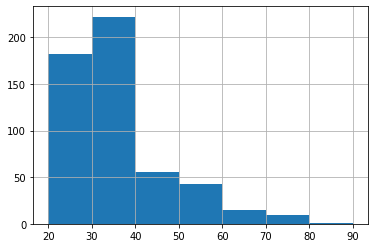

In [56]:
parent_samples["age"].hist(bins=range(20, 100, 10))

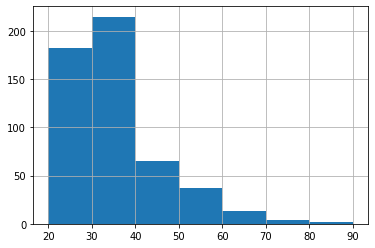

In [55]:
air_in_df["age"].hist(bins=range(20, 100, 10))

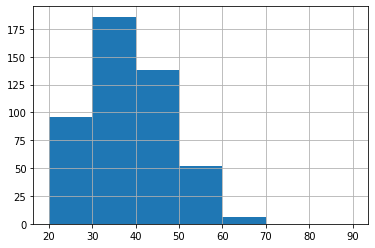

In [57]:
sdv_users_samps["age"].hist(bins=range(20, 100, 10))

In [58]:
sdv_sessions_samps["user_id"].value_counts().describe()

count    1000.000000
mean        7.792000
std         3.670723
min         2.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        15.000000
Name: user_id, dtype: float64

In [59]:
air_out_df["user_id"].value_counts().describe()

count    1000.000000
mean        7.565000
std         4.136047
min         2.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        15.000000
Name: user_id, dtype: float64

In [ ]:
parent_samples

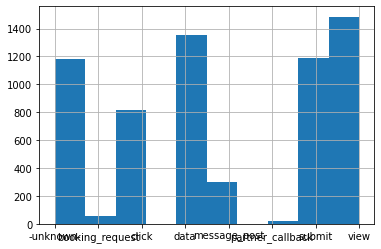

In [60]:
child_samples["action_type"].sort_values().hist()

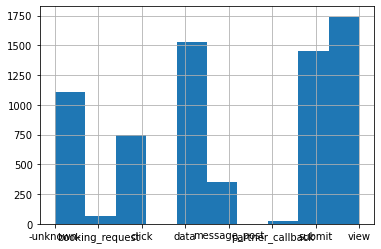

In [61]:
air_out_df["action_type"].sort_values().hist()

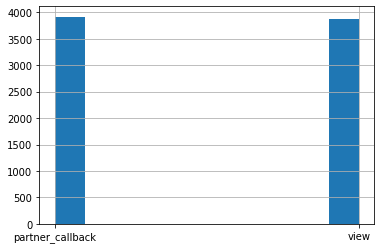

In [62]:
sdv_sessions_samps["action_type"].sort_values().hist()

In [48]:
len(air_out_df)

7565

In [51]:
child_samples["user_id"].value_counts().describe()

count    1000.000000
mean        3.332000
std         1.738044
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: user_id, dtype: float64

# Telstra Dataset

In [5]:
TELSTRA_DATA = Path("/content/REaLTabFormer-Experiments/data/relational/telstra")
TELSTRA_EXP = RELATIONAL_EXP_PATH / "telstra"

In [33]:
telstra_train = pd.read_csv(TELSTRA_DATA / "train.csv.zip")
telstra_event_type = pd.read_csv(TELSTRA_DATA / "event_type.csv.zip")
telstra_severity_type = pd.read_csv(TELSTRA_DATA / "severity_type.csv.zip")

telstra_log_feature = pd.read_csv(TELSTRA_DATA / "log_feature.csv.zip")

join_on = "id"

In [7]:
telstra_train.head()

id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1
3   8218  location 931               1
4  14804  location 120               0

In [13]:
telstra_train["id"].nunique(), telstra_train.shape

(7381, (7381, 3))

In [15]:
print(telstra_event_type["id"].nunique(), len(telstra_event_type))
telstra_event_type.head()

18552 31170


id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15
3  5022  event_type 15
4  5022  event_type 11

In [16]:
print(telstra_severity_type["id"].nunique(), len(telstra_severity_type))
telstra_severity_type.head()

18552 18552


id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2
3  5022  severity_type 1
4  6852  severity_type 1

In [17]:
print(telstra_log_feature["id"].nunique(), len(telstra_log_feature))
telstra_log_feature.head()

18552 58671


id  log_feature  volume
0  6597   feature 68       6
1  8011   feature 68       7
2  2597   feature 68       1
3  5022  feature 172       2
4  5022   feature 56       1

In [23]:
telstra_event_type.value_counts("id")

id
10354    11
15184    10
14243    10
17023     9
8590      9
         ..
8836      1
12823     1
8838      1
12821     1
9277      1
Length: 18552, dtype: int64

In [24]:
telstra_event_type[telstra_event_type["id"] == 10354]

id     event_type
27351  10354  event_type 53
27352  10354  event_type 42
27353  10354  event_type 20
27354  10354  event_type 43
27355  10354  event_type 45
27356  10354  event_type 49
27357  10354  event_type 11
27358  10354  event_type 47
27359  10354  event_type 21
27360  10354  event_type 44
27361  10354  event_type 50

In [30]:
telstra_log_feature

id  log_feature  volume
0      6597   feature 68       6
1      8011   feature 68       7
2      2597   feature 68       1
3      5022  feature 172       2
4      5022   feature 56       1
...     ...          ...     ...
58666  8720  feature 209       1
58667  6488   feature 54       3
58668   878   feature 62       1
58669  4464  feature 209       1
58670  4464   feature 87       2

[58671 rows x 3 columns]

### Create a parent table

In [21]:
telstra_parent = telstra_train.merge(telstra_severity_type, on="id", how="left")
telstra_parent

id       location  fault_severity    severity_type
0     14121   location 118               1  severity_type 2
1      9320    location 91               0  severity_type 2
2     14394   location 152               1  severity_type 2
3      8218   location 931               1  severity_type 1
4     14804   location 120               0  severity_type 1
...     ...            ...             ...              ...
7376    870   location 167               0  severity_type 2
7377  18068   location 106               0  severity_type 1
7378  14111  location 1086               2  severity_type 2
7379  15189     location 7               0  severity_type 1
7380  17067   location 885               0  severity_type 1

[7381 rows x 4 columns]

### Create a child table

In [31]:
telstra_child = telstra_log_feature[telstra_log_feature["id"].isin(telstra_parent["id"].tolist())]
telstra_child

id  log_feature  volume
1      8011   feature 68       7
14     2588   feature 82       9
15     2588  feature 201       5
16     2588   feature 80      15
17     2588  feature 203       5
...     ...          ...     ...
58655  8114   feature 54       1
58656  8114   feature 87       3
58668   878   feature 62       1
58669  4464  feature 209       1
58670  4464   feature 87       2

[23851 rows x 3 columns]

In [34]:
telstra_n_child = telstra_child[join_on].value_counts()
telstra_n_child.name = "n_child"
telstra_n_child = telstra_n_child.reset_index().rename(columns={"index": join_on})

telstra_parent = telstra_parent.merge(telstra_n_child, on=join_on)
telstra_parent.head()

id      location  fault_severity    severity_type  n_child
0  14121  location 118               1  severity_type 2        2
1   9320   location 91               0  severity_type 2        2
2  14394  location 152               1  severity_type 2        2
3   8218  location 931               1  severity_type 1        3
4  14804  location 120               0  severity_type 1        9

In [99]:
telstra_in_df = telstra_parent.copy()
telstra_out_df = telstra_child.copy()

In [100]:
telstra_in_df.insert(1, "n_child", telstra_in_df.pop("n_child"))
telstra_in_df.insert(len(telstra_in_df.columns) - 1, "location", telstra_in_df.pop("location"))

In [101]:
telstra_in_df

id  n_child  fault_severity    severity_type       location
0     14121        2               1  severity_type 2   location 118
1      9320        2               0  severity_type 2    location 91
2     14394        2               1  severity_type 2   location 152
3      8218        3               1  severity_type 1   location 931
4     14804        9               0  severity_type 1   location 120
...     ...      ...             ...              ...            ...
7376    870        2               0  severity_type 2   location 167
7377  18068        2               0  severity_type 1   location 106
7378  14111        2               2  severity_type 2  location 1086
7379  15189        4               0  severity_type 1     location 7
7380  17067        3               0  severity_type 1   location 885

[7381 rows x 5 columns]

## REaLTabFormer parent table model

In [103]:
parent_rtf = REaLTabFormer(
    "tabular",
    checkpoints_dir=TELSTRA_EXP / "parent_rtf_checkpoints",
    epochs=100,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=64,
    mask_rate=0.1,
    gradient_accumulation_steps=4,
    early_stopping_patience=0,
    save_total_limit=1,
)

In [104]:
parent_rtf.fit(
    df=telstra_in_df.drop(join_on, axis=1),
    num_bootstrap=500,
    frac=0.165,
    n_critic=5,
    gen_rounds=3,
    sensitivity_max_col_nums=20,
    full_sensitivity=False,
    sensitivity_orig_frac_multiple=4,

    # qt_max="compute"
    qt_max=telstra_in_df.drop(join_on, axis=1).duplicated().mean() + 0.05,
)
parent_rtf.save(TELSTRA_EXP / "rtf_parent_model")

Computing the sensitivity threshold...


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.061168
std        0.009799
min        0.030570
25%        0.055246
50%        0.061059
75%        0.067915
max        0.098222
dtype: float64
Sensitivity threshold: 0.07583595841275446 qt_max: 0.5190421352120309


  0%|          | 0/7381 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7381
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 145
  Number of trainable parameters = 44052480


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-29
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-29/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-29/pytorch_model.bin
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-58
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-58/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-58/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-29] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relati

  0%|          | 0/3651 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3712 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to g

Critic round: 5, sensitivity_threshold: 0.07583595841275446, val_sensitivity: 0.06429622749297076, val_sensitivities: [0.06657873279318612, 0.08054242445747657, 0.0645837358874343, 0.07501459070119455, 0.07199624198844545, 0.06582910007991863, 0.051479526806506824, 0.0627315391222946, 0.060364669194614924, 0.06581395876632289, 0.05766238986164427, 0.07487351653324952, 0.05460932474221798, 0.042354304491622946, 0.07000935696843179]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7381
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 290
  Number of trainable parameters = 44052480
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 145
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-174
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-174/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-174/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-145] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-200
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-200/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp

  0%|          | 0/3651 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3712 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/not-best-disc-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/not-best-disc-model/config.json


Saving not-best model...


Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/not-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-290.


Critic round: 10, sensitivity_threshold: 0.07583595841275446, val_sensitivity: 0.10487788610863485, val_sensitivities: [0.10117576131743433, 0.10943751703411317, 0.09992225223204121, 0.11376898433165933, 0.11027873219378433, 0.10005013303219755, 0.08639927035415351, 0.10106423003681318, 0.09409004350509564, 0.10401298964966074, 0.11070597879908312, 0.12081102121300592, 0.11773616584622391, 0.09915894047969304, 0.10455627160456357]


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7381
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 435
  Number of trainable parameters = 44052480
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 290
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-300
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-300/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-290] due to args.save_total_limit
Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-319
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-319/config.json
Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/checkpoint-319/pytorch_model.bin
Deleting older checkpoint [/content/REaLTabFormer-Experiments/exp

  0%|          | 0/3651 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3712 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/last-epoch-model
Configuration saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/last-epoch-model/config.json


Critic round: 15, sensitivity_threshold: 0.07583595841275446, val_sensitivity: 0.12225997777438884, val_sensitivities: [0.11681746780815018, 0.12019122010627223, 0.10693196664193165, 0.11518714994063001, 0.1166816677117641, 0.12717938955955796, 0.11905634659989035, 0.11416398116961662, 0.12378964881785202, 0.12933258612650372, 0.1376948414848936, 0.14078411057866658, 0.12897284821285548, 0.11362931438031343, 0.12348712747693476]
Stopping training, no improvement in critic...


Model weights saved in /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file /content/REaLTabFormer-Experiments/exp-relational/telstra/parent_rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "u

Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model


In [105]:
parent_samples = parent_rtf.sample(n_samples=len(telstra_in_df))
parent_samples.index.name = join_on
parent_samples = parent_samples.reset_index()
parent_samples.head()

  0%|          | 0/7381 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 7424 samples generated. Sampling efficiency is: 100.0000%


id  n_child  fault_severity    severity_type       location
0   0        1               1  severity_type 4   location 895
1   1        6               1  severity_type 1   location 856
2   2        6               0  severity_type 2   location 480
3   3        2               0  severity_type 2   location 504
4   4        5               1  severity_type 1  location 1107

In [106]:
parent_samples["n_child"].describe()

count    7381.000000
mean        3.139006
std         1.981670
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
Name: n_child, dtype: float64

In [107]:
parent_samples["n_child"].sum(), telstra_in_df["n_child"].sum()

(23169, 23851)

## REaLTabFormer child table model

In [108]:
parent_realtabformer_path = sorted(
    [p for p in (TELSTRA_EXP / "rtf_parent_model").glob("id*") if p.is_dir()],
    key=os.path.getmtime)[-1]

parent_realtabformer_path

PosixPath('/content/REaLTabFormer-Experiments/exp-relational/telstra/rtf_parent_model/id000016744506547583418368')

In [109]:
child_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path=parent_realtabformer_path,
    epochs=100,
    output_max_length=None,
    numeric_nparts=1,
    # mask_rate=0.05,
    batch_size=32,
)
child_rtf.fit(df=telstra_out_df, in_df=telstra_in_df, join_on=join_on)

child_rtf.save(TELSTRA_EXP / "rtf_child_model")

/content/realtabformer/realtabformer.py:149: UserWarning: The `output_max_length` is None. This could result to extended model training if the output length has large variations.
  warnings.warn(
/content/realtabformer/realtabformer.py:277: UserWarning: A trained model for the parent table is available. The encoder will use the pretrained config and weights.
  warnings.warn(
/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/23851 [00:00<?, ?ex/s]

  0%|          | 0/7381 [00:00<?, ?ex/s]

  0%|          | 0/7381 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7381
  Num Epochs = 100
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 5700
  Number of trainable parameters = 57782784
/usr/local/lib/python3.8/dist-packages/transformers/models/e

Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [rtf_checkpoints/checkpoint-1200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoin

## Generate samples

In [110]:
parent_samples = parent_rtf.sample(n_samples=len(telstra_in_df))
parent_samples.index.name = join_on
parent_samples = parent_samples.reset_index()
parent_samples.head()

  0%|          | 0/7381 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 7424 samples generated. Sampling efficiency is: 100.0000%


id  n_child  fault_severity    severity_type       location
0   0        3               0  severity_type 1   location 821
1   1        4               1  severity_type 2  location 1008
2   2        3               2  severity_type 1  location 1100
3   3        2               0  severity_type 2    location 91
4   4        3               1  severity_type 2  location 1026

In [111]:
parent_samples["n_child"].sum()

23237

In [112]:
parent_samples["n_child"].describe()

count    7381.000000
mean        3.148218
std         2.019681
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
Name: n_child, dtype: float64

In [113]:
telstra_in_df["n_child"].describe()

count    7381.000000
mean        3.231405
std         2.246490
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
Name: n_child, dtype: float64

In [114]:
child_samples = []
for n_child, df in parent_samples.sort_values("n_child").groupby("n_child"):
    print(n_child)
    _child_samples = child_rtf.sample(
        input_unique_ids=df[join_on],
        input_df=df.drop(join_on, axis=1),
        gen_batch=64)

    child_samples.append(_child_samples)

0


/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/972 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

2


  0%|          | 0/2940 [00:00<?, ?ex/s]

  0%|          | 0/46 [00:00<?, ?it/s]

3


  0%|          | 0/915 [00:00<?, ?ex/s]

  0%|          | 0/15 [00:00<?, ?it/s]

4


  0%|          | 0/1142 [00:00<?, ?ex/s]

  0%|          | 0/18 [00:00<?, ?it/s]

5


  0%|          | 0/448 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?it/s]

6


  0%|          | 0/585 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7


  0%|          | 0/124 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?it/s]

8


  0%|          | 0/134 [00:00<?, ?ex/s]

  0%|          | 0/3 [00:00<?, ?it/s]

9


  0%|          | 0/27 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10


  0%|          | 0/24 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

11


  0%|          | 0/10 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12


  0%|          | 0/16 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

13


  0%|          | 0/8 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

14


  0%|          | 0/9 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15


  0%|          | 0/12 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

16


  0%|          | 0/5 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

17


  0%|          | 0/2 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

18


  0%|          | 0/3 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

19


  0%|          | 0/1 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [115]:
child_samples = pd.concat(child_samples)

In [116]:
child_samples

log_feature  volume
5065  feature 154       2
5065  feature 171      15
5065  feature 150       4
5065   feature 38       4
5065  feature 383       2
...           ...     ...
3940  feature 232      21
3940  feature 312      21
3940  feature 315       1
3940  feature 233       1
3940  feature 235       1

[49350 rows x 2 columns]

In [117]:
len(child_samples)

49350

In [118]:
child_samples.index.name = join_on
child_samples = child_samples.reset_index()
child_samples = child_samples[telstra_out_df.columns]
child_samples.head()

id  log_feature  volume
0  5065  feature 154       2
1  5065  feature 171      15
2  5065  feature 150       4
3  5065   feature 38       4
4  5065  feature 383       2

In [119]:
TELSTRA_SAMPLES = (TELSTRA_EXP / "rtf_samples")
TELSTRA_SAMPLES.mkdir(parents=True, exist_ok=True)

child_samples.to_csv(TELSTRA_SAMPLES / "rtf_telstra_child_samples.csv", index=None)
parent_samples.to_csv(TELSTRA_SAMPLES / "rtf_telstra_parent_samples.csv", index=None)

## SDV HMA model

In [120]:
from sdv import Metadata
from sdv.relational import HMA1

metadata = Metadata()


metadata.add_table(
    name='parent',
    data=telstra_in_df,
    primary_key=join_on,
    # fields_metadata=users_fields,
)

metadata.add_table(
    name='child',
    data=telstra_out_df,
    parent='parent',
    foreign_key=join_on,
)

print(metadata)

Metadata
  root_path: .
  tables: ['parent', 'child']
  relationships:
    child.id -> parent.id


In [121]:
model = HMA1(metadata)

tables = dict(
    child=telstra_out_df,
    parent=telstra_in_df,
)

model.fit(tables)

new_data = model.sample(num_rows=len(telstra_in_df))

sdv_parent_samps = new_data["parent"]
sdv_child_samps = new_data["child"]

# sdv_train_samps["Date"] = sdv_train_samps["Date"].dt.strftime("%Y-%m-%d")

/usr/local/lib/python3.8/dist-packages/sdv/relational/hma.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_rows[foreign_key] = parent_row[parent_key]


In [122]:
len(telstra_out_df)

23851

In [123]:
len(sdv_child_samps)

25097

In [125]:
sdv_parent_samps["n_child"].describe()

count    7381.000000
mean        3.400217
std         1.953447
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        12.000000
Name: n_child, dtype: float64

In [126]:
sdv_parent_samps

id  n_child  fault_severity    severity_type       location
0        0        4               1  severity_type 1   location 122
1        1        4               0  severity_type 2   location 821
2        2        5               1  severity_type 2    location 91
3        3        6               1  severity_type 1   location 814
4        4        3               0  severity_type 2  location 1109
...    ...      ...             ...              ...            ...
7376  7376        1               0  severity_type 2   location 561
7377  7377        2               0  severity_type 1   location 561
7378  7378        7               0  severity_type 2   location 839
7379  7379        1               0  severity_type 1   location 845
7380  7380        3               1  severity_type 1   location 691

[7381 rows x 5 columns]

In [ ]:
telstra_out_df

In [127]:
sdv_child_samps

id  log_feature  volume
0         0  feature 312       9
1         0  feature 312      10
2         0  feature 312       8
3         0  feature 312       9
4         1  feature 312       6
...     ...          ...     ...
25092  7378  feature 312       1
25093  7379  feature 312      71
25094  7380  feature 312       9
25095  7380  feature 312       5
25096  7380  feature 312       4

[25097 rows x 3 columns]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'child': {'score': 0.018151196530205915},
 'parent': {'score': 0.7948570092141888}}

In [139]:
lm.compute(telstra_in_df.drop(join_on, axis=1), parent_samples.drop(join_on, axis=1))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.5707105144795348

In [138]:
parent_samples

id  n_child  fault_severity    severity_type       location
0        0        3               0  severity_type 1   location 821
1        1        4               1  severity_type 2  location 1008
2        2        3               2  severity_type 1  location 1100
3        3        2               0  severity_type 2    location 91
4        4        3               1  severity_type 2  location 1026
...    ...      ...             ...              ...            ...
7376  7376        5               1  severity_type 1   location 744
7377  7377        6               0  severity_type 2   location 480
7378  7378        1               0  severity_type 1  location 1097
7379  7379        1               0  severity_type 2     location 9
7380  7380        3               1  severity_type 2  location 1086

[7381 rows x 5 columns]

In [137]:
m.compute(tables, dict(parent=parent_samples, child=child_samples), metadata)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'child': {'score': 0.24482352269605157},
 'parent': {'score': 0.5652450860161866}}

# Scratch

In [ ]:
samples = parent_rtf.sample(n_samples=len(in_df))

  0%|          | 0/1115 [00:00<?, ?it/s]

Generated 1 invalid samples out of total 1152 samples generated. Sampling efficiency is: 99.9132%


In [ ]:
samples

StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0            d          c               6210.0                        NaN   
1            a          a               4040.0                        3.0   
2            a          a               1590.0                        3.0   
3            c          a               3110.0                        9.0   
4            a          a               3750.0                        2.0   
...        ...        ...                  ...                        ...   
1110         a          a               1600.0                       10.0   
1111         d          c              12170.0                        2.0   
1112         c          a                240.0                        NaN   
1113         a          c              13540.0                        NaN   
1114         a          a                480.0                       10.0   

      CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                          NaN       1             22.0           2012.0   
1                       2008.0       1             22.0           2011.0   
2                       2012.0       0              NaN              NaN   
3                       2003.0       0              NaN              NaN   
4                       2005.0       1             22.0           2011.0   
...                        ...     ...              ...              ...   
1110                    2013.0       1             40.0           2014.0   
1111                    2013.0       0              NaN              NaN   
1112                       NaN       1              5.0           2013.0   
1113                       NaN       1             10.0           2013.0   
1114                    2004.0       1             18.0           2014.0   

         PromoInterval  
0     Mar,Jun,Sept,Dec  
1     Mar,Jun,Sept,Dec  
2                  NaN  
3                  NaN  
4      Feb,May,Aug,Nov  
...                ...  
1110   Jan,Apr,Jul,Oct  
1111               NaN  
1112   Feb,May,Aug,Nov  
1113  Mar,Jun,Sept,Dec  
1114   Jan,Apr,Jul,Oct  

[1115 rows x 9 columns]

In [ ]:
import matplotlib.pyplot as plt

Store


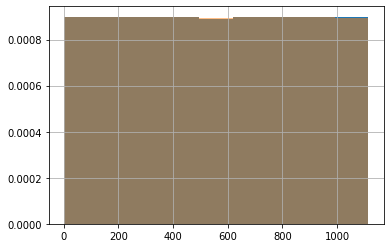

StoreType


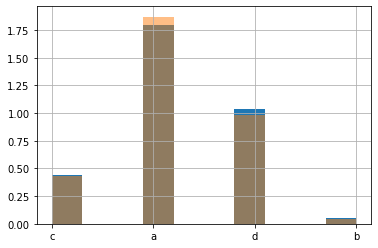

Assortment


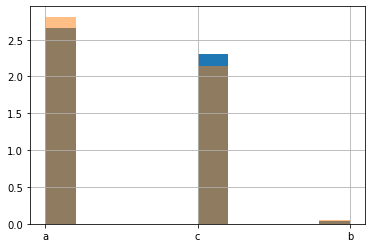

CompetitionDistance


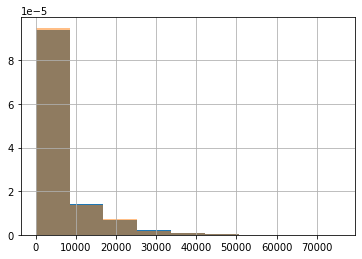

CompetitionOpenSinceMonth


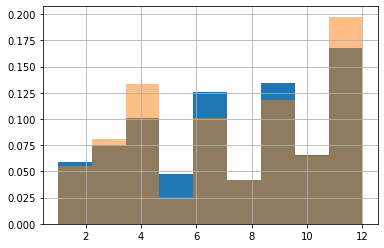

CompetitionOpenSinceYear


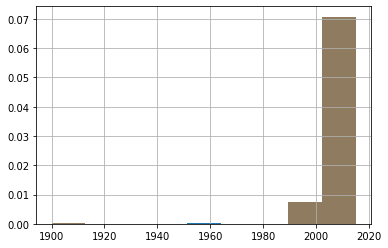

Promo2


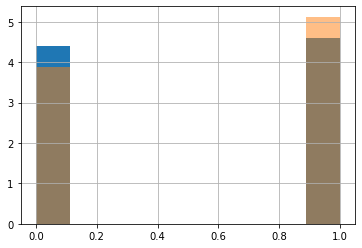

Promo2SinceWeek


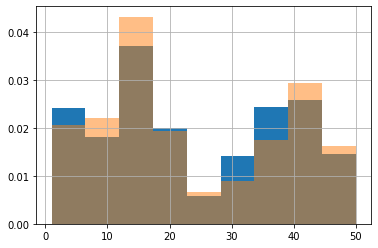

Promo2SinceYear


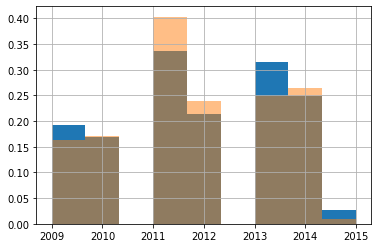

PromoInterval


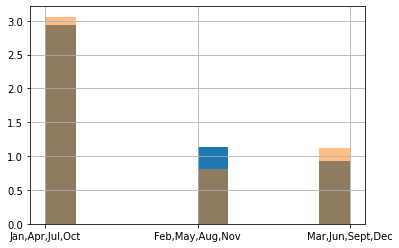

In [ ]:
for col in parent_samples.columns:
    print(col)
    if in_df[col].dtype == "object":
        in_df[col].hist(density=True)
        parent_samples[col].hist(density=True, alpha=0.5)        
    else:
        bins = np.linspace(in_df[col].min(), in_df[col].max(), 10)
        in_df[col].hist(bins=bins, density=True)
        parent_samples[col].hist(bins=bins, density=True, alpha=0.5)

    plt.show()

StoreType


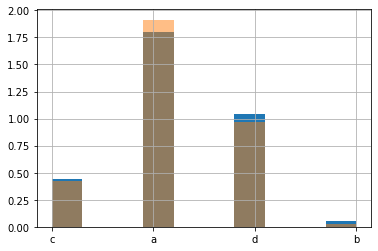

Assortment


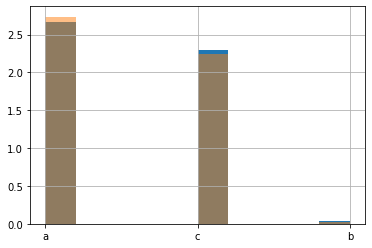

CompetitionDistance


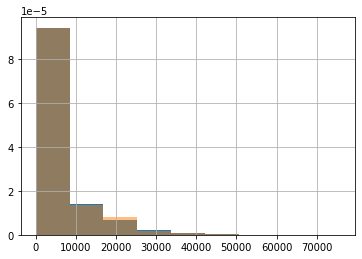

CompetitionOpenSinceMonth


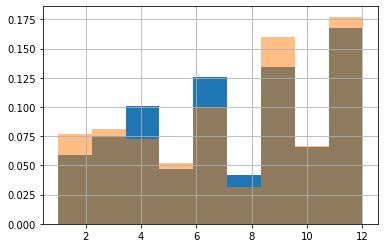

CompetitionOpenSinceYear


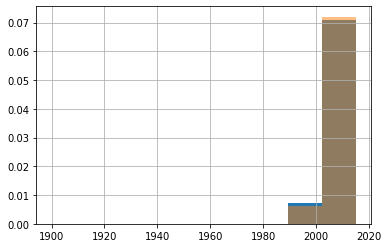

Promo2


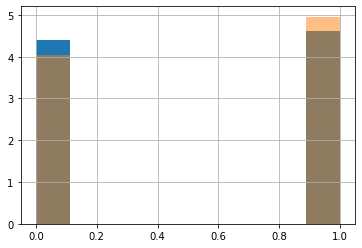

Promo2SinceWeek


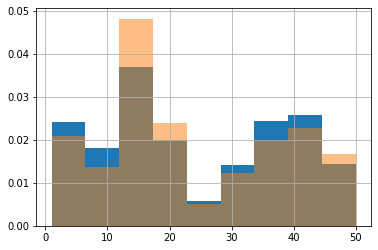

Promo2SinceYear


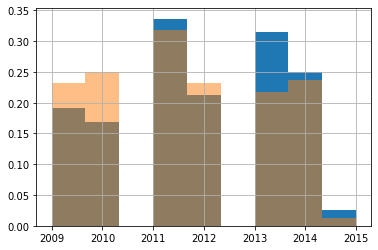

PromoInterval


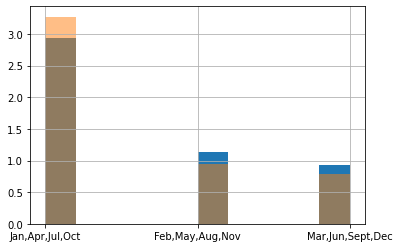

In [ ]:
for col in samples.columns:
    print(col)
    if in_df[col].dtype == "object":
        in_df[col].hist(density=True)
        samples[col].hist(density=True, alpha=0.5)        
    else:
        bins = np.linspace(in_df[col].min(), in_df[col].max(), 10)
        in_df[col].hist(bins=bins, density=True)
        samples[col].hist(bins=bins, density=True, alpha=0.5)

    plt.show()

StoreType


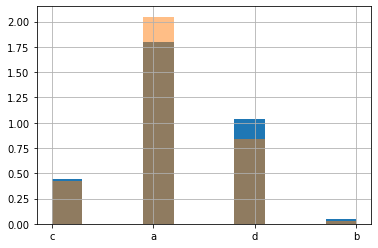

Assortment


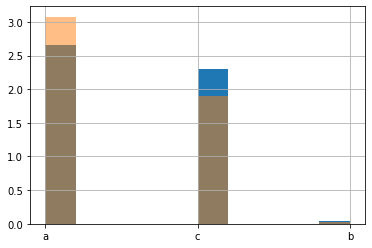

CompetitionDistance


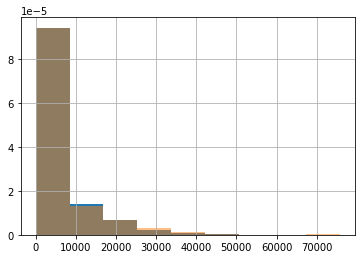

CompetitionOpenSinceMonth


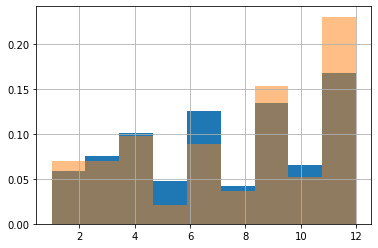

CompetitionOpenSinceYear


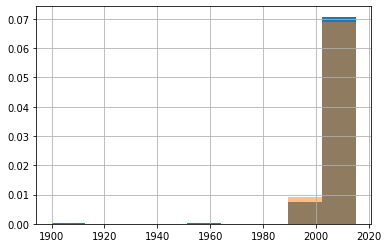

Promo2


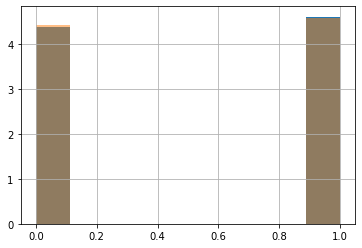

Promo2SinceWeek


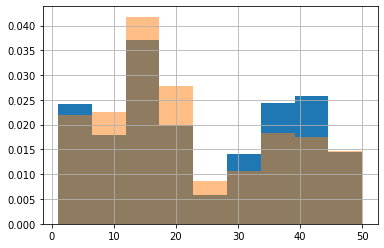

Promo2SinceYear


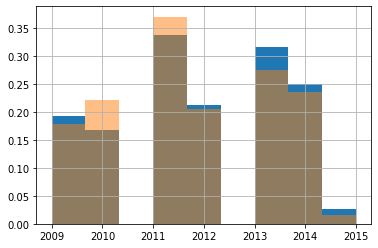

PromoInterval


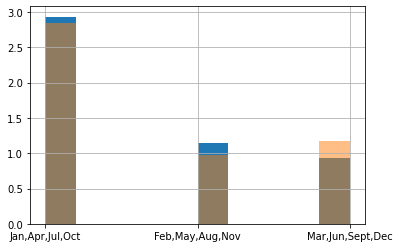

In [ ]:
for col in samples.columns:
    print(col)
    if in_df[col].dtype == "object":
        in_df[col].hist(density=True)
        samples[col].hist(density=True, alpha=0.5)        
    else:
        bins = np.linspace(in_df[col].min(), in_df[col].max(), 10)
        in_df[col].hist(bins=bins, density=True)
        samples[col].hist(bins=bins, density=True, alpha=0.5)

    plt.show()

In [ ]:
import json
from pathlib import Path
from transformers import EncoderDecoderConfig, GPT2Config, EncoderDecoderModel, GPT2Model, GPT2LMHeadModel

parent_config = json.loads(Path("/content/rtf_rossmann_parent/id000016740555427954163712/rtf_config.json").read_text())

parent_gpt2_config = parent_config["tabular_config"]
parent_vocab = parent_config["vocab"]

In [ ]:
parent_config["col_transform_data"]

{'CompetitionDistance': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 5},
 'CompetitionOpenSinceMonth': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 4},
 'CompetitionOpenSinceYear': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 4},
 'Promo2': {'max_len': 10, 'numeric_precision': 4, 'mx_sig': -1, 'zfill': 1},
 'Promo2SinceWeek': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 4},
 'Promo2SinceYear': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 4}}

In [ ]:
relational_config = EncoderDecoderConfig(
    # encoder=GPT2Config(n_layer=6, vocab_size=len(parent_rtf.vocab["id2token"])).to_dict(),
    encoder=GPT2Config(**parent_gpt2_config).to_dict(),
    decoder=GPT2Config(n_layer=6).to_dict(),
)

In [ ]:
relational_config.encoder = GPT2Config(**parent_gpt2_config)

In [ ]:
relational_config

EncoderDecoderConfig {
  "_commit_hash": null,
  "decoder": {
    "_name_or_path": "",
    "activation_function": "gelu_new",
    "add_cross_attention": false,
    "architectures": null,
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range": 0.02,
    "is_decoder": false,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1
    },
    "layer_norm_epsilon": 1e-05,
    "length_penalty": 1

In [ ]:
enc_dec_model = EncoderDecoderModel(relational_config)

In [ ]:
enc_dec_model.encoder.state_dict()

OrderedDict([('wte.weight',
              tensor([[ 0.0112,  0.0155,  0.0275,  ..., -0.0165,  0.0404,  0.0061],
                      [ 0.0224, -0.0390,  0.0233,  ...,  0.0310, -0.0100, -0.0035],
                      [-0.0133,  0.0270,  0.0255,  ..., -0.0282,  0.0157,  0.0040],
                      ...,
                      [ 0.0170, -0.0313, -0.0109,  ..., -0.0070,  0.0226,  0.0278],
                      [-0.0396, -0.0010,  0.0122,  ...,  0.0016, -0.0042, -0.0046],
                      [ 0.0115, -0.0209, -0.0301,  ..., -0.0268,  0.0369,  0.0059]])),
             ('wpe.weight',
              tensor([[ 0.0242,  0.0032,  0.0120,  ...,  0.0016, -0.0018,  0.0046],
                      [ 0.0029,  0.0233, -0.0077,  ..., -0.0263,  0.0149, -0.0188],
                      [ 0.0039, -0.0035,  0.0131,  ..., -0.0095,  0.0254, -0.0471],
                      ...,
                      [-0.0181, -0.0223, -0.0105,  ..., -0.0096,  0.0121, -0.0062],
                      [-0.0100,  0.0041, -0.013

In [ ]:
enc = torch.load("/content/rtf_rossmann_parent/id000016740555427954163712/rtf_model.pt")

In [ ]:
enc_state = type(enc)([(k.replace("transformer.", "") if k.startswith("transformer.") else k, v) for k, v in enc.items()])

In [ ]:
og_state = enc_dec_model.encoder.state_dict().copy()
og_state

OrderedDict([('wte.weight',
              tensor([[ 0.0112,  0.0155,  0.0275,  ..., -0.0165,  0.0404,  0.0061],
                      [ 0.0224, -0.0390,  0.0233,  ...,  0.0310, -0.0100, -0.0035],
                      [-0.0133,  0.0270,  0.0255,  ..., -0.0282,  0.0157,  0.0040],
                      ...,
                      [ 0.0170, -0.0313, -0.0109,  ..., -0.0070,  0.0226,  0.0278],
                      [-0.0396, -0.0010,  0.0122,  ...,  0.0016, -0.0042, -0.0046],
                      [ 0.0115, -0.0209, -0.0301,  ..., -0.0268,  0.0369,  0.0059]])),
             ('wpe.weight',
              tensor([[ 0.0242,  0.0032,  0.0120,  ...,  0.0016, -0.0018,  0.0046],
                      [ 0.0029,  0.0233, -0.0077,  ..., -0.0263,  0.0149, -0.0188],
                      [ 0.0039, -0.0035,  0.0131,  ..., -0.0095,  0.0254, -0.0471],
                      ...,
                      [-0.0181, -0.0223, -0.0105,  ..., -0.0096,  0.0121, -0.0062],
                      [-0.0100,  0.0041, -0.013

In [ ]:
pretrain_load = enc_dec_model.encoder.load_state_dict(enc_state, strict=False)
assert not pretrain_load.missing_keys

pretrain_load

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [ ]:
enc_dec_model.encoder.state_dict()

OrderedDict([('wte.weight',
              tensor([[ 0.0197,  0.0184,  0.0261,  ...,  0.0340, -0.0021,  0.0228],
                      [-0.0083,  0.0456,  0.0244,  ..., -0.0159,  0.0389,  0.0216],
                      [ 0.0217,  0.0214,  0.0248,  ...,  0.0150,  0.0082,  0.0417],
                      ...,
                      [-0.0204,  0.0062,  0.0137,  ..., -0.0089, -0.0173,  0.0239],
                      [-0.0266, -0.0052, -0.0044,  ..., -0.0332,  0.0067, -0.0110],
                      [ 0.0048,  0.0022, -0.0246,  ...,  0.0225, -0.0434, -0.0255]])),
             ('wpe.weight',
              tensor([[-0.0072,  0.0147, -0.0270,  ...,  0.0131, -0.0035,  0.0084],
                      [ 0.0471,  0.0028,  0.0075,  ..., -0.0179, -0.0155,  0.0006],
                      [ 0.0387, -0.0201,  0.0240,  ...,  0.0106,  0.0112,  0.0218],
                      ...,
                      [ 0.0055,  0.0430,  0.0152,  ...,  0.0157, -0.0199,  0.0064],
                      [-0.0038, -0.0367, -0.030

In [ ]:
for param in enc_dec_model.encoder.parameters():
    param.requires_grad = False

In [ ]:
.enc_dec_model

In [ ]:
# f_samples = samples.fillna(value=np.nan)
# f_samples

In [ ]:
original = in_df.sample(n=int(0.165 * len(in_df) * 3)).drop("Store", axis=1)
other = in_df.loc[in_df.index.difference(original.index)].sample(n=int(0.165 * len(in_df))).drop("Store", axis=1)

In [ ]:
len(original), len(other)

(551, 183)

In [ ]:
synthetic = samples.sample(n=len(other))

In [ ]:
g = len(other)
i = 2
m = realtabformer.rtf_analyze.SyntheticDataBench.compute_sensitivity_metric(
    original, samples[i * g: (i + 1) * g], other
)
m

ValueError: ignored

In [ ]:
processed = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(
              original, other=[other]  #, samples[i * g: (i + 1) * g]]
          )

In [ ]:
processed["preprocessor"].transform(samples[i * g: (i + 1) * g].iloc[:142])

array([[-0.29520779,         nan,         nan, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5602829 , -0.44033334,  1.17877787, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.65883585,  1.09341201, -0.16290097, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.83575011, -0.13358427,  0.95516473, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.18254454, -0.44033334, -0.61012725, ...,  0.        ,
         0.        ,  1.        ],
       [-0.35657047, -1.05383149,  0.95516473, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
samples[i * g: (i + 1) * g].iloc[140: 145].replace("", np.nan)

StoreType Assortment CompetitionDistance  CompetitionOpenSinceMonth  \
506         a          a                6340                        6.0   
507         a          a              2650.0                        4.0   
508         a          a                 NaN                        9.0   
509         a          a               510.0                       11.0   
510         a          a              1330.0                        4.0   

     CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
506                    2006.0       1              NaN              NaN   
507                    2013.0       0              NaN              NaN   
508                    2013.0       0              NaN              NaN   
509                    2012.0       1             40.0           2014.0   
510                    2014.0       1             22.0           2012.0   

        PromoInterval  
506               NaN  
507               NaN  
508               NaN  
509  Mar,Jun,Sept,Dec  
510   Jan,Apr,Jul,Oct

In [ ]:
samples[i * g: (i + 1) * g]

StoreType Assortment CompetitionDistance  CompetitionOpenSinceMonth  \
366         d          c              3070.0                        NaN   
367         a          a             15770.0                        6.0   
368         b          a              9600.0                       11.0   
369         a          a               330.0                       10.0   
370         a          c               140.0                        NaN   
..        ...        ...                 ...                        ...   
544         d          a               410.0                        NaN   
545         a          a                 440                        8.0   
546         d          c              6320.0                        NaN   
547         c          a               620.0                        4.0   
548         d          c             29680.0                        NaN   

     CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
366                       NaN       1             10.0           2014.0   
367                    2014.0       0              NaN              NaN   
368                    2008.0       0              NaN              NaN   
369                    2015.0       0              NaN              NaN   
370                       NaN       1              5.0           2013.0   
..                        ...     ...              ...              ...   
544                       NaN       0              NaN              NaN   
545                    2008.0       0              NaN              NaN   
546                       NaN       1             41.0           2013.0   
547                    2007.0       1             45.0           2013.0   
548                       NaN       1             35.0           2012.0   

        PromoInterval  
366   Feb,May,Aug,Nov  
367               NaN  
368               NaN  
369               NaN  
370   Feb,May,Aug,Nov  
..                ...  
544               NaN  
545               NaN  
546   Feb,May,Aug,Nov  
547   Feb,May,Aug,Nov  
548  Mar,Jun,Sept,Dec  

[183 rows x 9 columns]

In [ ]:
len(other)

183

In [ ]:
samples[i * g: (i + 1) * g]

StoreType Assortment CompetitionDistance  CompetitionOpenSinceMonth  \
183         a          c                3030                       11.0   
184         a          a              2070.0                        5.0   
185         a          a               780.0                        NaN   
186         a          c                60.0                        NaN   
187         a          a               910.0                        4.0   
..        ...        ...                 ...                        ...   
361         d          a               640.0                        7.0   
362         a          a               280.0                       11.0   
363         d          c              8470.0                        7.0   
364         a          a             17040.0                       11.0   
365         d          c              8260.0                       11.0   

     CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
183                    2005.0       1              9.0           2011.0   
184                    2007.0       0              NaN              NaN   
185                       NaN       1             10.0           2013.0   
186                       NaN       1              1.0           2012.0   
187                    2013.0       1             37.0           2009.0   
..                        ...     ...              ...              ...   
361                    2011.0       1             45.0           2010.0   
362                    2009.0       0              NaN              NaN   
363                    2008.0       1              NaN              NaN   
364                    2012.0       0              NaN              NaN   
365                    2013.0       1             22.0           2012.0   

        PromoInterval  
183  Mar,Jun,Sept,Dec  
184              <NA>  
185   Jan,Apr,Jul,Oct  
186   Jan,Apr,Jul,Oct  
187   Jan,Apr,Jul,Oct  
..                ...  
361   Feb,May,Aug,Nov  
362              <NA>  
363              <NA>  
364              <NA>  
365  Mar,Jun,Sept,Dec  

[183 rows x 9 columns]

In [ ]:
for c in samples.columns:
    if samples[c].astype(str).str.contains("1NaN20").sum() > 0:
        print(c)

CompetitionDistance


In [ ]:
series = samples["CompetitionDistance"].replace("1NaN20", "1@20")
series

0       1900.0
1         1730
2        460.0
3        210.0
4      12240.0
        ...   
995       1170
996    14420.0
997        NaN
998     1770.0
999      360.0
Name: CompetitionDistance, Length: 1000, dtype: object

In [ ]:
series = series.astype(str)
series

0       1900.0
1         1730
2        460.0
3        210.0
4      12240.0
        ...   
995       1170
996    14420.0
997        nan
998     1770.0
999      360.0
Name: CompetitionDistance, Length: 1000, dtype: object

In [ ]:
re_invalid_pattern = realtabformer.data_utils.INVALID_NUMS_RE
invalid_idx = series.str.contains(re_invalid_pattern, regex=True)
invalid_idx

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997     True
998    False
999    False
Name: CompetitionDistance, Length: 1000, dtype: bool

In [ ]:
sser = series.replace(f".*@+.*", "NaN", regex=True)
inv = sser.str.contains(re_invalid_pattern, regex=True)
sser.loc[inv]

198    NaN
997    nan
Name: CompetitionDistance, dtype: object

In [ ]:
inv

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997     True
998    False
999    False
Name: CompetitionDistance, Length: 1000, dtype: bool

In [ ]:
series.iloc[np.where(invalid_idx)[0]]

198    1@20
997     nan
Name: CompetitionDistance, dtype: object

In [ ]:
series.loc[invalid_idx]

ValueError: ignored

In [ ]:
invalid_idx

0        NaN
1      False
2        NaN
3        NaN
4        NaN
       ...  
995    False
996      NaN
997      NaN
998      NaN
999      NaN
Name: CompetitionDistance, Length: 1000, dtype: object

In [ ]:
in_df

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
...                         ...                       ...     ...   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[1115 rows x 10 columns]

In [27]:
air_in_df.select_dtypes(include=np.number)

timestamp_first_active   age  signup_flow
137022          20140101001558   NaN            0
137023          20140101001639   NaN            0
137025          20140101002619   NaN           25
137027          20140101002742  32.0            0
137032          20140101010113  32.0            0
...                        ...   ...          ...
213435          20140630233851   NaN            0
213436          20140630234113   NaN           25
213439          20140630234729  43.0            0
213444          20140630235352   NaN            0
213448          20140630235754  32.0            0

[22352 rows x 3 columns]

In [24]:
parent_rtf.col_transform_data

{'date_account_created': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 19},
 'timestamp_first_active': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 14},
 'date_first_booking': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 20},
 'age': {'max_len': 10, 'numeric_precision': 4, 'mx_sig': -1, 'zfill': 4},
 'signup_flow': {'max_len': 10,
  'numeric_precision': 4,
  'mx_sig': -1,
  'zfill': 2}}

In [29]:
pd.api.types.is_datetime64_any_dtype(air_in_df["date_account_created"].dtype)

True

In [28]:
air_in_df["date_account_created"].astype(pd.Int64Dtype())

<ipython-input-28-9dd26d1221c0>:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  air_in_df["date_account_created"].astype(pd.Int64Dtype())


137022    1388534400000000000
137023    1388534400000000000
137025    1388534400000000000
137027    1388534400000000000
137032    1388534400000000000
                 ...         
213435    1404086400000000000
213436    1404086400000000000
213439    1404086400000000000
213444    1404086400000000000
213448    1404086400000000000
Name: date_account_created, Length: 22352, dtype: int64

In [13]:
sampler = realtabformer.rtf_sampler.TabularSampler.sampler_from_model(parent_rtf)

In [14]:
from typing import Optional, List, Any, Dict, Union
import torch
SpecialTokens = realtabformer.data_utils.SpecialTokens
from tqdm.auto import tqdm


def sample_tabular(
    self,
    n_samples: int,
    gen_batch: Optional[int] = 128,
    device: Optional[str] = "cuda",
    seed_input: Optional[Union[pd.DataFrame, Dict[str, Any]]] = None,
    constrain_tokens_gen: Optional[bool] = True,
    validator: Optional[realtabformer.rtf_validators.ObservationValidator] = None,
    continuous_empty_limit: int = 10,
    suppress_tokens: Optional[List[int]] = None,
    forced_decoder_ids: Optional[List[List[int]]] = None,
    **generate_kwargs,
) -> pd.DataFrame:

    device = torch.device(device)

    if self.model.device != device:
        self.model = self.model.to(device)

    self.model.eval()
    synth_df = []

    if seed_input is None:
        generated = torch.tensor(
            [self.vocab["token2id"][SpecialTokens.BOS] for _ in range(1)]
        ).unsqueeze(0)
    else:
        generated = self._process_seed_input(seed_input=seed_input)

    generated = generated.to(self.model.device)

    # with tqdm(total=n_samples) as pbar:
    #     pbar_num_gen = 0
    #     num_generated = 0
    #     empty_limit = continuous_empty_limit

    #     while num_generated < n_samples:
    #         # https://huggingface.co/docs/transformers/internal/generation_utils
    #         sample_outputs = self._generate(
    #             device=device,
    #             as_numpy=True,
    #             constrain_tokens_gen=constrain_tokens_gen,
    #             inputs=generated,
    #             do_sample=True,
    #             max_length=self.max_length,
    #             num_return_sequences=gen_batch,
    #             bos_token_id=self.vocab["token2id"][SpecialTokens.BOS],
    #             pad_token_id=self.vocab["token2id"][SpecialTokens.PAD],
    #             eos_token_id=self.vocab["token2id"][SpecialTokens.EOS],
    #             suppress_tokens=suppress_tokens,
    #             forced_decoder_ids=forced_decoder_ids,
    #             **generate_kwargs,
    #         )

    sample_outputs = self._generate(
        device=device,
        as_numpy=True,
        constrain_tokens_gen=constrain_tokens_gen,
        inputs=generated,
        do_sample=True,
        max_length=self.max_length,
        num_return_sequences=gen_batch,
        bos_token_id=self.vocab["token2id"][SpecialTokens.BOS],
        pad_token_id=self.vocab["token2id"][SpecialTokens.PAD],
        eos_token_id=self.vocab["token2id"][SpecialTokens.EOS],
        suppress_tokens=suppress_tokens,
        forced_decoder_ids=forced_decoder_ids,
        **generate_kwargs,
    )

    return sample_outputs

In [15]:
import logging
import numpy as np
# from realtabformer.data_utils.
# realtabformer.rtf_exceptions.

def _processes_sample(
    self,
    sample_outputs: np.ndarray,
    vocab: Dict,
    relate_ids: Optional[List[Any]] = None,
    validator: Optional[realtabformer.rtf_validators.ObservationValidator] = None,
) -> pd.DataFrame:

    assert isinstance(sample_outputs, np.ndarray)

    def _decode_tokens(s):
        # No need to remove [BOS] and [EOS] tokens
        # here, it will be handled later.
        return [vocab["id2token"][i] for i in s]

    if self.model_type == realtabformer.data_utils.ModelType.tabular:
        # Slice to remove the [BOS] and [EOS] tokens
        synth_sample = pd.DataFrame(
            [_decode_tokens(s)[1:-1] for s in sample_outputs],
            columns=self.processed_columns,
        )
    else:
        assert relate_ids is not None
        _samples = [_decode_tokens(s) for s in sample_outputs]

        # Unpack the tokens and remove any special tokens.
        # Also perform segmentation of observations for
        # the relational model.
        group_ids = []
        samples = []
        for ix, (rel_id, dg) in enumerate(zip(relate_ids, _samples)):
            group = []
            ind: List[str] = []
            for token_ix, v in enumerate(dg):
                if v in [SpecialTokens.BMEM, SpecialTokens.EOS]:
                    if len(ind) > 0:
                        # Review later whether we should void
                        # the entire generation process for this
                        # input or not. For now, let's just
                        # throw this particular observation that didn't
                        # satisfy the expected col_size.
                        if len(ind) == self.col_size:
                            group.append(ind)
                        else:
                            logging.warning(
                                f"Discarding this observation for input index:{ix} with an invalid number of columns: {len(ind)}."
                            )
                        ind = []
                    if (v == SpecialTokens.EOS) and (token_ix > 0):
                        break
                elif v in [SpecialTokens.BOS, SpecialTokens.EMEM]:
                    continue
                elif v == SpecialTokens.PAD:
                    # This should not go here, but putting this just in case.
                    break
                else:
                    ind.append(v)

            group_ids.extend([rel_id] * len(group))
            samples.extend(group)

        # Create a unique index for observations
        # that are supposed to be generated by the
        # same input data.
        synth_sample = pd.DataFrame(
            samples, columns=self.processed_columns, index=group_ids
        )

    # # Is this useful when we actually filter the vocabulary
    # # during generation???
    # # Let's try removing this for now and see what happens... XD
    # # We remove this because the operations here are expensive, and
    # # slow down the sampling.
    # synth_sample = self._validate_synth_sample(synth_sample)

    # Extract the values
    for col in synth_sample.columns:
        # Filter only columns that we have explicitly processed.
        # Since the column values have been previously validated
        # to only contain values that match the column, then it
        # is safe to just check the first row for this contraint.
        if synth_sample[col].iloc[0].startswith(col):
            synth_sample[col] = realtabformer.data_utils.decode_column_values(synth_sample[col])

    synth_df = self._recover_data_values(synth_sample)
    logging.info(f"Generation stats: {synth_df.shape[0]}")

    return synth_df

    # synth_df = self._convert_to_table(synth_df)
    # synth_df = self._validate_missing(synth_df)
    # synth_df = self._validate_data(synth_df, validator)

    # if synth_df.empty:
    #     # Handle this exception in the sampling function.
    #     raise realtabformer.rtf_exceptions.SampleEmptyError(in_size=len(sample_outputs))

    # return synth_df


In [16]:

def _convert_to_table(self, synth_df: pd.DataFrame) -> pd.DataFrame:
    # Perform additional standardization
    # processing.
    synth_df = synth_df[sorted(synth_df.columns)]
    synth_df.columns = synth_df.columns.map(realtabformer.data_utils.decode_processed_column)

    # Order based on the original data columns.
    try:
        synth_df = synth_df[self.columns]
    except KeyError:
        pass

    for col in self.datetime_columns:
        # Attempt to transform datetime data
        # from the encoded timestamp into datetime.
        try:
            # Add the `mean_date` that we have subtracted during
            # fitting of the data.
            series = synth_df[col] + self.col_transform_data[col].get("mean_date", 0)

            # Multiply by 1e9 since we divided by this
            # the original timestamp in the processing step.
            synth_df[col] = pd.to_datetime(series * 1e9)
        except Exception:
            pass

    # Attempt to cast the synthetic data to
    # the original data types.
    valid_idx = set(range(len(synth_df)))
    _synth_df = []
    for c, d in self.column_dtypes.items():
        try:
            series = synth_df[c]

            if pd.api.types.is_numeric_dtype(d):
                if self.column_has_missing[c]:
                    # If original data type is numeric,
                    # attempt to replace the <NA> token
                    # with NaN for casting to work.
                    series = series.replace("<NA>", "NaN")

                if series.dtype == "object":
                    # Explicitly unify the data type
                    # in case we have mixed types in the series.
                    series = series.astype(str)

                    nan_idx = None
                    if self.column_has_missing[c]:
                        # Values where nan was generated first is treated
                        # as a valid nan value.
                        nan_idx = series.str.startswith(realtabformer.data_utils.NUMERIC_NA_TOKEN)
                        series.loc[nan_idx] = "NaN"

                    # Removed indices of invalid values. Invalid values
                    # are those where nan was generated somewhere after
                    # the first token set for the variable or that any
                    # non-numeric value is present.
                    re_invalid_pattern = realtabformer.data_utils.INVALID_NUMS_RE

                    # The initially changed "NaN" above will be
                    # included by the pattern. Make sure we add indices
                    # back to the valid_idx list.
                    invalid_idx = series.str.contains(re_invalid_pattern, regex=True)
                    valid_idx = valid_idx.difference(np.where(invalid_idx)[0])

                    if nan_idx is not None:
                        valid_idx = valid_idx.union(np.where(nan_idx)[0])

                    # Temporarily set them to NaN, but we will remove these
                    # observations later.
                    series.loc[
                        invalid_idx
                    ] = "NaN"
            elif pd.api.types.is_object_dtype(d):
                # In case the values in this column is "integral"
                # but are cast as object in the real data, let's try
                # to convert them first to int before casting to the
                # correct object type.
                # Not doing this will incorrectly generate "float"-looking
                # data for object types, but are integral, in the
                # fb-comments dataset.
                try:
                    series = series.astype(pd.Int64Dtype()).astype(str)
                except TypeError:
                    pass
                except ValueError:
                    pass

            if series.dtype != d:
                # To speed up a bit, only cast if the dtypes
                # is not the same as the expected type.
                series = series.astype(d)

            _synth_df.append(series)
        except Exception:  # nolint
            _synth_df.append(synth_df[c])

    synth_df = pd.concat(_synth_df, axis=1)

    # return synth_df

    # We expect columns that have no missing values in the
    # training data should have no <NA> in them.
    with_missing_cols = [col for col, missing in self.column_has_missing.items() if missing]
    if with_missing_cols:
        synth_df[with_missing_cols] = (
            synth_df[with_missing_cols]
            .replace(f"{realtabformer.data_utils.NUMERIC_NA_TOKEN}+", "NaN", regex=True)
            .replace("<NA>", "NaN")
            .replace("NaN", np.nan)
        )

    if len(valid_idx) > 0:
        synth_df = synth_df.iloc[sorted(valid_idx)]

    return synth_df

In [17]:
sample_outputs = sample_tabular(sampler, n_samples=1000)

In [18]:
synth_sample = _processes_sample(
    sampler,
                        sample_outputs=sample_outputs,
                        vocab=sampler.vocab,
                        validator=None,
                    )

In [21]:
synth_sample

00___NUMERIC___date_account_created  \
0                           1.358813e+18   
1                           1.386115e+18   
2                           1.389917e+18   
3                           1.353974e+18   
4                           1.395619e+18   
..                                   ...   
123                         1.377821e+18   
124                         1.377734e+18   
125                         1.398989e+18   
126                         1.379117e+18   
127                         1.388448e+18   

     01___NUMERIC___timestamp_first_active  02___NUMERIC___date_first_booking  \
0                             2.013013e+13                      -9.223372e+18   
1                             2.013120e+13                      -9.223372e+18   
2                             2.014011e+13                       1.390486e+18   
3                             2.012113e+13                       1.384937e+18   
4                             2.014032e+13                      -9.223372e+18   
..                                     ...                                ...   
123                           2.013083e+13                      -9.223372e+18   
124                           2.013083e+13                      -9.223372e+18   
125                           2.014050e+13                       1.421981e+18   
126                           2.013091e+13                      -9.223372e+18   
127                           2.013123e+13                       1.388409e+18   

    04___NUMERIC___age  06___NUMERIC___signup_flow 03___CATEGORICAL___gender  \
0                   43                         0.0                      MALE   
1                 @@@@                         0.0                 -unknown-   
2                   44                         0.0                      MALE   
3                   36                         0.0                 -unknown-   
4                   44                         0.0                      MALE   
..                 ...                         ...                       ...   
123                 34                         0.0                    FEMALE   
124                 30                         0.0                    FEMALE   
125                 42                         0.0                 -unknown-   
126               @@@@                        24.0                 -unknown-   
127               @@@@                         0.0                 -unknown-   

    05___CATEGORICAL___signup_method 07___CATEGORICAL___language  \
0                           facebook                          en   
1                              basic                          en   
2                              basic                          en   
3                              basic                          en   
4                           facebook                          en   
..                               ...                         ...   
123                         facebook                          en   
124                         facebook                          en   
125                            basic                          en   
126                            basic                          ko   
127                            basic                          en   

    08___CATEGORICAL___affiliate_channel  \
0                          sem-non-brand   
1                                 direct   
2                                 direct   
3                                 direct   
4                                 direct   
..                                   ...   
123                               direct   
124                        sem-non-brand   
125                               direct   
126                               direct   
127                               direct   

    09___CATEGORICAL___affiliate_provider  \
0                                  google   
1                                  direct   
2                                  direct   
3               

In [22]:
sss = _convert_to_table(sampler, synth_sample)
sss

date_account_created  timestamp_first_active date_first_booking  \
0                    NaT          20130127212743                NaT   
1                    NaT          20131204160323                NaT   
2                    NaT          20140112203928                NaT   
3                    NaT          20121127232648                NaT   
4                    NaT          20140324022315                NaT   
..                   ...                     ...                ...   
123                  NaT          20130830064700                NaT   
124                  NaT          20130829205025                NaT   
125                  NaT          20140502014847                NaT   
126                  NaT          20130914214054                NaT   
127                  NaT          20131231232657                NaT   

        gender   age signup_method  signup_flow language affiliate_channel  \
0         MALE  43.0      facebook            0       en     sem-non-brand   
1    -unknown-   NaN         basic            0       en            direct   
2         MALE  44.0         basic            0       en            direct   
3    -unknown-  36.0         basic            0       en            direct   
4         MALE  44.0      facebook            0       en            direct   
..         ...   ...           ...          ...      ...               ...   
123     FEMALE  34.0      facebook            0       en            direct   
124     FEMALE  30.0      facebook            0       en     sem-non-brand   
125  -unknown-  42.0         basic            0       en            direct   
126  -unknown-   NaN         basic           24       ko            direct   
127  -unknown-   NaN         basic            0       en            direct   

    affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0               google                     omg        Web   Windows Desktop   
1               direct                  linked        Web   Windows Desktop   
2               direct                  linked        Web   Windows Desktop   
3               direct               untracked        Web   Windows Desktop   
4               direct               untracked        Web       Mac Desktop   
..                 ...                     ...        ...               ...   
123             direct               untracked        Web   Windows Desktop   
124             google                     omg        Web   Windows Desktop   
125             direct               untracked        Web       Mac Desktop   
126             direct                  linked      Moweb            iPhone   
127             direct                     omg        Web              iPad   

     first_browser country_destination  
0           Chrome                 NDF  
1           Chrome                 NDF  
2          Firefox                  US  
3           Chrome                  US  
4           Safari                 NDF  
..             ...                 ...  
123             IE                 NDF  
124        Firefox                 NDF  
125         Chrome                  GB  
126  Mobile Safari                 NDF  
127  Mobile Safari                  US  

[128 rows x 15 columns]

In [ ]:
sample_outputs.shape, synth_sample.shape

((128, 27), (128, 9))

In [ ]:
synth_sample["2___NUMERIC___CompetitionDistance"][synth_sample["2___NUMERIC___CompetitionDistance"] == ""] = 0

<ipython-input-77-e9899c017c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_sample["2___NUMERIC___CompetitionDistance"][synth_sample["2___NUMERIC___CompetitionDistance"] == ""] = 0


In [ ]:
synth_sample.loc[(sss == "").sum(axis=1) > 0]

2___NUMERIC___CompetitionDistance 3___NUMERIC___CompetitionOpenSinceMonth  \
16                                 0                                       2   

   4___NUMERIC___CompetitionOpenSinceYear  5___NUMERIC___Promo2  \
16                                   2007                   1.0   

   6___NUMERIC___Promo2SinceWeek 7___NUMERIC___Promo2SinceYear  \
16                            36                          2013   

   0___CATEGORICAL___StoreType 1___CATEGORICAL___Assortment  \
16                           a                            a   

   8___CATEGORICAL___PromoInterval  
16                 Jan,Apr,Jul,Oct

In [ ]:
[sampler.vocab["id2token"].get(i) for i in sample_outputs[(sss == "").sum(axis=1) > 0][0]]

['[BOS]',
 '0___CATEGORICAL___StoreType___a',
 '1___CATEGORICAL___Assortment___a',
 '2___NUMERIC___CompetitionDistance_00___0',
 '2___NUMERIC___CompetitionDistance_01___0',
 '2___NUMERIC___CompetitionDistance_02___0',
 '2___NUMERIC___CompetitionDistance_03___0',
 '2___NUMERIC___CompetitionDistance_04___0',
 '3___NUMERIC___CompetitionOpenSinceMonth_00___0',
 '3___NUMERIC___CompetitionOpenSinceMonth_01___0',
 '3___NUMERIC___CompetitionOpenSinceMonth_02___0',
 '3___NUMERIC___CompetitionOpenSinceMonth_03___2',
 '4___NUMERIC___CompetitionOpenSinceYear_00___2',
 '4___NUMERIC___CompetitionOpenSinceYear_01___0',
 '4___NUMERIC___CompetitionOpenSinceYear_02___0',
 '4___NUMERIC___CompetitionOpenSinceYear_03___7',
 '5___NUMERIC___Promo2_00___1',
 '6___NUMERIC___Promo2SinceWeek_00___0',
 '6___NUMERIC___Promo2SinceWeek_01___0',
 '6___NUMERIC___Promo2SinceWeek_02___3',
 '6___NUMERIC___Promo2SinceWeek_03___6',
 '7___NUMERIC___Promo2SinceYear_00___2',
 '7___NUMERIC___Promo2SinceYear_01___0',
 '7___NUME

In [ ]:
in_df["CompetitionDistance"].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [ ]:
with_missing_cols = [col for col, missing in sampler.column_has_missing.items() if missing]
with_missing_cols

['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [ ]:
sss[with_missing_cols].replace("<NA>", "NaN").replace("NaN", pd.NA).isnull().sum()

CompetitionDistance           0
CompetitionOpenSinceMonth    45
CompetitionOpenSinceYear     45
Promo2SinceWeek              46
Promo2SinceYear              46
PromoInterval                46
dtype: int64

In [ ]:
synth_sample

In [ ]:
synth_sample

2___NUMERIC___CompetitionDistance  \
0                               5900.0   
1                               1030.0   
2                               5770.0   
3                              16090.0   
4                                810.0   
..                                 ...   
123                             5930.0   
124                               30.0   
125                             4570.0   
126                             1270.0   
127                            14000.0   

    3___NUMERIC___CompetitionOpenSinceMonth  \
0                                         2   
1                                         5   
2                                      @@@@   
3                                         4   
4                                      @@@@   
..                                      ...   
123                                    @@@@   
124                                    @@@@   
125                                    @@@@   
126                                      11   
127                                       8   

    4___NUMERIC___CompetitionOpenSinceYear  5___NUMERIC___Promo2  \
0                                     1990                   1.0   
1                                     2008                   0.0   
2                                     @@@@                   1.0   
3                                     2011                   0.0   
4                                     @@@@                   1.0   
..                                     ...                   ...   
123                                   @@@@                   1.0   
124                                   @@@@                   0.0   
125                                   @@@@                   1.0   
126                                   2009                   1.0   
127                                   2008                   1.0   

    6___NUMERIC___Promo2SinceWeek 7___NUMERIC___Promo2SinceYear  \
0                               9                          2011   
1                            @@@@                          @@@@   
2                              45                          2013   
3                            @@@@                          @@@@   
4                              31                          2012   
..                            ...                           ...   
123                            37                          2013   
124                          @@@@                          @@@@   
125                            10                          2014   
126                            31                          2013   
127                            37                          2009   

    0___CATEGORICAL___StoreType 1___CATEGORICAL___Assortment  \
0                             d                            a   
1                             a                            a   
2                             a                            a   
3                             a                            c   
4                             a                            c   
..                          ...                          ...   
123                           d                            c   
124                           a                            c   
125                           a                            c   
126                           d                            c   
127                           d                            c   

    8___CATEGORICAL___PromoInterval  
0                   Jan,Apr,Jul,Oct  
1                              <NA>  
2                   Feb,May,Aug,Nov  
3                              <NA>  
4                   Feb,May,Aug,Nov  
..                              ...  
123                 Jan,Apr,Jul,Oct  
124                            <NA>  
125                Mar,Jun,Sept,Dec  
126                 Jan,Apr,Jul,Oct  
127                 Jan,Apr,Jul,Oct  

[128 rows x 9 columns]

In [ ]:
sample_outputs

array([[  5,  14,  15, ..., 133, 142,   6],
       [  5,  11,  15, ..., 139, 140,   6],
       [  5,  11,  15, ..., 135, 141,   6],
       ...,
       [  5,  11,  17, ..., 136, 143,   6],
       [  5,  14,  17, ..., 135, 142,   6],
       [  5,  14,  17, ..., 138, 142,   6]])

In [ ]:
synth_sample

StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0           d          a               5900.0                        2.0   
1           a          a               1030.0                        5.0   
2           a          a               5770.0                        NaN   
3           a          c              16090.0                        4.0   
4           a          c                810.0                        NaN   
..        ...        ...                  ...                        ...   
123         d          c               5930.0                        NaN   
124         a          c                 30.0                        NaN   
125         a          c               4570.0                        NaN   
126         d          c               1270.0                       11.0   
127         d          c              14000.0                        8.0   

     CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                      1990.0       1              9.0           2011.0   
1                      2008.0       0              NaN              NaN   
2                         NaN       1             45.0           2013.0   
3                      2011.0       0              NaN              NaN   
4                         NaN       1             31.0           2012.0   
..                        ...     ...              ...              ...   
123                       NaN       1             37.0           2013.0   
124                       NaN       0              NaN              NaN   
125                       NaN       1             10.0           2014.0   
126                    2009.0       1             31.0           2013.0   
127                    2008.0       1             37.0           2009.0   

        PromoInterval  
0     Jan,Apr,Jul,Oct  
1     Jan,Apr,Jul,Oct  
2     Feb,May,Aug,Nov  
3     Feb,May,Aug,Nov  
4     Feb,May,Aug,Nov  
..                ...  
123   Jan,Apr,Jul,Oct  
124   Jan,Apr,Jul,Oct  
125  Mar,Jun,Sept,Dec  
126   Jan,Apr,Jul,Oct  
127   Jan,Apr,Jul,Oct  

[128 rows x 9 columns]

In [ ]:
parent_rtf.vocab["id2token"][139]

'7___NUMERIC___Promo2SinceYear_03___@'

In [ ]:
parent_rtf.drop_na_cols

['StoreType', 'Assortment', 'Promo2']

In [ ]:
parent_rtf.column_has_missing.items()

dict_items([('StoreType', False), ('Assortment', False), ('CompetitionDistance', True), ('CompetitionOpenSinceMonth', True), ('CompetitionOpenSinceYear', True), ('Promo2', False), ('Promo2SinceWeek', True), ('Promo2SinceYear', True), ('PromoInterval', True)])

In [ ]:
s = parent_rtf.sample(n_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%


In [ ]:
raw = parent_rtf.model.generate()

In [ ]:
parent_rtf.column_dtypes

{'StoreType': 'object',
 'Assortment': 'object',
 'CompetitionDistance': 'float64',
 'CompetitionOpenSinceMonth': 'float64',
 'CompetitionOpenSinceYear': 'float64',
 'Promo2': 'int64',
 'Promo2SinceWeek': 'float64',
 'Promo2SinceYear': 'float64',
 'PromoInterval': 'object'}

In [ ]:
parent_rtf.vocab["id2token"][140]

'8___CATEGORICAL___PromoInterval___<NA>'

In [ ]:
parent_rtf.vocab["column_token_ids"]["8___CATEGORICAL___PromoInterval"]

[140, 141, 142, 143]

In [ ]:
parent_rtf.processed_columns

['0___CATEGORICAL___StoreType',
 '1___CATEGORICAL___Assortment',
 '2___NUMERIC___CompetitionDistance_00',
 '2___NUMERIC___CompetitionDistance_01',
 '2___NUMERIC___CompetitionDistance_02',
 '2___NUMERIC___CompetitionDistance_03',
 '2___NUMERIC___CompetitionDistance_04',
 '3___NUMERIC___CompetitionOpenSinceMonth_00',
 '3___NUMERIC___CompetitionOpenSinceMonth_01',
 '3___NUMERIC___CompetitionOpenSinceMonth_02',
 '3___NUMERIC___CompetitionOpenSinceMonth_03',
 '4___NUMERIC___CompetitionOpenSinceYear_00',
 '4___NUMERIC___CompetitionOpenSinceYear_01',
 '4___NUMERIC___CompetitionOpenSinceYear_02',
 '4___NUMERIC___CompetitionOpenSinceYear_03',
 '5___NUMERIC___Promo2_00',
 '6___NUMERIC___Promo2SinceWeek_00',
 '6___NUMERIC___Promo2SinceWeek_01',
 '6___NUMERIC___Promo2SinceWeek_02',
 '6___NUMERIC___Promo2SinceWeek_03',
 '7___NUMERIC___Promo2SinceYear_00',
 '7___NUMERIC___Promo2SinceYear_01',
 '7___NUMERIC___Promo2SinceYear_02',
 '7___NUMERIC___Promo2SinceYear_03',
 '8___CATEGORICAL___PromoInterval'

In [ ]:
s.isnull().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            1
CompetitionOpenSinceMonth    347
CompetitionOpenSinceYear     344
Promo2                         0
Promo2SinceWeek              356
Promo2SinceYear              355
PromoInterval                  0
dtype: int64

<AxesSubplot: >

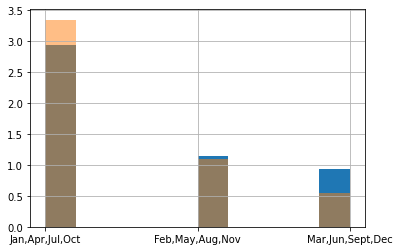

In [ ]:
col = "PromoInterval"
in_df[col].hist(density=True)
s[col].hist(density=True, alpha=0.5)

In [ ]:
in_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
in_df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [ ]:
parent_rtf.column_has_missing

{'StoreType': False,
 'Assortment': False,
 'CompetitionDistance': True,
 'CompetitionOpenSinceMonth': True,
 'CompetitionOpenSinceYear': True,
 'Promo2': False,
 'Promo2SinceWeek': True,
 'Promo2SinceYear': True,
 'PromoInterval': True}

In [ ]:
in_df.drop("Store", axis=1)

StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0            c          a               1270.0                        9.0   
1            a          a                570.0                       11.0   
2            a          a              14130.0                       12.0   
3            c          c                620.0                        9.0   
4            a          a              29910.0                        4.0   
...        ...        ...                  ...                        ...   
1110         a          a               1900.0                        6.0   
1111         c          c               1880.0                        4.0   
1112         a          c               9260.0                        NaN   
1113         a          c                870.0                        NaN   
1114         d          c               5350.0                        NaN   

      CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                       2008.0       0              NaN              NaN   
1                       2007.0       1             13.0           2010.0   
2                       2006.0       1             14.0           2011.0   
3                       2009.0       0              NaN              NaN   
4                       2015.0       0              NaN              NaN   
...                        ...     ...              ...              ...   
1110                    2014.0       1             31.0           2013.0   
1111                    2006.0       0              NaN              NaN   
1112                       NaN       0              NaN              NaN   
1113                       NaN       0              NaN              NaN   
1114                       NaN       1             22.0           2012.0   

         PromoInterval  
0                  NaN  
1      Jan,Apr,Jul,Oct  
2      Jan,Apr,Jul,Oct  
3                  NaN  
4                  NaN  
...                ...  
1110   Jan,Apr,Jul,Oct  
1111               NaN  
1112               NaN  
1113               NaN  
1114  Mar,Jun,Sept,Dec  

[1115 rows x 9 columns]

In [ ]:
in_df.dropna().shape

(365, 10)

In [ ]:
in_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
ee = in_df[["Promo2SinceWeek", "PromoInterval"]].copy()
ee

Promo2SinceWeek     PromoInterval
0                 NaN               NaN
1                13.0   Jan,Apr,Jul,Oct
2                14.0   Jan,Apr,Jul,Oct
3                 NaN               NaN
4                 NaN               NaN
...               ...               ...
1110             31.0   Jan,Apr,Jul,Oct
1111              NaN               NaN
1112              NaN               NaN
1113              NaN               NaN
1114             22.0  Mar,Jun,Sept,Dec

[1115 rows x 2 columns]

'@'

In [ ]:
ee.fillna("@@@").replace(f"{realtabformer.data_utils.NUMERIC_NA_TOKEN}+", "NaN", regex=True) #.isnull().sum()

Promo2SinceWeek     PromoInterval
0                NaN               NaN
1               13.0   Jan,Apr,Jul,Oct
2               14.0   Jan,Apr,Jul,Oct
3                NaN               NaN
4                NaN               NaN
...              ...               ...
1110            31.0   Jan,Apr,Jul,Oct
1111             NaN               NaN
1112             NaN               NaN
1113             NaN               NaN
1114            22.0  Mar,Jun,Sept,Dec

[1115 rows x 2 columns]

# Relational Model

In [ ]:
rel_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path="/content/rtf_rossmann_parent/id000016740555427954163712",
    epochs=5,
    output_max_length=None,
    numeric_nparts=1,
)

rel_rtf.save("rtf_rossmann_child")


In [ ]:
rel_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path="/content/rtf_rossmann_parent/id000016740555427954163712",
    epochs=5,
    output_max_length=None,
    numeric_nparts=1,
)

/content/realtabformer/realtabformer.py:149: UserWarning: The `output_max_length` is None. This could result to extended model training if the output length has large variations.
  warnings.warn(
/content/realtabformer/realtabformer.py:277: UserWarning: A trained model for the parent table is available. The encoder will use the pretrained config and weights.
  warnings.warn(


In [ ]:
rel_rtf.fit(df=out_df, in_df=in_df, join_on="Store")

# # /content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
# #   warnings.warn(
# # 100%
# # 68015/68015 [00:19<00:00, 3646.64ex/s]
# # 100%
# # 1115/1115 [00:03<00:00, 281.17ex/s]
# # 100%
# # 1115/1115 [00:00<00:00, 1234.66ex/s]
# # Using cuda_amp half precision backend
# # /usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
# #   warnings.warn(
# # ***** Running training *****
# #   Num examples = 1115
# #   Num Epochs = 5
# #   Instantaneous batch size per device = 8
# #   Total train batch size (w. parallel, distributed & accumulation) = 32
# #   Gradient Accumulation steps = 4
# #   Total optimization steps = 175
# #   Number of trainable parameters = 57949440
# # /usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
# #   warnings.warn(DEPRECATION_WARNING, FutureWarning)
# #  [175/175 16:19, Epoch 5/5]
# # Step	Training Loss
# # 100	1.961500
# # Saving model checkpoint to rtf_checkpoints/checkpoint-100
# # Configuration saved in rtf_checkpoints/checkpoint-100/config.json
# # Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
# # /usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
# #   warnings.warn(DEPRECATION_WARNING, FutureWarning)


# # Training completed. Do not forget to share your model on huggingface.co/models =)


# # <transformers.trainer_seq2seq.Seq2SeqTrainer at 0x7f5e81b05ac0>

/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/68015 [00:00<?, ?ex/s]

  0%|          | 0/1115 [00:00<?, ?ex/s]

  0%|          | 0/1115 [00:00<?, ?ex/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1115
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 175
  Number of trainable parameters = 57737472
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained wi

Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
rel_rtf.save("rtf_rossmann_child")

In [ ]:
# rel_rtf.fit(df=out_df, in_df=in_df, join_on="Store")

# # 100%
# # 68015/68015 [00:31<00:00, 2974.60ex/s]
# # 100%
# # 1115/1115 [00:04<00:00, 236.36ex/s]
# # 100%
# # 1115/1115 [00:00<00:00, 928.74ex/s]
# # Using cuda_amp half precision backend
# # /usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
# #   warnings.warn(
# # ***** Running training *****
# #   Num examples = 1115
# #   Num Epochs = 5
# #   Instantaneous batch size per device = 8
# #   Total train batch size (w. parallel, distributed & accumulation) = 32
# #   Gradient Accumulation steps = 4
# #   Total optimization steps = 175
# #   Number of trainable parameters = 101399808
# # /usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
# #   warnings.warn(DEPRECATION_WARNING, FutureWarning)
# #  [175/175 15:33, Epoch 5/5]
# # Step	Training Loss
# # 100	2.393000
# # Saving model checkpoint to rtf_checkpoints/checkpoint-100
# # Configuration saved in rtf_checkpoints/checkpoint-100/config.json
# # Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
# # /usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
# #   warnings.warn(DEPRECATION_WARNING, FutureWarning)


# # Training completed. Do not forget to share your model on huggingface.co/models =)


# # <transformers.trainer_seq2seq.Seq2SeqTrainer at 0x7f35a3745280>

In [ ]:
parent_rtf = REaLTabFormer.load_from_dir("/content/rtf_rossmann_parent/id000016740555427954163712")

Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 144
}



In [ ]:
parent_samples = parent_rtf.sample(n_samples=len(in_df))
parent_samples.index.name = "Store"
parent_samples = parent_samples.reset_index()
parent_samples

  0%|          | 0/1115 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1152 samples generated. Sampling efficiency is: 100.0000%


Store StoreType Assortment  CompetitionDistance  \
0         0         d          a                850.0   
1         1         d          c              17110.0   
2         2         b          b                900.0   
3         3         d          c               1280.0   
4         4         a          a                720.0   
...     ...       ...        ...                  ...   
1110   1110         d          c              16420.0   
1111   1111         a          c               1200.0   
1112   1112         a          a                560.0   
1113   1113         d          c               1350.0   
1114   1114         a          a                180.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           NaN                       NaN       1   
1                          11.0                    2007.0       1   
2                           NaN                       NaN       1   
3                           NaN                       NaN       1   
4                          11.0                    2012.0       0   
...                         ...                       ...     ...   
1110                        NaN                       NaN       0   
1111                        6.0                    2012.0       1   
1112                        NaN                       NaN       1   
1113                        NaN                       NaN       1   
1114                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                45.0           2009.0   Feb,May,Aug,Nov  
1                 5.0           2013.0   Jan,Apr,Jul,Oct  
2                10.0           2013.0  Mar,Jun,Sept,Dec  
3                31.0           2013.0   Jan,Apr,Jul,Oct  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110              NaN              NaN               NaN  
1111             40.0           2012.0   Jan,Apr,Jul,Oct  
1112             45.0           2009.0   Feb,May,Aug,Nov  
1113             45.0           2009.0   Feb,May,Aug,Nov  
1114              NaN              NaN               NaN  

[1115 rows x 10 columns]

In [ ]:
max(list(parent_samples["Store"]))

1114

Store StoreType Assortment  CompetitionDistance  \
0         0         d          a                850.0   
1         1         d          c              17110.0   
2         2         b          b                900.0   
3         3         d          c               1280.0   
4         4         a          a                720.0   
...     ...       ...        ...                  ...   
1110   1110         d          c              16420.0   
1111   1111         a          c               1200.0   
1112   1112         a          a                560.0   
1113   1113         d          c               1350.0   
1114   1114         a          a                180.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           NaN                       NaN       1   
1                          11.0                    2007.0       1   
2                           NaN                       NaN       1   
3                           NaN                       NaN       1   
4                          11.0                    2012.0       0   
...                         ...                       ...     ...   
1110                        NaN                       NaN       0   
1111                        6.0                    2012.0       1   
1112                        NaN                       NaN       1   
1113                        NaN                       NaN       1   
1114                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                45.0           2009.0   Feb,May,Aug,Nov  
1                 5.0           2013.0   Jan,Apr,Jul,Oct  
2                10.0           2013.0  Mar,Jun,Sept,Dec  
3                31.0           2013.0   Jan,Apr,Jul,Oct  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110              NaN              NaN               NaN  
1111             40.0           2012.0   Jan,Apr,Jul,Oct  
1112             45.0           2009.0   Feb,May,Aug,Nov  
1113             45.0           2009.0   Feb,May,Aug,Nov  
1114              NaN              NaN               NaN  

[1115 rows x 10 columns]

In [ ]:
rel_samples = rel_rtf.sample(
    input_unique_ids=parent_samples["Store"],
    input_df=parent_samples.drop("Store", axis=1),
    gen_batch=12)

/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/1115 [00:00<?, ?ex/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
rel_samples = rel_rtf.sample(
    input_unique_ids=parent_samples["Store"],
    input_df=parent_samples.drop("Store", axis=1),
    gen_batch=12)

/content/realtabformer/data_utils.py:152: UserWarning: Default values will be overridden because transform_data was passed...
  warnings.warn(


  0%|          | 0/1115 [00:00<?, ?ex/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
rel_samples

DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0             5  2015-07-31   7120        799     1      1            0   
0             4  2015-07-30   6252        613     1      1            0   
0             3  2015-07-29   6404        725     1      1            0   
0             2  2015-07-28   7191        689     1      1            0   
0             1  2015-07-27   6374        752     1      1            0   
...         ...         ...    ...        ...   ...    ...          ...   
1114          5  2015-06-05   7645        812     1      1            0   
1114          4  2015-06-04      2         38     1      1            a   
1114          3  2015-06-03   8005        805     1      1            0   
1114          2  2015-06-02   8966        935     1      1            0   
1114          1  2015-06-01  10399        791     1      1            0   

      SchoolHoliday  
0                 1  
0                 1  
0                 1  
0                 1  
0                 1  
...             ...  
1114              0  
1114              0  
1114              0  
1114              0  
1114              0  

[67751 rows x 8 columns]

In [ ]:
out_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
rel_samples.shape

(67751, 8)

In [ ]:
rel_samples2 = rel_samples.copy()
rel_samples2["Store"] = rel_samples.index
rel_samples2 = rel_samples2[out_df.columns]
rel_samples2.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      0          5  2015-07-31   7120        799     1      1            0   
0      0          4  2015-07-30   6252        613     1      1            0   
0      0          3  2015-07-29   6404        725     1      1            0   
0      0          2  2015-07-28   7191        689     1      1            0   
0      0          1  2015-07-27   6374        752     1      1            0   

   SchoolHoliday  
0              1  
0              1  
0              1  
0              1  
0              1

In [ ]:
rel_samples2 = rel_samples.copy()
rel_samples2["Store"] = rel_samples.index
rel_samples2 = rel_samples2[out_df.columns]
rel_samples2.head()

rel_samples.to_csv("rtf_rossmann_2015-06_train_samples-pretrained_fixed.csv", index=None)
parent_samples.to_csv("rtf_rossmann_2015-06_stores_samples-parent_fixed.csv", index=None)

In [ ]:
rel_samples.head()

DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0          5  2015-07-31   7120        799     1      1            0   
0          4  2015-07-30   6252        613     1      1            0   
0          3  2015-07-29   6404        725     1      1            0   
0          2  2015-07-28   7191        689     1      1            0   
0          1  2015-07-27   6374        752     1      1            0   

   SchoolHoliday  
0              1  
0              1  
0              1  
0              1  
0              1

In [ ]:
out_df[out_df["Date"] == "2015-07-31"]

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0         1          5  2015-07-31   5263        555     1      1   
1         2          5  2015-07-31   6064        625     1      1   
2         3          5  2015-07-31   8314        821     1      1   
3         4          5  2015-07-31  13995       1498     1      1   
4         5          5  2015-07-31   4822        559     1      1   
...     ...        ...         ...    ...        ...   ...    ...   
1110   1111          5  2015-07-31   5723        422     1      1   
1111   1112          5  2015-07-31   9626        767     1      1   
1112   1113          5  2015-07-31   7289        720     1      1   
1113   1114          5  2015-07-31  27508       3745     1      1   
1114   1115          5  2015-07-31   8680        538     1      1   

     StateHoliday  SchoolHoliday  
0               0              1  
1               0              1  
2               0              1  
3               0              1  
4               0              1  
...           ...            ...  
1110            0              1  
1111            0              1  
1112            0              1  
1113            0              1  
1114            0              1  

[1115 rows x 9 columns]

Store


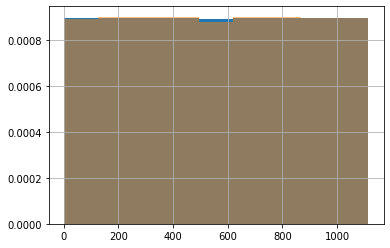

DayOfWeek


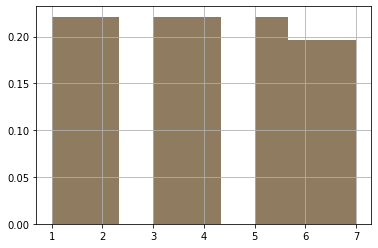

Date


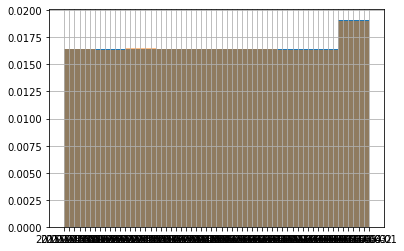

Sales


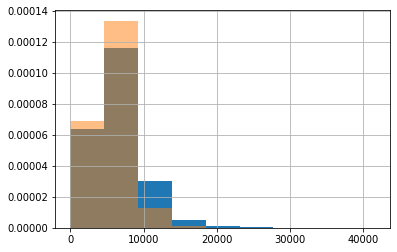

Customers


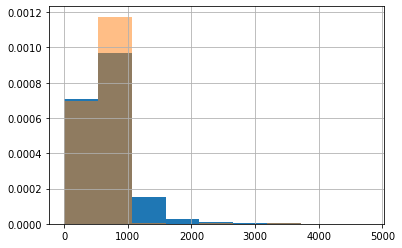

Open


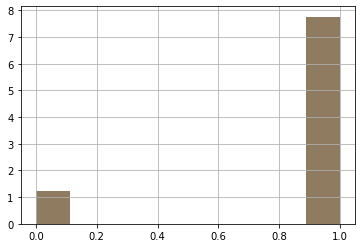

Promo


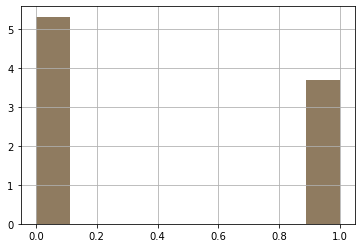

StateHoliday


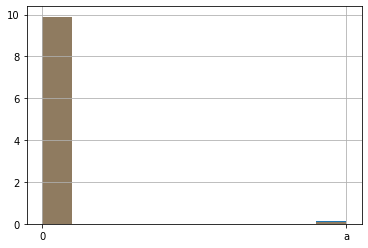

SchoolHoliday


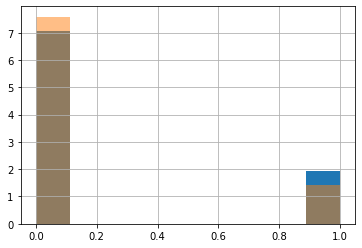

In [ ]:
for col in out_df.columns:
    print(col)
    if out_df[col].dtype == "object":
        out_df[col].hist(density=True)
        rel_samples2[col].hist(density=True, alpha=0.5)        
    else:
        bins = np.linspace(out_df[col].min(), out_df[col].max(), 10)
        out_df[col].hist(bins=bins, density=True)
        rel_samples2[col].hist(bins=bins, density=True, alpha=0.5)

    plt.show()

array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Sales'}>],
       [<AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'Promo'}>],
       [<AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

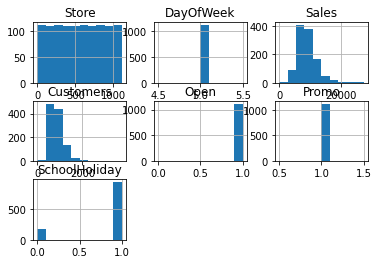

In [ ]:
out_df[out_df["Date"] == "2015-07-31"].hist(bins=10)

array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Sales'}>],
       [<AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'Promo'}>],
       [<AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

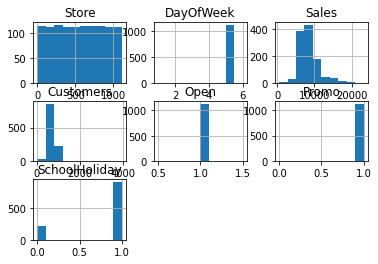

In [ ]:
rel_samples2[rel_samples2["Date"] == "2015-07-31"].hist(bins=10)

In [ ]:
col = "Customers"
rel_samples2[col].value_counts()

0       9112
600      330
612      280
512      277
642      266
        ... 
3268       1
3158       1
2684       1
1240       1
1006       1
Name: Customers, Length: 1403, dtype: int64

In [ ]:
out_df[col].value_counts()

0       9404
550      202
571      194
469      186
614      184
        ... 
2322       1
2123       1
1752       1
1774       1
2000       1
Name: Customers, Length: 2528, dtype: int64

<AxesSubplot: xlabel='Date'>

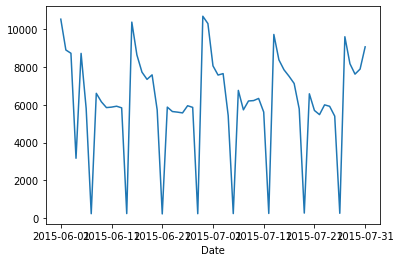

In [ ]:
out_df.groupby("Date")["Sales"].mean().plot()

<AxesSubplot: xlabel='Date'>

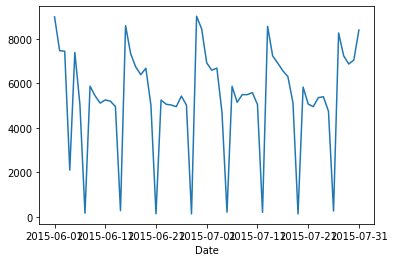

In [ ]:
rel_samples2.groupby("Date")["Sales"].mean().plot()

<AxesSubplot: xlabel='Date'>

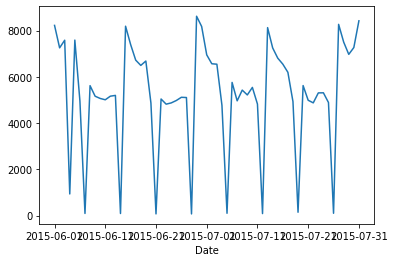

In [ ]:
rel_samples.groupby("Date")["Sales"].mean().plot()

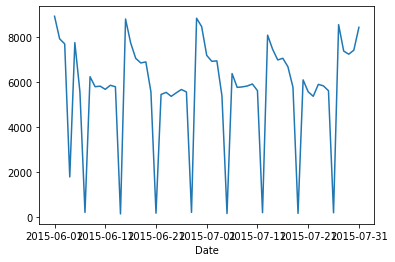

In [ ]:
samps.groupby("Date")["Sales"].mean().plot()

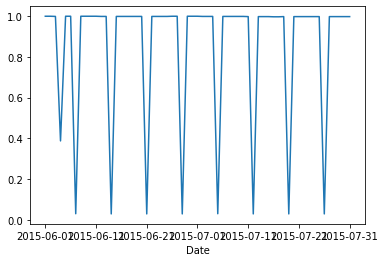

In [ ]:
out_df.groupby("Date")["Open"].mean().plot()

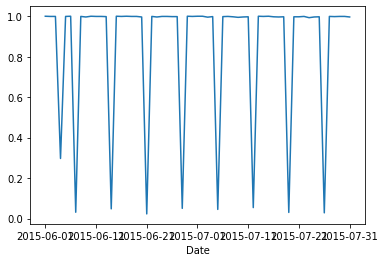

In [ ]:
samps.groupby("Date")["Open"].mean().plot()

# SDV

In [ ]:
from sdv import Metadata
from sdv.relational import HMA1

metadata = Metadata()

metadata.add_table(
    name='stores',
    data=in_df,
    primary_key='Store'
)

train_fields = {
    'Date': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    }
}

metadata.add_table(
    name='train',
    data=out_df,
    # primary_key='session_id',
    fields_metadata=train_fields,
    parent='stores',
    foreign_key='Store'
)

print(metadata)

model = HMA1(metadata)

tables = dict(
    train=out_df,
    stores=in_df,
)

model.fit(tables)

new_data = model.sample(num_rows=len(in_df))

sdv_store_samps = new_data["stores"]
sdv_train_samps = new_data["train"]

Metadata
  root_path: .
  tables: ['stores', 'train']
  relationships:
    train.Store -> stores.Store

/usr/local/lib/python3.8/dist-packages/sdv/relational/hma.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_rows[foreign_key] = parent_row[parent_key]


array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Date'}>],
       [<AxesSubplot: title={'center': 'Sales'}>,
        <AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>],
       [<AxesSubplot: title={'center': 'Promo'}>,
        <AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >]], dtype=object)

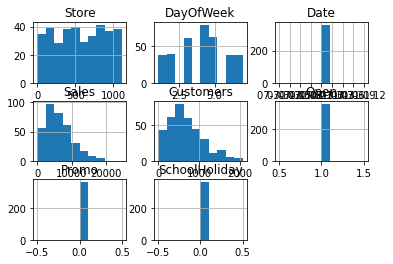

In [ ]:
sdv_train_samps[out_df.columns][sdv_train_samps["Date"] == "2015-07-31"].hist(bins=10)

array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Sales'}>],
       [<AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'Promo'}>],
       [<AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

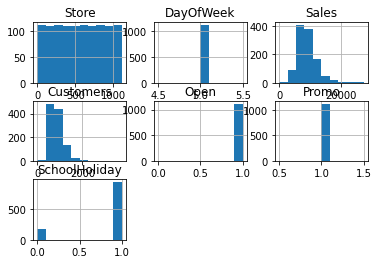

In [ ]:
out_df[out_df["Date"] == "2015-07-31"].hist(bins=10)

array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Sales'}>],
       [<AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'Promo'}>],
       [<AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

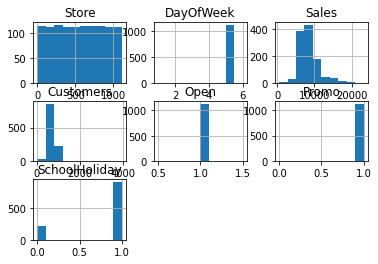

In [ ]:
rel_samples2[rel_samples2["Date"] == "2015-07-31"].hist(bins=10)

In [ ]:
out_df[out_df["Date"] == "2015-07-31"]["DayOfWeek"]

0       5
1       5
2       5
3       5
4       5
       ..
1110    5
1111    5
1112    5
1113    5
1114    5
Name: DayOfWeek, Length: 1115, dtype: int64

In [ ]:
rel_samples2[rel_samples2["Date"] == "2015-07-31"]["DayOfWeek"]

0       5
1       5
2       5
3       5
4       5
       ..
1110    5
1111    5
1112    5
1113    5
1114    5
Name: DayOfWeek, Length: 1125, dtype: int64

In [ ]:
sdv_train_samps[sdv_train_samps["Date"] == "2015-07-31"]["DayOfWeek"]

91       5
133      7
236      3
252      2
575      3
        ..
67387    4
67438    1
67644    3
67756    4
67934    5
Name: DayOfWeek, Length: 358, dtype: int64

StoreType


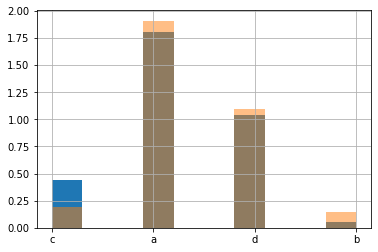

Assortment


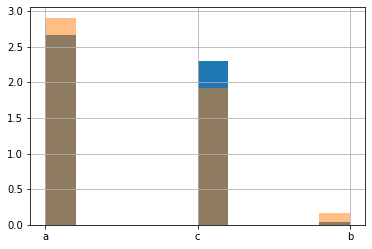

CompetitionDistance


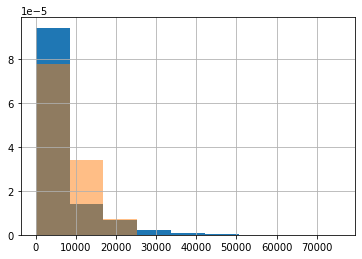

CompetitionOpenSinceMonth


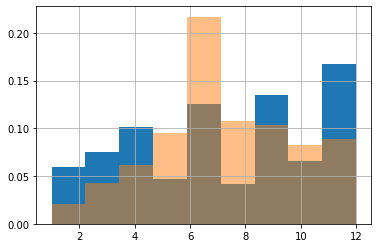

CompetitionOpenSinceYear


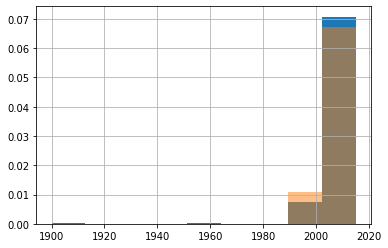

Promo2


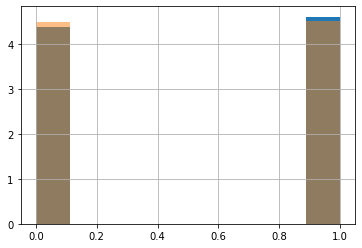

Promo2SinceWeek


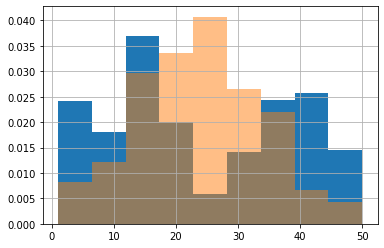

Promo2SinceYear


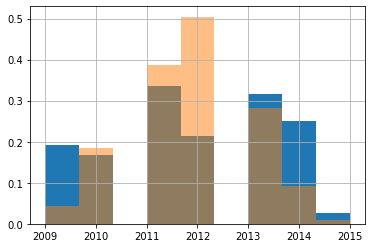

PromoInterval


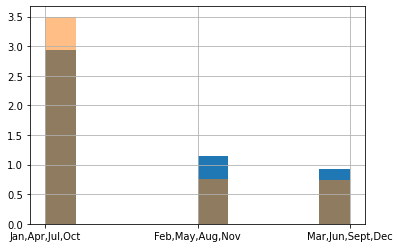

In [ ]:
for col in samples.columns:
    print(col)
    if in_df[col].dtype == "object":
        in_df[col].hist(density=True)
        sdv_store_samps[col].hist(density=True, alpha=0.5)        
    else:
        bins = np.linspace(in_df[col].min(), in_df[col].max(), 10)
        in_df[col].hist(bins=bins, density=True)
        sdv_store_samps[col].hist(bins=bins, density=True, alpha=0.5)

    plt.show()

In [ ]:
len(sdv_samps)

68015

In [ ]:
len(out_df)

68015

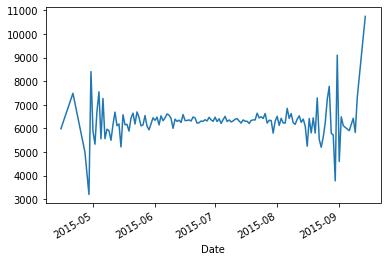

In [ ]:
sdv_samps.groupby("Date")["Sales"].mean().plot()

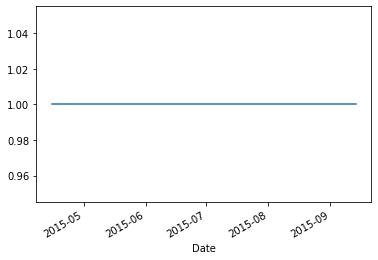

In [ ]:
sdv_samps.groupby("Date")["Open"].mean().plot()

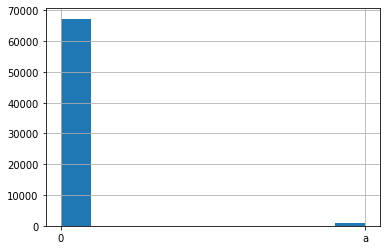

In [ ]:
out_df["StateHoliday"].hist()

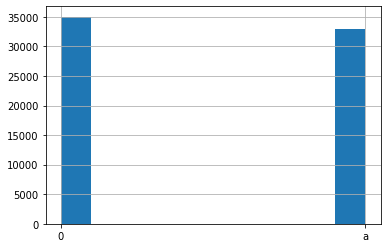

In [ ]:
sdv_samps["StateHoliday"].hist()

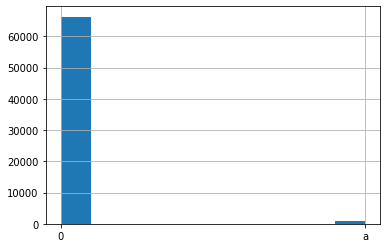

In [ ]:
samps["StateHoliday"].hist()

StateHoliday
0    67249
a      766
dtype: int64

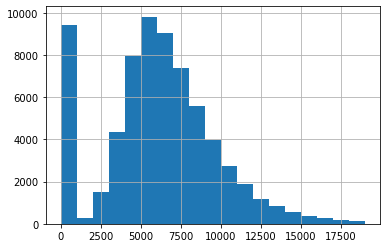

In [ ]:
out_df["Sales"].hist(bins=range(0, 20000, 1000))

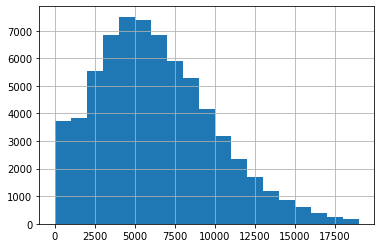

In [ ]:
sdv_samps["Sales"].hist(bins=range(0, 20000, 1000))

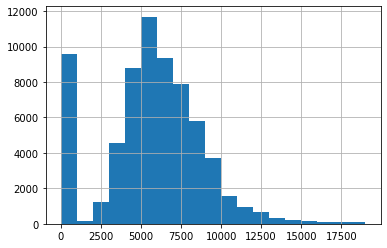

In [ ]:
samps["Sales"].hist(bins=range(0, 20000, 1000))

In [ ]:
tt = pd.to_datetime(samps["Date"])
tt

1      2015-07-31
1      2015-07-30
1      2015-07-29
1      2015-07-28
1      2015-07-27
          ...    
1115   2015-06-05
1115   2015-06-04
1115   2015-06-03
1115   2015-06-02
1115   2015-06-01
Name: Date, Length: 67051, dtype: datetime64[ns]

In [ ]:
samps

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1       251          5  2015-07-31   8553        816     1      1   
1       251          4  2015-07-30   6281        411     1      1   
1       251          3  2015-07-29   6524        419     1      1   
1       251          2  2015-07-28   7818        868     1      1   
1       251          1  2015-07-27   6572        417     1      1   
...     ...        ...         ...    ...        ...   ...    ...   
1115     73          5  2015-06-05   4407        657     1      1   
1115     73          4  2015-06-04      0          0     0      1   
1115     73          3  2015-06-03   3384        832     1      1   
1115     73          2  2015-06-02   7134        492     1      1   
1115     73          1  2015-06-01   5763        740     1      1   

     StateHoliday  SchoolHoliday  
1               0              1  
1               0              1  
1               0              1  
1               0              1  
1               0              1  
...           ...            ...  
1115            0              0  
1115            a              0  
1115            0              0  
1115            0              0  
1115            0              0  

[67051 rows x 9 columns]

In [ ]:
out_df.shape

(68015, 9)

In [ ]:
rel_rtf.relational_max_length

1935

In [ ]:
dataset = _fit_relational(rel_rtf, train, store, "Store")

  0%|          | 0/1017209 [00:00<?, ?ex/s]

  0%|          | 0/1115 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/realtabformer/data_utils.py:685: UserWarning: A total of 1115 out of 1115 has been removed from the training data because they exceeded the `output_max_length` of 4096.
  warnings.warn(


In [ ]:

# Compute the longest sequence of labels in the dataset and add a buffer of 1.
self.relational_max_length = (
    max(
        dataset.map(lambda example: dict(length=len(example["labels"])))[
            "length"
        ]
    )
    + 1
)


In [ ]:
dataset

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 0
})

In [ ]:
rel_rtf.relational_max_length

4455

In [ ]:
rel_rtf.relational_max_length

19785

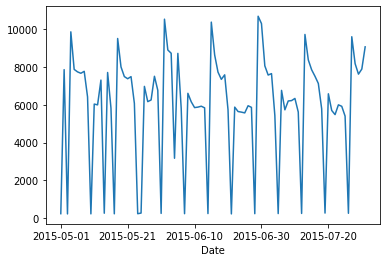

In [ ]:
train[train["Date"] > "2015-05"].groupby("Date")["Sales"].mean().plot()

In [ ]:
m = train[train["Date"] > "2015-05"]  # .shape[0] // 1115

In [ ]:
m

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0           1          5  2015-07-31   5263        555     1      1   
1           2          5  2015-07-31   6064        625     1      1   
2           3          5  2015-07-31   8314        821     1      1   
3           4          5  2015-07-31  13995       1498     1      1   
4           5          5  2015-07-31   4822        559     1      1   
...       ...        ...         ...    ...        ...   ...    ...   
102575   1111          5  2015-05-01      0          0     0      1   
102576   1112          5  2015-05-01      0          0     0      1   
102577   1113          5  2015-05-01      0          0     0      1   
102578   1114          5  2015-05-01      0          0     0      1   
102579   1115          5  2015-05-01      0          0     0      1   

       StateHoliday  SchoolHoliday  
0                 0              1  
1                 0              1  
2                 0              1  
3                 0              1  
4                 0              1  
...             ...            ...  
102575            a              0  
102576            a              0  
102577            a              0  
102578            a              0  
102579            a              0  

[102580 rows x 9 columns]

In [ ]:
t = pd.to_datetime(m["Date"])
t

0        2015-07-31
1        2015-07-31
2        2015-07-31
3        2015-07-31
4        2015-07-31
            ...    
102575   2015-05-01
102576   2015-05-01
102577   2015-05-01
102578   2015-05-01
102579   2015-05-01
Name: Date, Length: 102580, dtype: datetime64[ns]

In [ ]:
t.view(int)

0         1438300800000000000
1         1438300800000000000
2         1438300800000000000
3         1438300800000000000
4         1438300800000000000
                 ...         
102575    1430438400000000000
102576    1430438400000000000
102577    1430438400000000000
102578    1430438400000000000
102579    1430438400000000000
Name: Date, Length: 102580, dtype: int64

In [ ]:
s = (t.view(int) / 1e9).astype(int)
s

0         1438300800
1         1438300800
2         1438300800
3         1438300800
4         1438300800
             ...    
102575    1430438400
102576    1430438400
102577    1430438400
102578    1430438400
102579    1430438400
Name: Date, Length: 102580, dtype: int64

In [ ]:
(s - s.mean()).astype(pd.Int64Dtype())

0          3931200
1          3931200
2          3931200
3          3931200
4          3931200
            ...   
102575    -3931200
102576    -3931200
102577    -3931200
102578    -3931200
102579    -3931200
Name: Date, Length: 102580, dtype: Int64

In [ ]:
236380 // 1115

212

In [ ]:
train["Store"].value_counts()

1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: Store, Length: 1115, dtype: int64

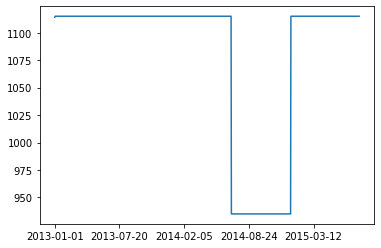

In [ ]:
train["Date"].value_counts().sort_index().plot()